# MGT Team Project

**Contents:**

0. Loading Packages & Data
1. Data Preprocessing
2. Exploratory Data Analysis
3. Preliminary Modeling (presented in the progress report)
4. Final Modeling (presented in the final report)

## 0. Loading Packages & Data

Note: Make sure that all required packages are installed on your system before proceeding. 
Refer to the 'requirements.txt' file or the list in the cell below for the necessary packages. To install a package, use the command: install.packages("package_name")

In [1]:
# load packages
library(stringr)
library(dplyr)
library(ggplot2)
library(ggcorrplot)
library(car)
library(vcd)
library(pscl)
library(MASS)
library(caret)
library(pROC)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Loading required package: grid

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
rm(list=ls())
getwd()

[1] "/Users/zoe/Documents/GT/23_Fall/MGT6203-DAB/Repo_Test/Team-48/Code"

In [3]:
# load dataset
setwd("../") # set working directory to the cloned repository. change directory path if needed.
twts <- readRDS("./Data/twts.RDS")
brands <- readRDS("./Data/brands.RDS")

## 1. Data Preprocessing

In [4]:
# extract organic tweets only
twts <- twts[twts$organic == 'organic',]

In [5]:
# add 'visual_presence' column to mark presence of visuals
for (i in 1:nrow(twts)) {
  # reset media_url to NA at the start of each iteration
  media_url <- NA
  
  # extract the media URL
  tryCatch({
    urls <- twts$entities[[i]]$media$media_url
    media_url <- if (length(urls) > 0) urls[1] else NA
  }, error = function(e) {
    # print an error message if an error occurs
    message(paste("Error in row", i, ":", e$message))
  })
  
  # assign the media URL to the dataframe
  twts$media_url[i] <- media_url
  
  # test for non-NA and non-empty strings, and that it contains "http"
  if (!is.na(media_url) && nzchar(media_url) && str_detect(media_url, "http")) {
    twts$visual_presence[i] <- 1
  } else {
    twts$visual_presence[i] <- 0
  }
}

table(twts$visual_presence)


    0     1 
25548 30057 

In [6]:
# add 'followers_count' column by joining twts & brands data
# match screen_name 'Allbirds' before joining (this is the only brand with an unmatching name)
twts <- twts %>%
  mutate(screen_name = replace(screen_name, screen_name == "allbirds", "Allbirds"))
brands_selected <- dplyr::select(brands, screen_name, followers_count)

twts <- left_join(twts, brands_selected, by = "screen_name")

# # check na in 'followers_count' column
# sum(is.na(twts$followers_count))   # 0

In [7]:
# add 'norm_fav' column, which is favorite_count / followers_count
twts <- twts %>%
  mutate(norm_fav = ifelse(followers_count != 0, favorite_count / followers_count, NA))

In [8]:
# create a new df containing the variables we are interested in
data <- twts[c("created_at", "text", "visual_presence", "followers_count", "favorite_count", 
                "norm_fav", "screen_name", "word_count", 
                "syuzhet", "anger", "anticipation", "disgust", 
                "fear", "joy", "sadness", "surprise", "trust", 
                "negative", "positive")]

# remove brands, twts dataset
rm(brands)
rm(twts)

In [9]:
# add 'scaled_norm_like' column to prevent errors in Poisson-related models
data <- data %>%
    mutate(scaled_norm_fav = round(norm_fav, 3) *1000)

In [10]:
# add 'fav_thres' column to indicate the 75% threshold for favorite_counts
fav_75quantile = quantile(data$favorite_count, 0.75) # 75% = 4

data <- data %>%
  mutate(fav_thres = ifelse(favorite_count >= fav_75quantile, 1, 0))

In [11]:
# add 'norm_fav_thres' column to indicate the 75% threshold for normalized_like
norm_fav_75quantile <- quantile(data$norm_fav, 0.75) # 75% = 3.949447e-04

data <- data %>%
  mutate(norm_fav_thres = ifelse(norm_fav >= norm_fav_75quantile, 1, 0))

In [12]:
# add log, sqrt transformed word_count, syuzhet, norm_fav, scaled_norm_fav columns for convenience during test

data$sqrt_word_count <- sqrt(data$word_count)
data$sqrt_syuzhet <- sqrt(data$syuzhet + 4.5)
data$sqrt_favorite_count <- sqrt(data$favorite_count + 1)
data$sqrt_norm_fav <- sqrt(data$norm_fav + 1)
data$sqrt_scaled_norm_fav <- sqrt(data$scaled_norm_fav + 1)
data$log_word_count <- log(data$word_count + 1)
data$log_syuzhet <- log(data$syuzhet + 4.5)
data$log_favorite_count <- log(data$favorite_count + 1)
data$log_norm_fav <- log(data$norm_fav + 1)
data$log_scaled_norm_fav <- log(data$scaled_norm_fav + 1)

In [13]:
# change visual_presence variable to factor
data$visual_presence <- factor(data$visual_presence, levels = c(1, 0))

In [14]:
# check null values
sapply(data, function(x) sum(is.na(x)))

created_at                 text      visual_presence 
                   0                    0                    0 
     followers_count       favorite_count             norm_fav 
                   0                    0                    0 
         screen_name           word_count              syuzhet 
                   0                    0                    0 
               anger         anticipation              disgust 
                   0                    0                    0 
                fear                  joy              sadness 
                   0                    0                    0 
            surprise                trust             negative 
                   0                    0                    0 
            positive      scaled_norm_fav            fav_thres 
                   0                    0                    0 
      norm_fav_thres      sqrt_word_count         sqrt_syuzhet 
                   0                    0                    0 
 sqrt_favorite_count        sqrt_norm_fav sqrt_scaled_norm_fav 
                   0                    0                    0 
      log_word_count          log_syuzhet   log_favorite_count 
                   0                    0                    0 
        log_norm_fav  log_scaled_norm_fav 
                   0                    0

In [15]:
str(data)

'data.frame':	55605 obs. of  32 variables:
 $ created_at          : POSIXct, format: "2023-01-29 03:00:40" "2023-01-27 01:30:36" ...
 $ text                : chr  "We could talk about the hundreds of runners and thousands of miles in testing this shoe went through. But it co"| __truncated__ "Enjoying a daily escape into nature 🍃 https://t.co/y9a2KEfFYX" "In hindsight, probably should’ve given this one a quick Google… https://t.co/FLPonPqkcs" "A closer look at our Lunar New Year edition of the Wool Runner. The beige hue represents the rabbit’s peaceful "| __truncated__ ...
 $ visual_presence     : Factor w/ 2 levels "1","0": 1 1 1 1 1 1 1 1 1 1 ...
 $ followers_count     : int  32142 32142 32142 32142 32142 32142 32142 32142 32142 32142 ...
 $ favorite_count      : int  5 4 22 37 3 17 22 9 23 10 ...
 $ norm_fav            : num  1.56e-04 1.24e-04 6.84e-04 1.15e-03 9.33e-05 ...
 $ screen_name         : chr  "Allbirds" "Allbirds" "Allbirds" "Allbirds" ...
 $ word_count          : int  33 

#### Create filtered dataframes: recent_data, data_nonzero, recent_data_nonzero

In [16]:
# create 'recent_data' dataframe with the most recent data (2022 - 2023)
recent_data <- data %>%
  filter(created_at >= as.POSIXct("2022-01-01"))

In [17]:
# create 'data_nonzero' dataframe which excludes rows with favorite_count = 0 and favorite_count > 100,000 (outliers)
# (moved from Data Exploration section for the future convenience)
data_nonzero <- data[data$favorite_count != 0 & data$favorite_count < 100000, ]

# check new quantile
# quantile(data_nonzero$favorite_count) #    1     1     3    13    42899 
# quantile(data_nonzero$norm_fav) # 75%: 9.165903e-04

# edit data_nonzero's 'fav_thres' values
nzro_fav_75quantile <- quantile(data_nonzero$favorite_count, 0.75) # 75%: 13
data_nonzero <- data_nonzero %>%
  mutate(fav_thres <- ifelse(data_nonzero$favorite_count >= nzro_fav_75quantile, 1, 0))

# edit data_nonzero's 'norm_fav_thres'
nzro_norm_fav_75quantile <- quantile(data_nonzero$norm_fav, 0.75) # 75%: 9.165903e-04
data_nonzero <- data_nonzero %>%
  mutate(norm_fav_thres = ifelse(norm_fav >= nzro_norm_fav_75quantile, 1, 0))

In [18]:
# create 'recent_data_nonzero' dataframe with the most recent data (2022 - 2023)
recent_data_nonzero <- data_nonzero %>%
  filter(created_at >= as.POSIXct("2022-01-01"))

#### Analyze the most frequently used business or sustainability related keywords in Top 500 liked tweets in 'recent_data'

In [19]:
# === The code below is for extracting commonly used words related to business and the environment. === #
# === Please note that this is for reference only and does not need to be executed to continue with the analysis. ===== #

# # load package for analyzing texts
# library(tm)

# # select the text column
# text <- recent_data$text

# # transform to lower-case (text normalization)
# text <- tolower(text)

# # create a text corpus
# corpus <- Corpus(VectorSource(text))

# # clean the text
# corpus <- tm_map(corpus, removePunctuation)
# corpus <- tm_map(corpus, removeWords, stopwords("en"))

# # create a document-term matrix
# dtm <- TermDocumentMatrix(corpus) 
# m <- as.matrix(dtm) 
# v <- sort(rowSums(m),decreasing=TRUE)
# d <- data.frame(word = names(v), frequency=v)

# # export the frequent words as a csv file
# #write.csv(d, "frequent_words.csv")
# write.csv(d, "C:/Users/sprin/_GT OMSA/MGT6203/Team project/Project_Team 48/frequent_words.csv")

In [20]:
# add 'biz_presence', 'eco_presence' columns to indicate the presence of top 10 biz/eco keywords
#ten keywords
# assign the keywords onto different groups
biz_words_10 <- c("new", "shop", "comfortable", "now", "collection", "online", "love", "review", "sale", "just") 

#eco_words <- c("vegan", "sustainable", "sustainability", "organic") 
eco_words_10 <- c("vegan", "sustainab", "organic", "cotton", "good", "nature", "eco", "earth", "change", "recycle")

# add two new binary variables: "biz_presence", "eco_presence"

pattern <- regex(paste(biz_words_10, collapse = "|"), ignore_case = TRUE)
# recent_data$biz_presence <- str_detect(recent_data$text, pattern) 
recent_data$biz_presence <- ifelse(str_detect(recent_data$text, pattern), 1, 0)

pattern <- regex(paste(eco_words_10, collapse = "|"), ignore_case = TRUE)
# recent_data$eco_presence <- str_detect(recent_data$text, pattern) 
recent_data$eco_presence <- ifelse(str_detect(recent_data$text, pattern), 1, 0)

# count the cases biz_word_presence == True
print(sum(recent_data$biz_presence == 1))

# count the cases biz_word_presence == True
print(sum(recent_data$eco_presence == 1))

[1] 1966
[1] 1059


In [21]:
# change variables to factors
recent_data$biz_presence <- factor(recent_data$biz_presence, levels = c(1, 0))
recent_data$eco_presence <- factor(recent_data$eco_presence, levels = c(1, 0))

In [22]:
str(recent_data)

'data.frame':	3894 obs. of  34 variables:
 $ created_at          : POSIXct, format: "2023-01-29 03:00:40" "2023-01-27 01:30:36" ...
 $ text                : chr  "We could talk about the hundreds of runners and thousands of miles in testing this shoe went through. But it co"| __truncated__ "Enjoying a daily escape into nature 🍃 https://t.co/y9a2KEfFYX" "In hindsight, probably should’ve given this one a quick Google… https://t.co/FLPonPqkcs" "A closer look at our Lunar New Year edition of the Wool Runner. The beige hue represents the rabbit’s peaceful "| __truncated__ ...
 $ visual_presence     : Factor w/ 2 levels "1","0": 1 1 1 1 1 1 1 1 1 1 ...
 $ followers_count     : int  32142 32142 32142 32142 32142 32142 32142 32142 32142 32142 ...
 $ favorite_count      : int  5 4 22 37 3 17 22 9 23 10 ...
 $ norm_fav            : num  1.56e-04 1.24e-04 6.84e-04 1.15e-03 9.33e-05 ...
 $ screen_name         : chr  "Allbirds" "Allbirds" "Allbirds" "Allbirds" ...
 $ word_count          : int  33 1

## 2. Exploratory Data Analysis

Here, we are going to explore three different datasets to check distributions, outliers, linearity and multicollinearity in each dataset

### 2-1. DIstribution

### A. original data

**1) favorite_count (y variable)**

In [23]:
# basic summary of y variable
summary(data$favorite_count)
cat("Mean of favorite_count:", mean(data$favorite_count), "\n")
cat("Variance of favorite_count:", var(data$favorite_count))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      0.00      1.00     49.24      4.00 313114.00 

Mean of favorite_count: 49.24239 
Variance of favorite_count: 4984654

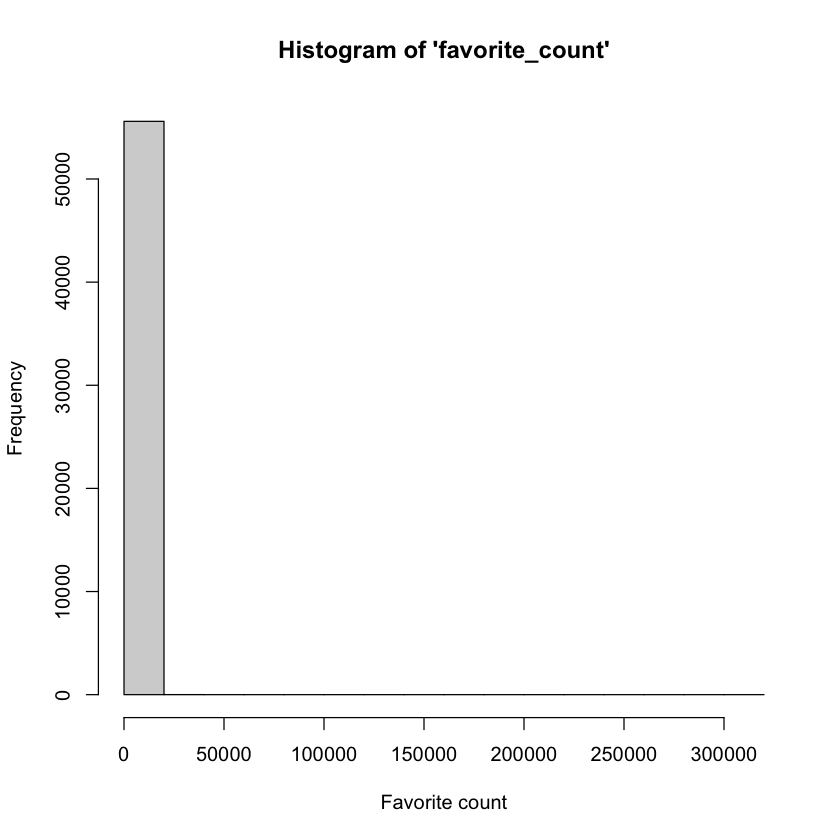

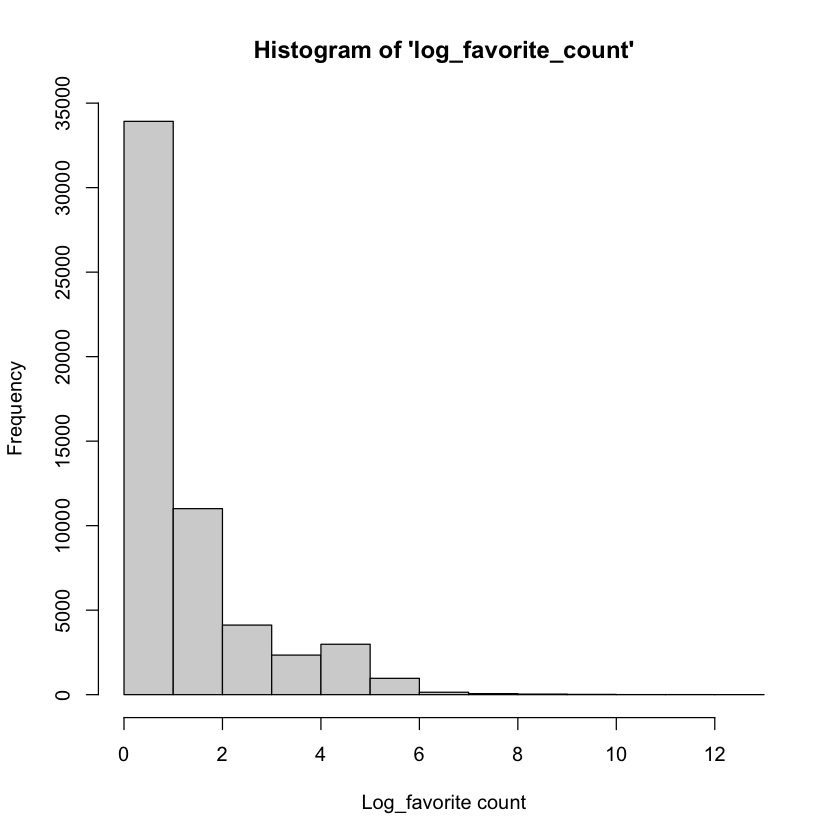

In [24]:
# check the histogram of the response variable 'favorite_count'
hist(data$favorite_count, 
     xlab = "Favorite count",
     ylab = "Frequency",
     main = "Histogram of 'favorite_count'")

# check the histogram of the response variable 'log_favorite_count'
hist(data$log_favorite_count, 
     xlab = "Log_favorite count",
     ylab = "Frequency",
     main = "Histogram of 'log_favorite_count'")

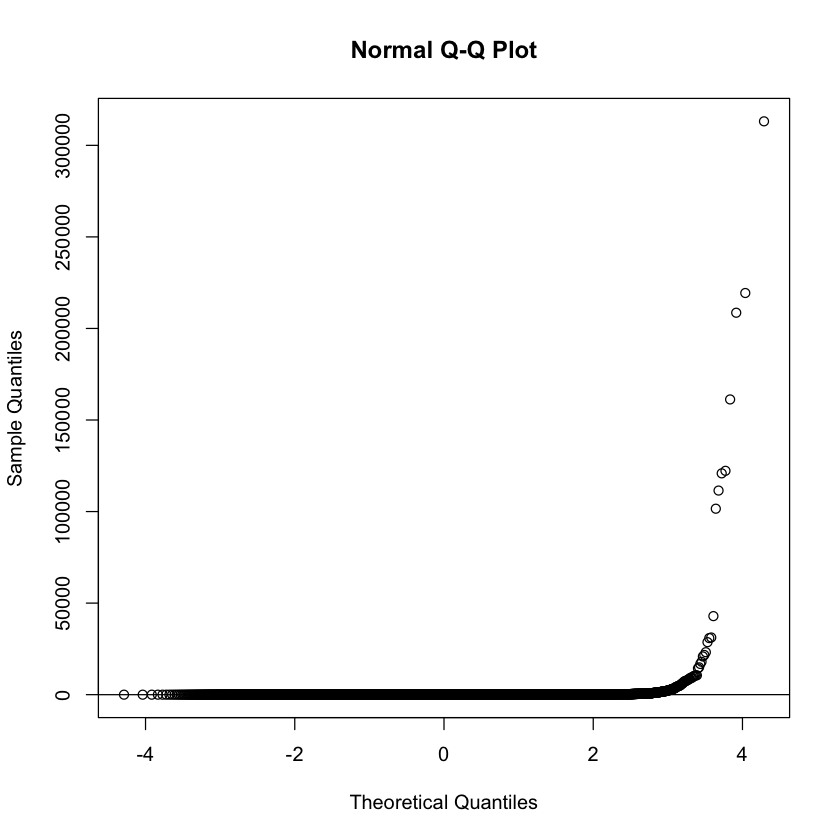

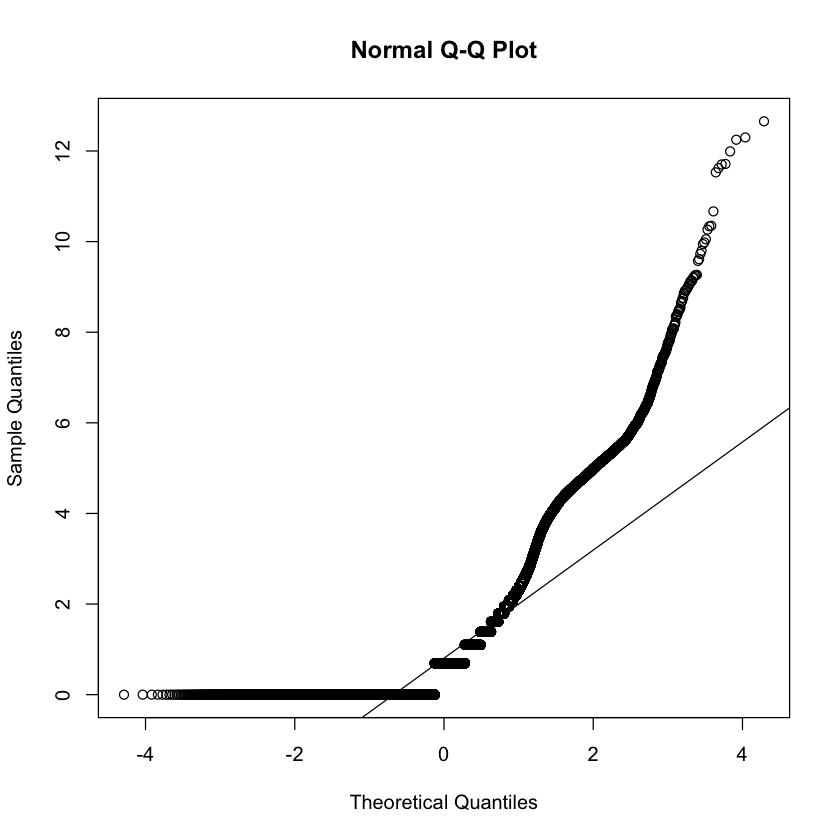

In [25]:
# check QQ-Plot
qqnorm(data$favorite_count); qqline(data$favorite_count)
# check QQ-Plot
qqnorm(data$log_favorite_count); qqline(data$log_favorite_count)

In [26]:
# proportion of 0 counts
# we can see that the majority of data falls on 0 count(45%) and it's extremely right skewed
quantiles <- quantile(data$favorite_count)
cat(sprintf("Proportion of '0' count: %.2f%%\n", 100 * nrow(data[data$favorite_count == 0, ])/nrow(data)))
cat("Quantiles:\n")
cat(sprintf("0%%: %.2f\n25%%: %.2f\n50%%: %.2f\n75%%: %.2f\n100%%: %.2f\n", 
            quantiles[1], quantiles[2], quantiles[3], quantiles[4], quantiles[5]))

Proportion of '0' count: 45.04%
Quantiles:
0%: 0.00
25%: 0.00
50%: 1.00
75%: 4.00
100%: 313114.00


In [27]:
# check if y variable follows Poisson distribution
# test results indicate y variable doesn't follow Poisson distribution
fav_fit <- goodfit(data$favorite_count, type="poisson")
summary(fav_fit)


	 Goodness-of-fit test for poisson distribution

                 X^2  df P(> X^2)
Likelihood Ratio Inf 605        0


**2) word_count (x variable)**

In [28]:
# basic summary of word_count
summary(data$word_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   17.00   23.00   24.95   31.00   89.00 

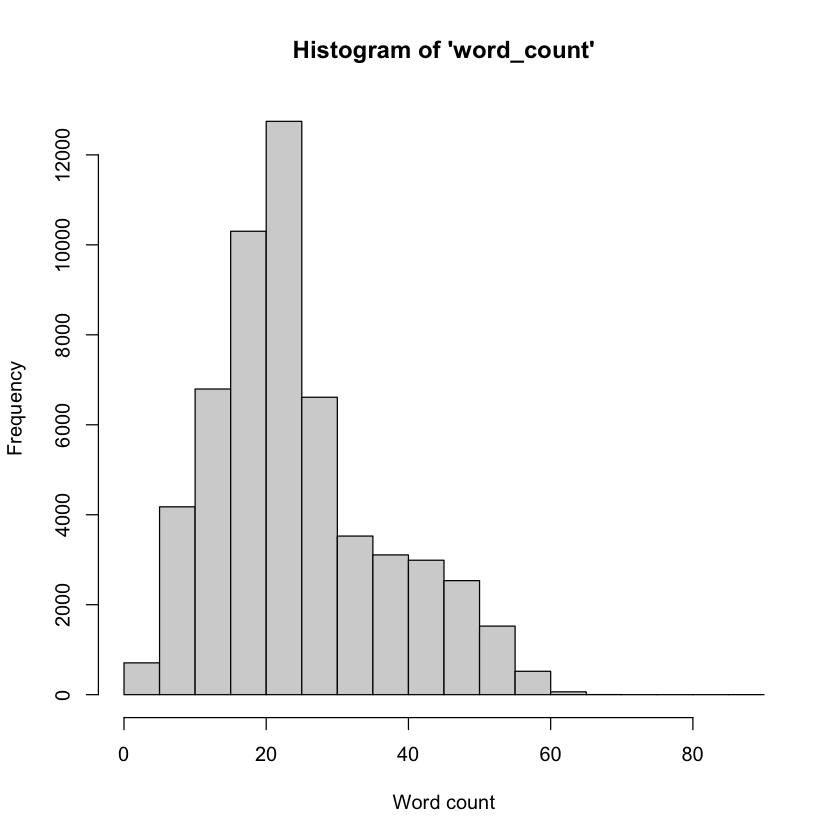

In [29]:
# check the histogram of the predictor variable 'word_count'
# word count is slightly right skewed
hist(data$word_count,
      xlab = "Word count",
      ylab = "Frequency",
      main = "Histogram of 'word_count'")

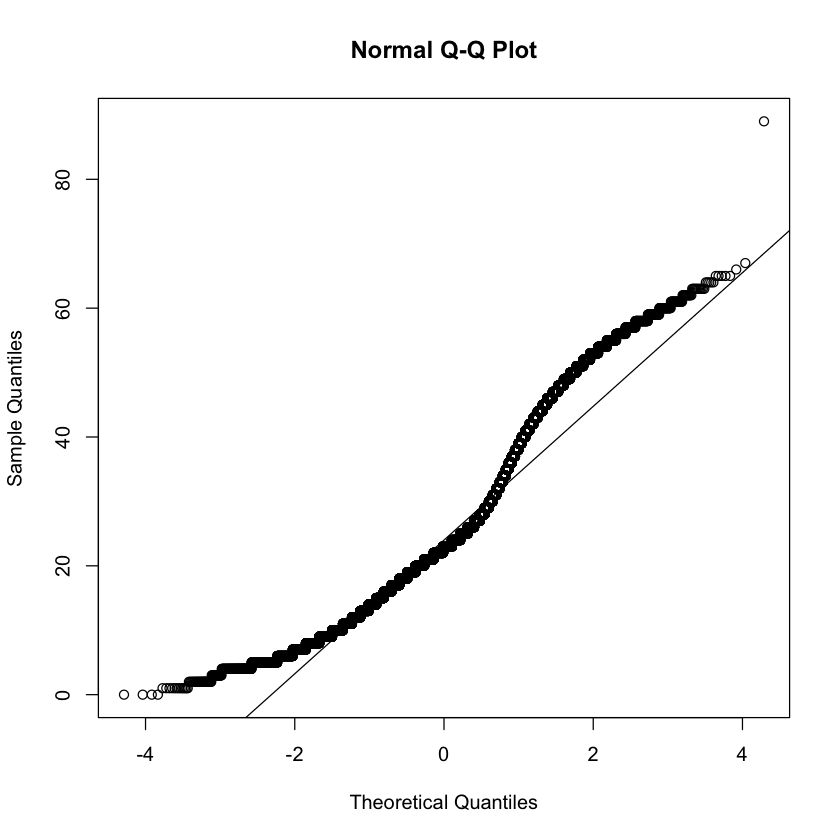

In [30]:
# check QQ-Plot
qqnorm(data$word_count); qqline(data$word_count)

**3) syuzhet  (x variable)**

In [31]:
# basic summary of syuzhet 
summary(data$syuzhet)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-4.2500  0.0000  0.7500  0.9579  1.5500  8.6500 

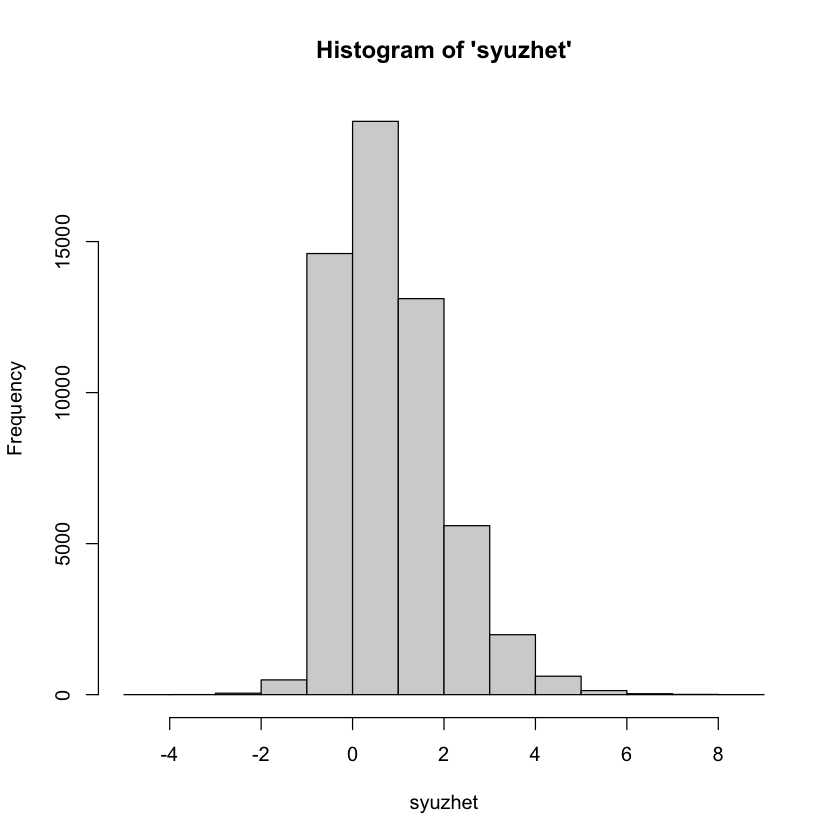

In [32]:
# check the histogram of the predictor variable 'syuzhet'
# syuzhet is slightly right skewed
hist(data$syuzhet,
     xlab = "syuzhet",
     ylab = "Frequency",
     main = "Histogram of 'syuzhet'")

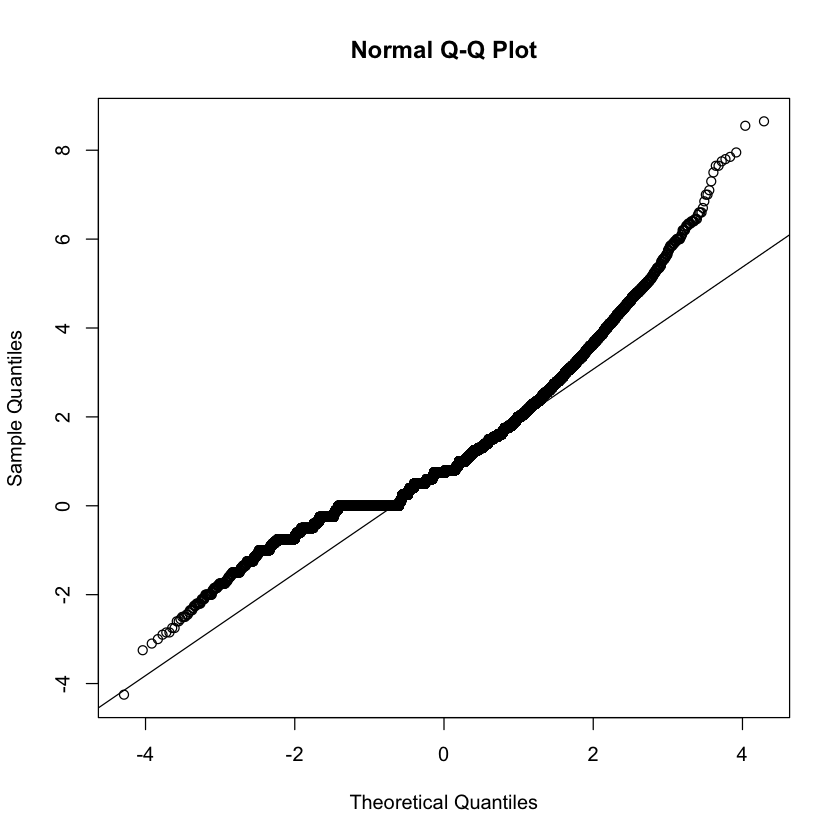

In [33]:
# check QQ-Plot
qqnorm(data$syuzhet); qqline(data$syuzhet)

**4) visual_presence  (x variable)**

In [34]:
# basic summary of visual_presence 
table(data$visual_presence)


    1     0 
30057 25548 

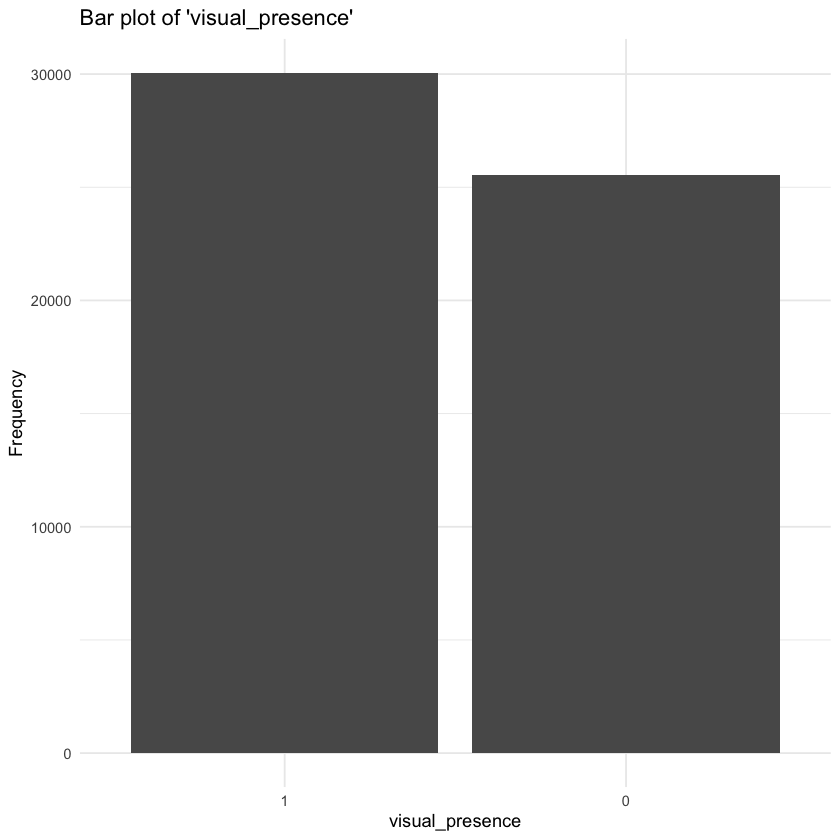

In [35]:
# bar plot - visual_presence
ggplot(data, aes(visual_presence)) + 
  geom_bar() +
  labs(x = "visual_presence", y = "Frequency", title = "Bar plot of 'visual_presence'") +
  theme_minimal()

Since y variable is extremely skewed, using log transformed y variable might be better to satisfy assumptions for linear regression(although it is still right skewed). Otherwise, it might influence model's quality. x variables look good based on the histogram distribution

### B. 'data_nonzero'

**1) favorite_count (y variable)**

In [36]:
# basic summary of y variable
summary(data_nonzero$favorite_count)
cat("Mean of favorite_count:", mean(data_nonzero$favorite_count), "\n")
cat("Variance of favorite_count:", var(data_nonzero$favorite_count))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.00     1.00     3.00    45.16    13.00 42899.00 

Mean of favorite_count: 45.15536 
Variance of favorite_count: 303717.4

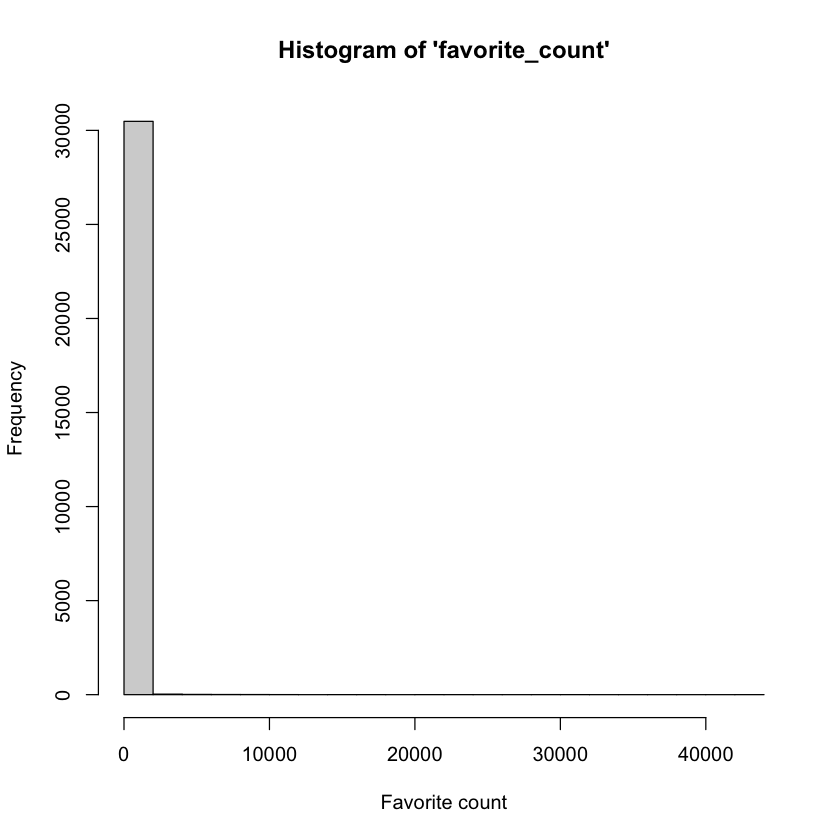

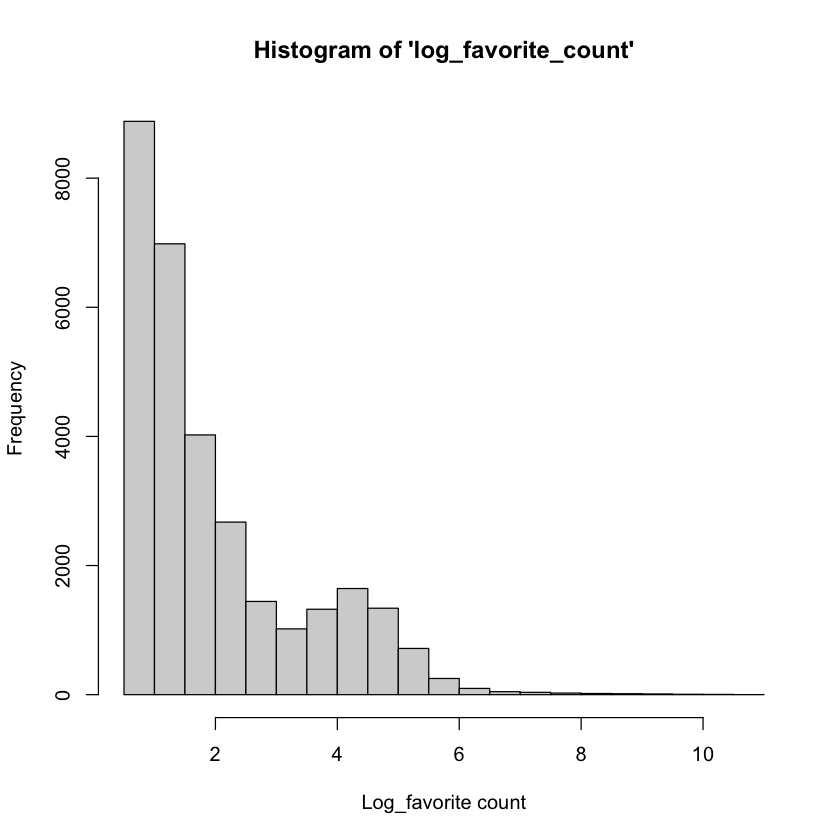

In [37]:
# check the histogram of the response variable 'favorite_count'
hist(data_nonzero$favorite_count, 
     xlab = "Favorite count",
     ylab = "Frequency",
     main = "Histogram of 'favorite_count'")

# check the histogram of the response variable 'log_favorite_count'
hist(data_nonzero$log_favorite_count, 
     xlab = "Log_favorite count",
     ylab = "Frequency",
     main = "Histogram of 'log_favorite_count'")

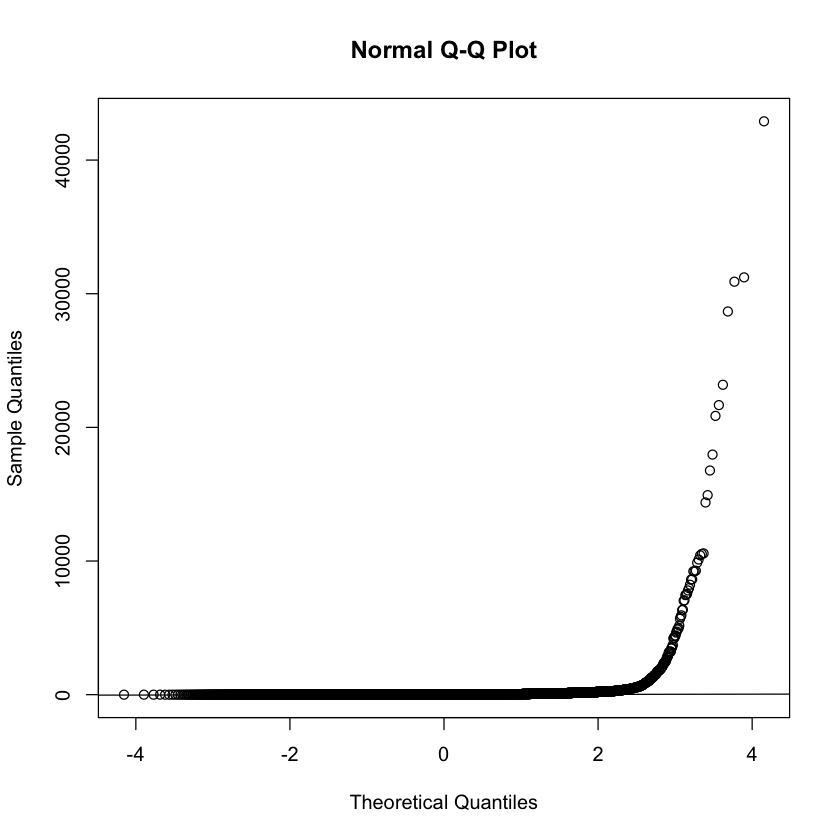

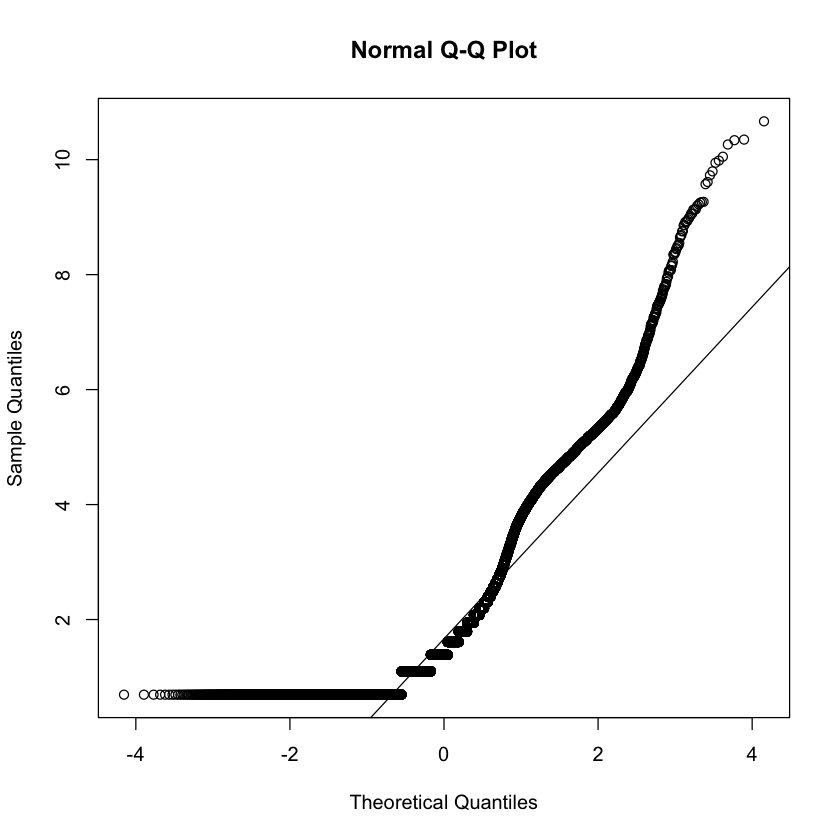

In [38]:
# check QQ-Plot
qqnorm(data_nonzero$favorite_count); qqline(data_nonzero$favorite_count)

# check QQ-Plot
qqnorm(data_nonzero$log_favorite_count); qqline(data_nonzero$log_favorite_count) 

In [39]:
# check if y variable follows Poisson distribution
# test results indicate y variable doesn't follow Poisson distribution
fav_fit1 <- goodfit(data_nonzero$favorite_count, type="poisson")
summary(fav_fit1)


	 Goodness-of-fit test for poisson distribution

                 X^2  df P(> X^2)
Likelihood Ratio Inf 596        0


**2) word_count (x variable)**

In [40]:
# basic summary of word_count
summary(data_nonzero$word_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   19.00   25.00   27.34   36.00   66.00 

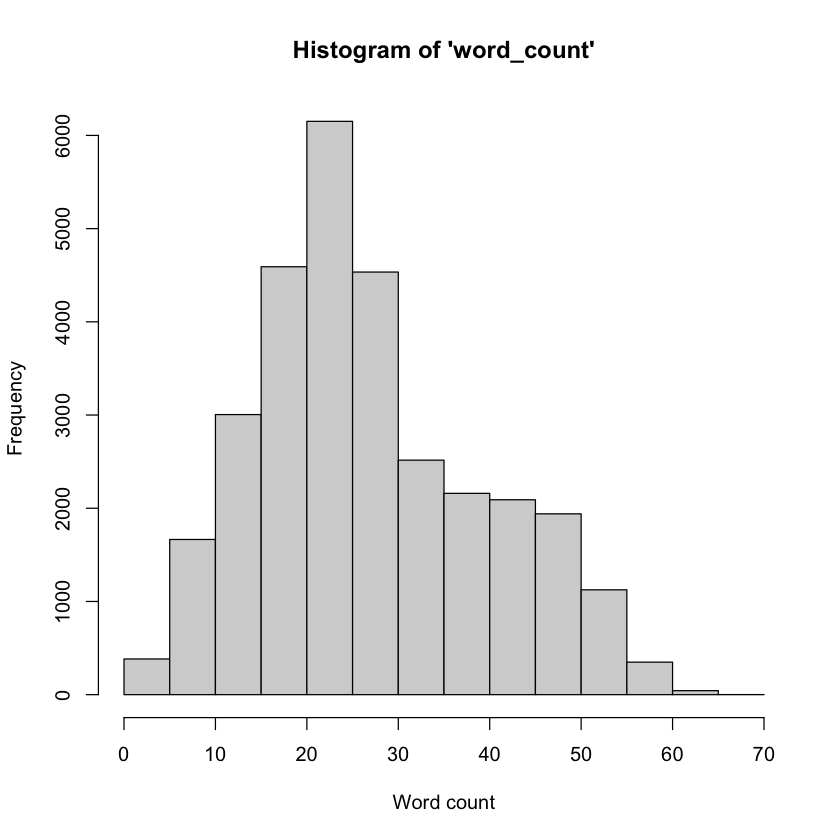

In [41]:
# check the histogram of the predictor variable 'word_count'
# word count is slightly right skewed
hist(data_nonzero$word_count,
     xlab = "Word count",
     ylab = "Frequency",
     main = "Histogram of 'word_count'")

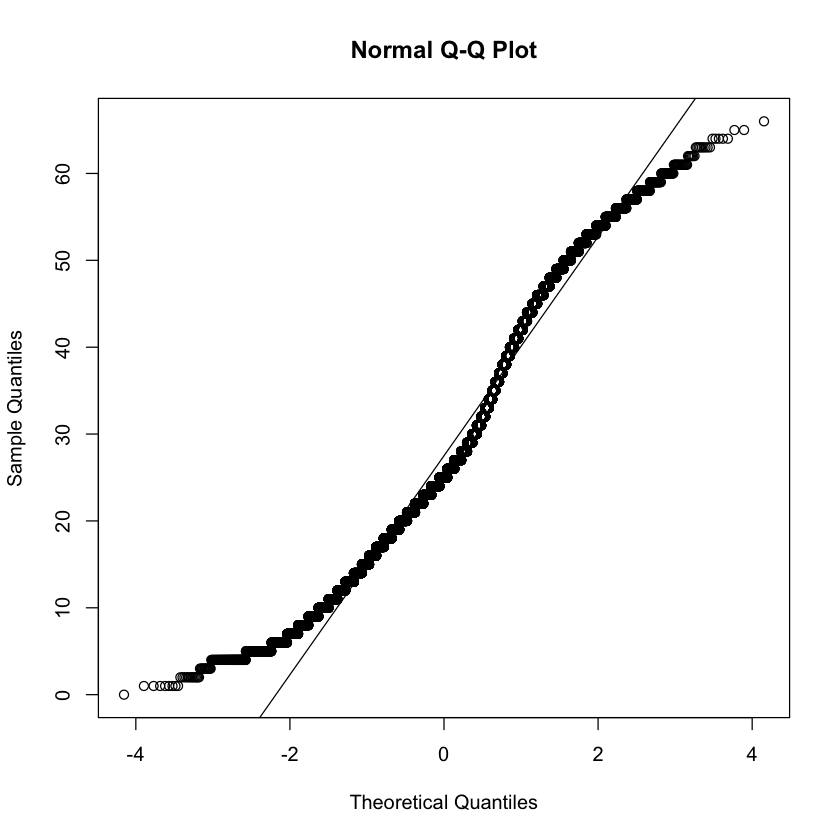

In [42]:
# check QQ-Plot
qqnorm(data_nonzero$word_count); qqline(data_nonzero$word_count)

**3) syuzhet  (x variable)**

In [43]:
# basic summary of syuzhet 
summary(data_nonzero$syuzhet)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -4.250   0.000   0.800   0.994   1.600   8.650 

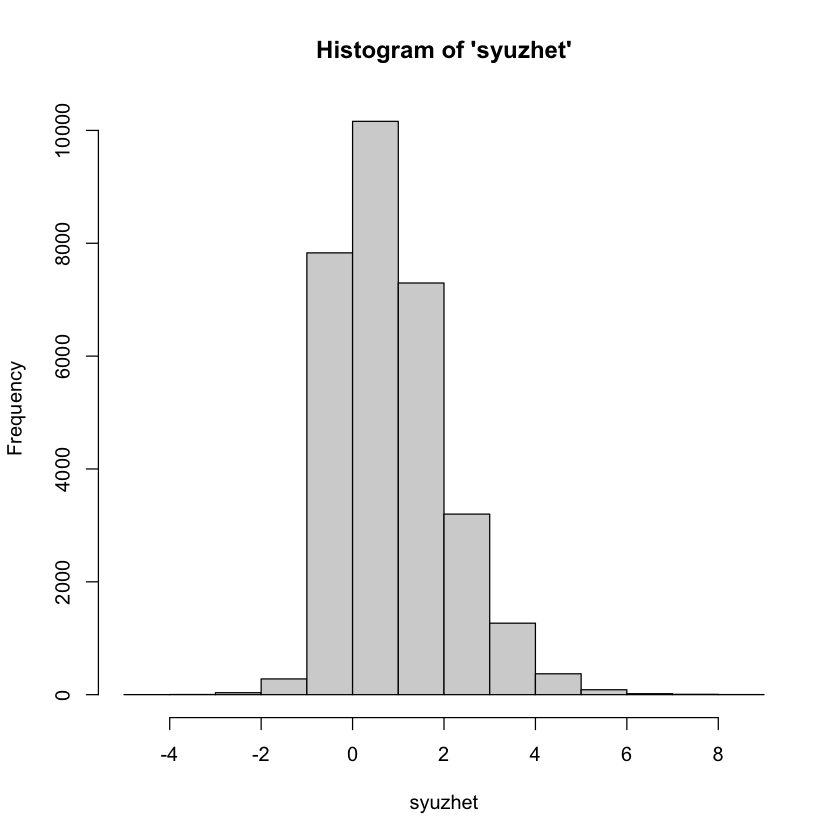

In [44]:
# check the histogram of the predictor variable 'syuzhet'
# syuzhet is slightly right skewed
hist(data_nonzero$syuzhet,
     xlab = "syuzhet",
     ylab = "Frequency",
     main = "Histogram of 'syuzhet'")

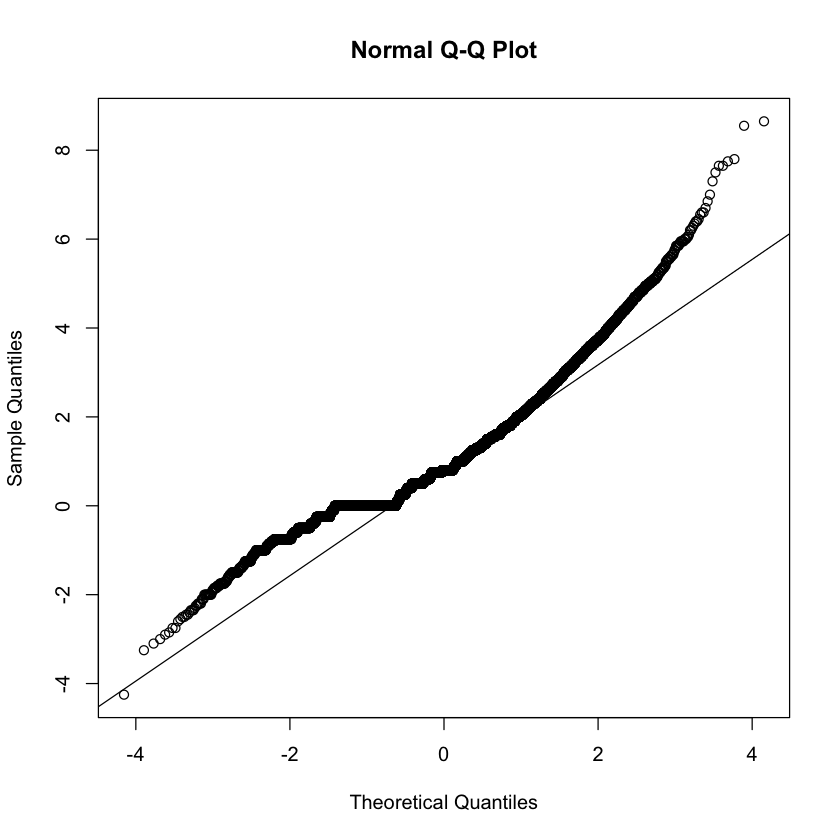

In [45]:
# check QQ-Plot
qqnorm(data_nonzero$syuzhet); qqline(data_nonzero$syuzhet)

**4) visual_presence  (x variable)**

In [46]:
# basic summary of visual_presence 
table(data_nonzero$visual_presence)


    1     0 
23068  7486 

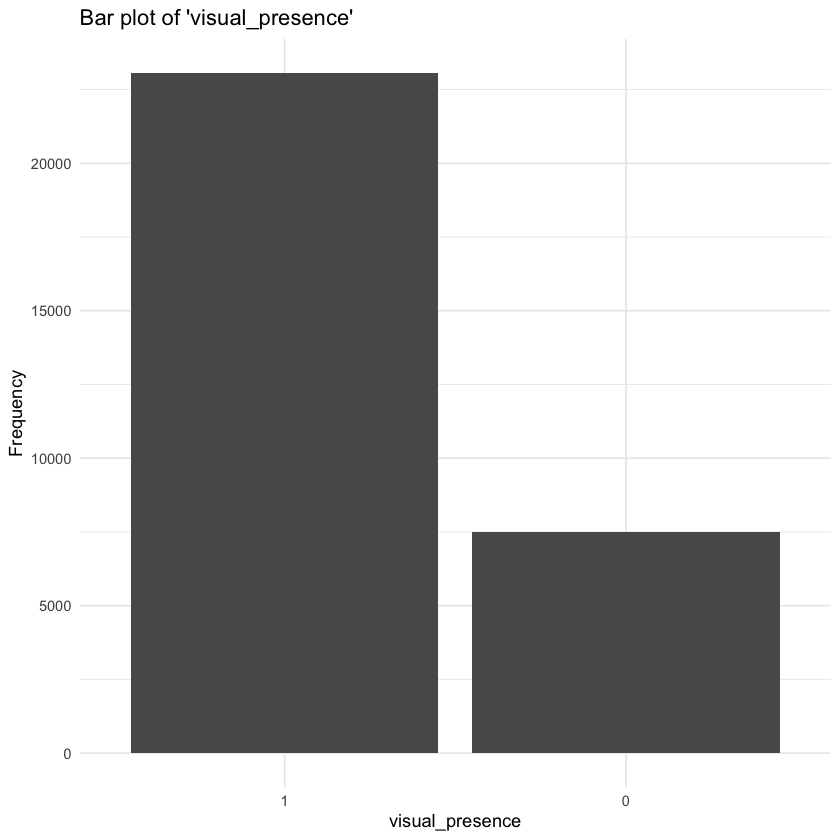

In [47]:
# bar plot - visual_presence
ggplot(data_nonzero, aes(visual_presence)) + 
  geom_bar() +
  labs(x = "visual_presence", y = "Frequency", title = "Bar plot of 'visual_presence'") +
  theme_minimal()

Here, although we excluded 0 values in the y variable, the distribution does not seem to have changed much, but using log-transformed y variable gives better distribution than original data set. <br>
The visual_presence graph changed quite a bit with 0 value dropped down, meaning most of data points with y variable of 0 must have not contained images as much. <br>
So, y variable without 0 makes the histogram slightly less skewed and shows that visual_presence might be meaningful, but besides that, there seems to be not much difference

### C. 'recent_data'

**1.1) favorite_count (y variable)**

In [48]:
# basic summary of y variable
summary(recent_data$favorite_count)
cat("Mean of favorite_count:", mean(recent_data$favorite_count), "\n")
cat("Variance of favorite_count:", var(recent_data$favorite_count))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      0.00      2.00     96.55     12.00 122252.00 

Mean of favorite_count: 96.54751 
Variance of favorite_count: 4617594

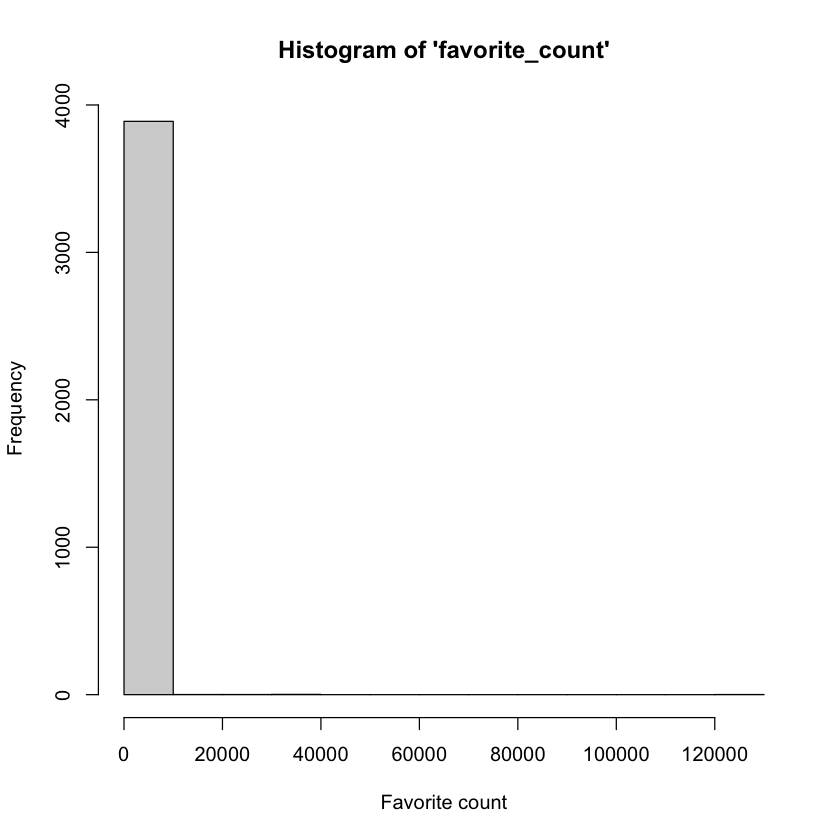

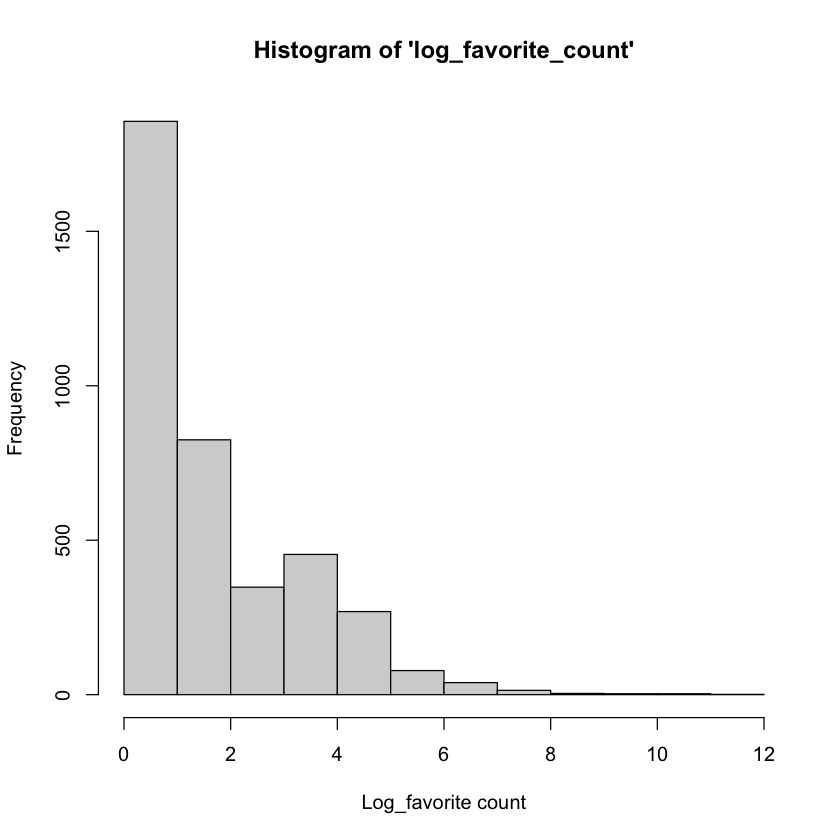

In [49]:
# check the histogram of the response variable 'favorite_count'
hist(recent_data$favorite_count, 
     xlab = "Favorite count",
     ylab = "Frequency",
     main = "Histogram of 'favorite_count'")

# check the histogram of the response variable 'log_favorite_count'
hist(recent_data$log_favorite_count, 
     xlab = "Log_favorite count",
     ylab = "Frequency",
     main = "Histogram of 'log_favorite_count'")

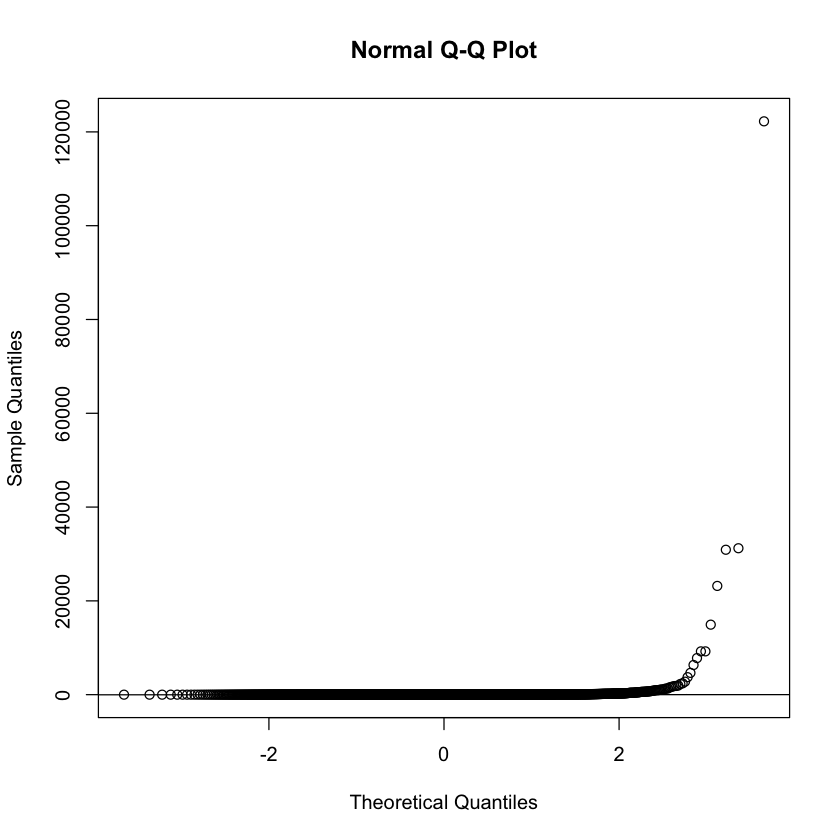

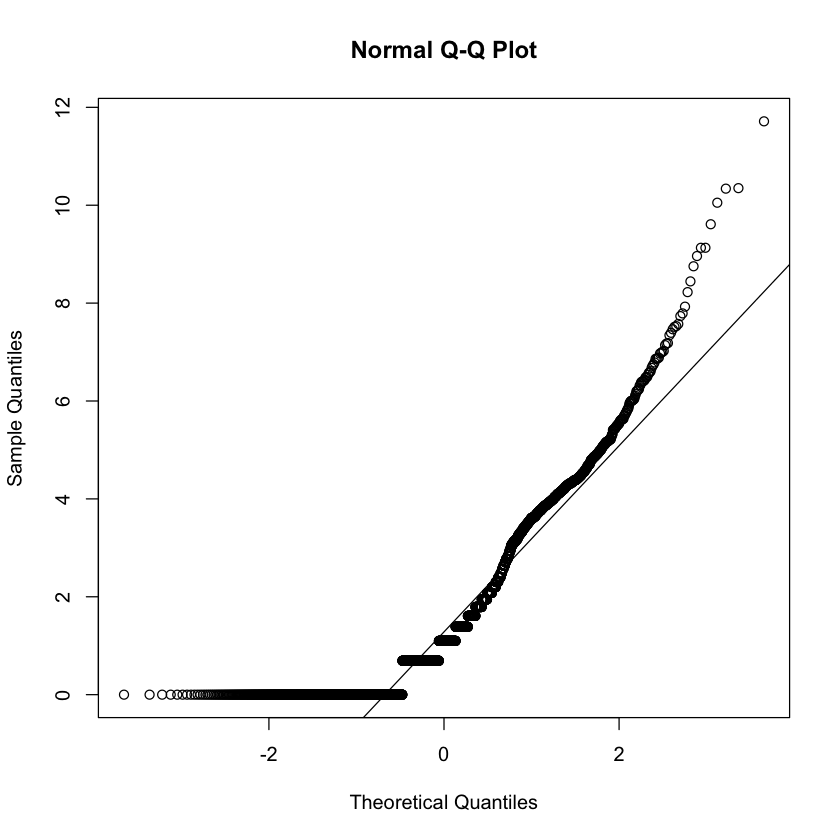

In [50]:
# check QQ-Plot
qqnorm(recent_data$favorite_count); qqline(recent_data$favorite_count)

# check QQ-Plot
qqnorm(recent_data$log_favorite_count); qqline(recent_data$log_favorite_count)

In [51]:
# check if y variable follows Poisson distribution
# test results indicate y variable doesn't follow Poisson distribution
fav_fit2 <- goodfit(recent_data$favorite_count, type="poisson")
summary(fav_fit2)


	 Goodness-of-fit test for poisson distribution

                 X^2  df P(> X^2)
Likelihood Ratio Inf 258        0


**1.2) scaled_norm_fav (y variable)**

In [52]:
# basic summary of y variable
summary(recent_data$scaled_norm_fav)
cat("Mean of scaled_norm_fav:", mean(recent_data$scaled_norm_fav), "\n")
cat("Variance of scaled_norm_fav:", var(recent_data$scaled_norm_fav))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.0000   0.0000   0.9438   1.0000 500.0000 

Mean of scaled_norm_fav: 0.9437596 
Variance of scaled_norm_fav: 80.60896

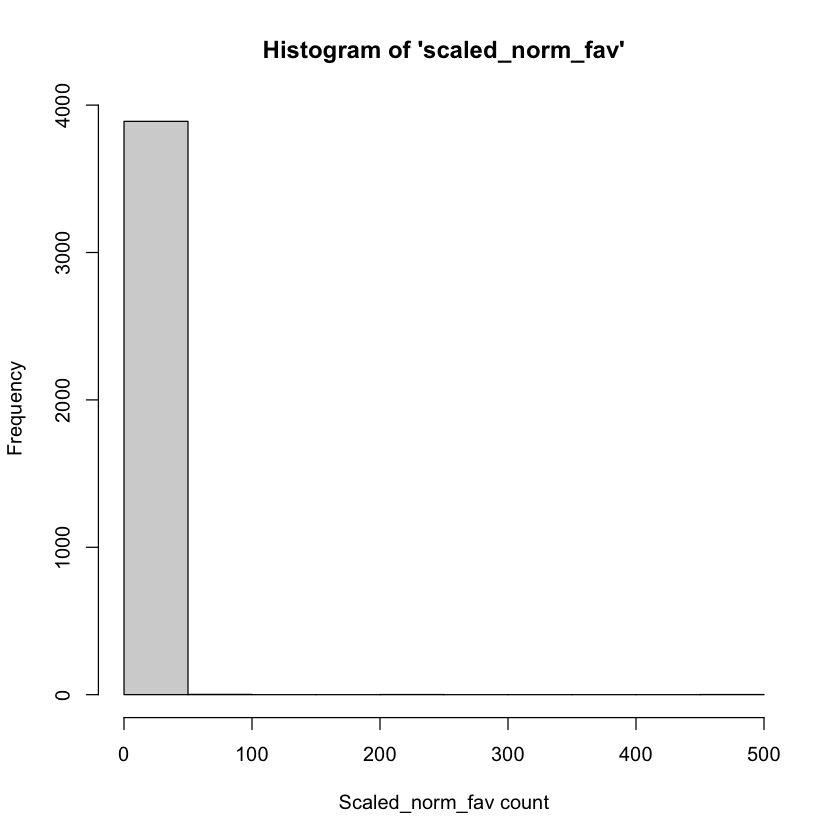

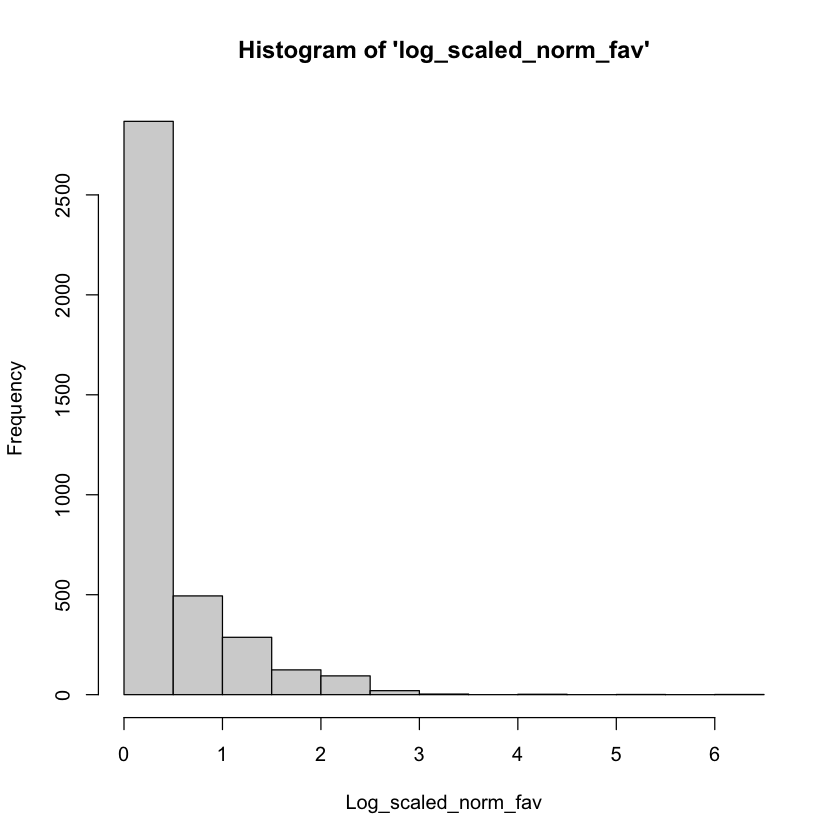

In [53]:
# check the histogram of the response variable 'scaled_norm_fav'
hist(recent_data$scaled_norm_fav, 
     xlab = "Scaled_norm_fav count",
     ylab = "Frequency",
     main = "Histogram of 'scaled_norm_fav'")

# check the histogram of the response variable 'log_scaled_norm_fav'
hist(recent_data$log_scaled_norm_fav, 
     xlab = "Log_scaled_norm_fav",
     ylab = "Frequency",
     main = "Histogram of 'log_scaled_norm_fav'")

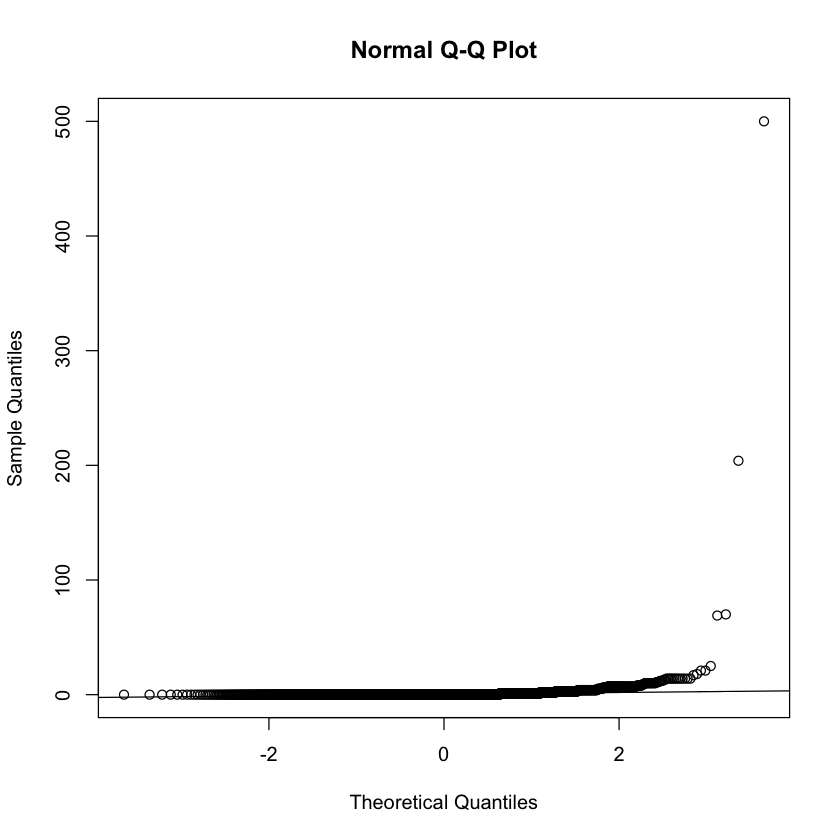

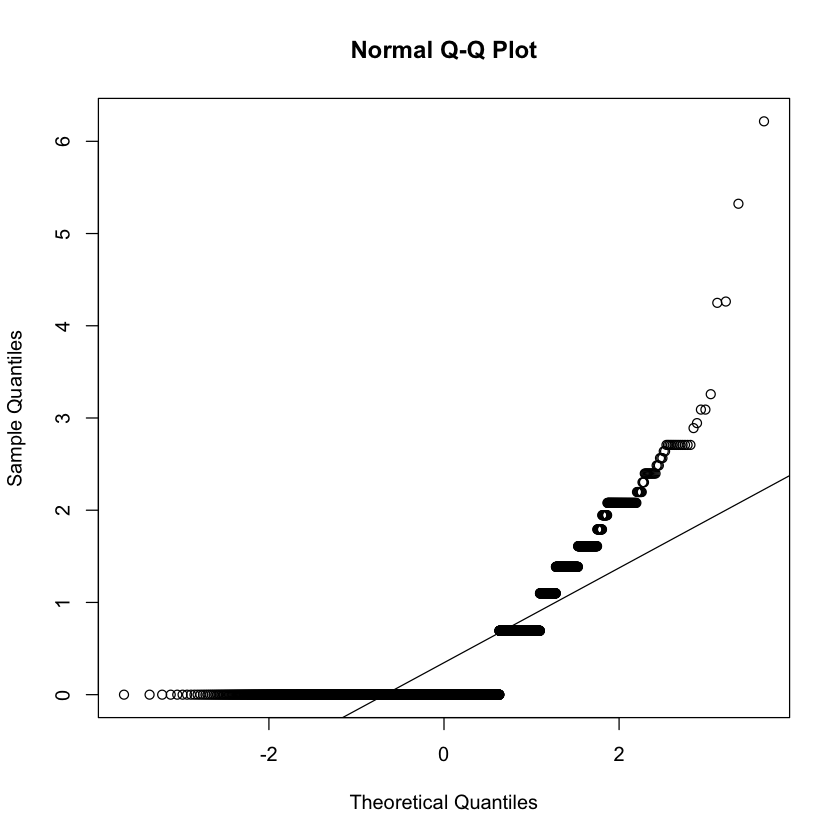

In [54]:
# check QQ-Plot
qqnorm(recent_data$scaled_norm_fav); qqline(recent_data$scaled_norm_fav)

# check QQ-Plot
qqnorm(recent_data$log_scaled_norm_fav); qqline(recent_data$log_scaled_norm_fav)

**2) word_count (x variable)**

In [55]:
# basic summary of word_count
summary(recent_data$word_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   18.00   29.00   29.49   41.00   89.00 

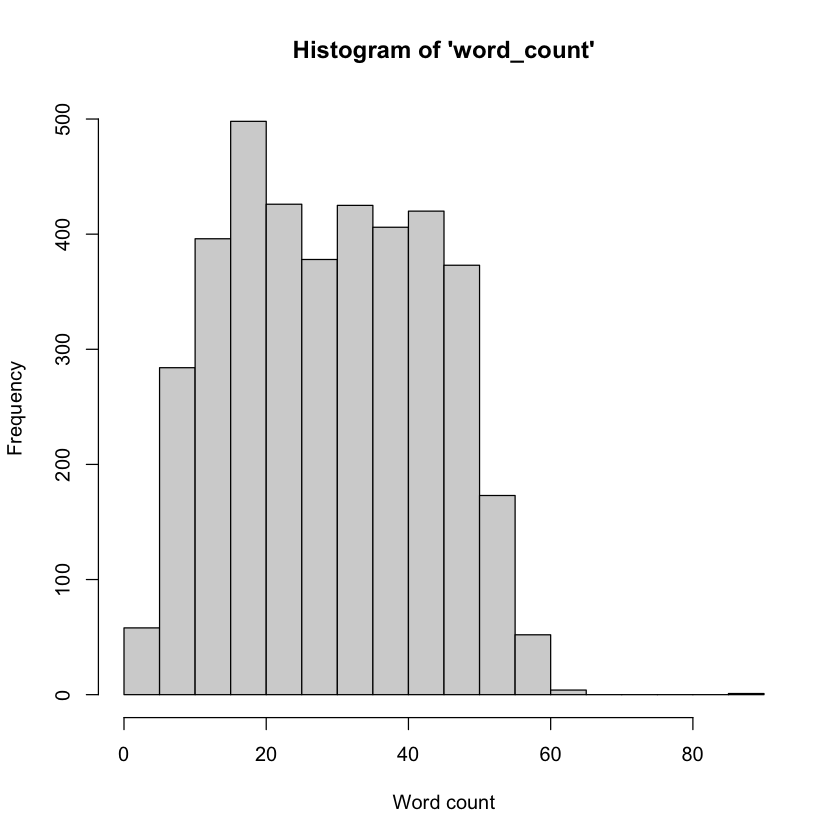

In [56]:
# check the histogram of the predictor variable 'word_count'
# word count is slightly right skewed
hist(recent_data$word_count,
     xlab = "Word count",
     ylab = "Frequency",
     main = "Histogram of 'word_count'")

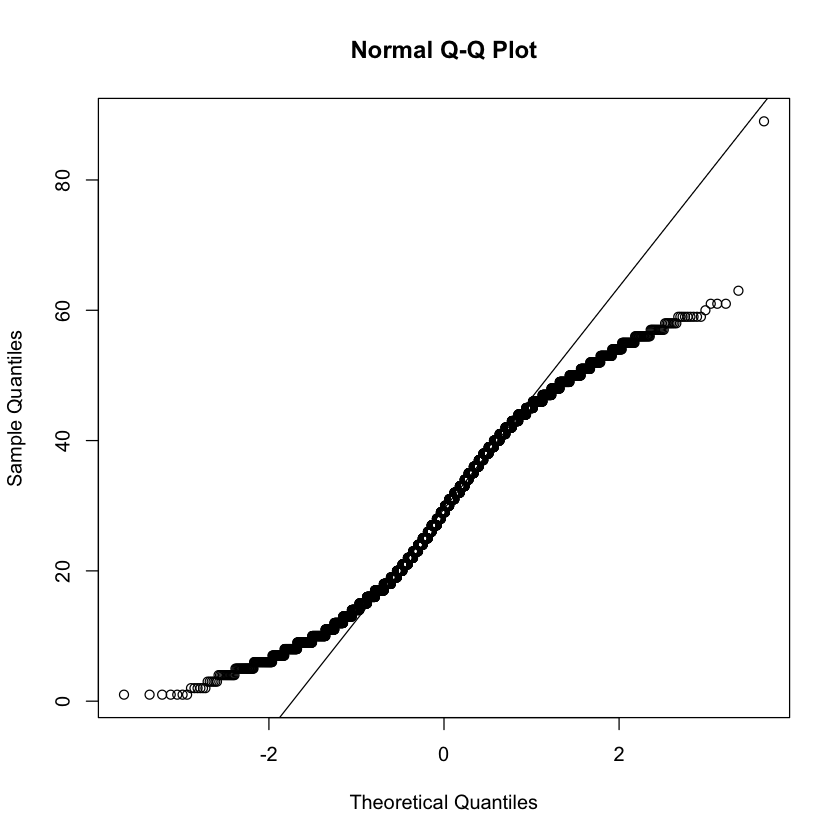

In [57]:
# check QQ-Plot
qqnorm(recent_data$word_count); qqline(recent_data$word_count)

**3) syuzhet  (x variable)**

In [58]:
# basic summary of syuzhet 
summary(recent_data$syuzhet)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.750   0.000   0.800   1.137   1.800   7.000 

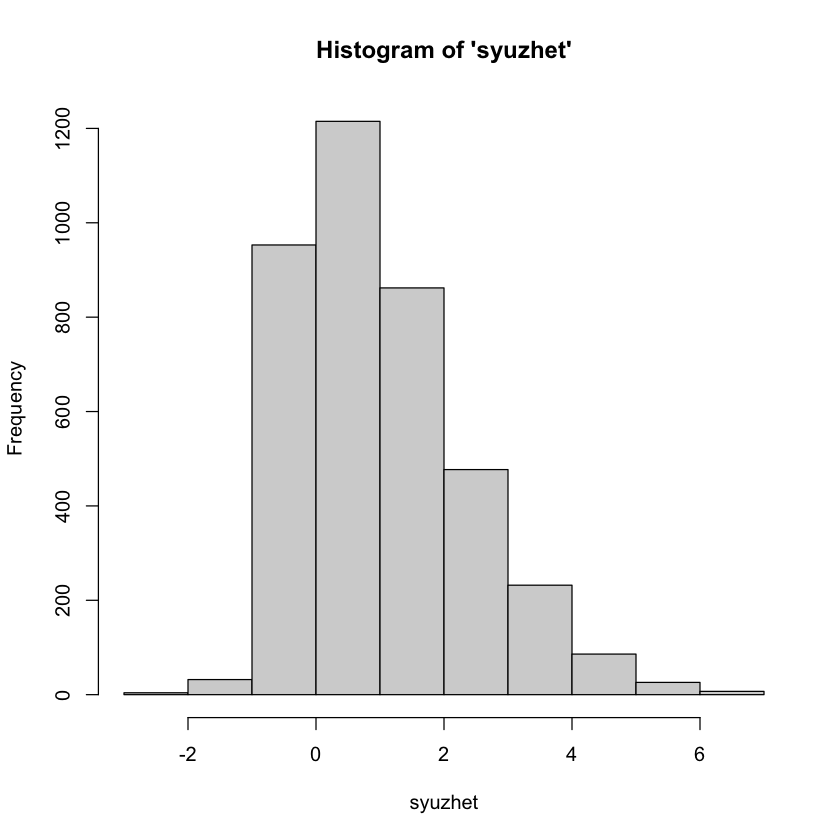

In [59]:
# check the histogram of the predictor variable 'syuzhet'
# syuzhet is slightly right skewed
hist(recent_data$syuzhet,
     xlab = "syuzhet",
     ylab = "Frequency",
     main = "Histogram of 'syuzhet'")

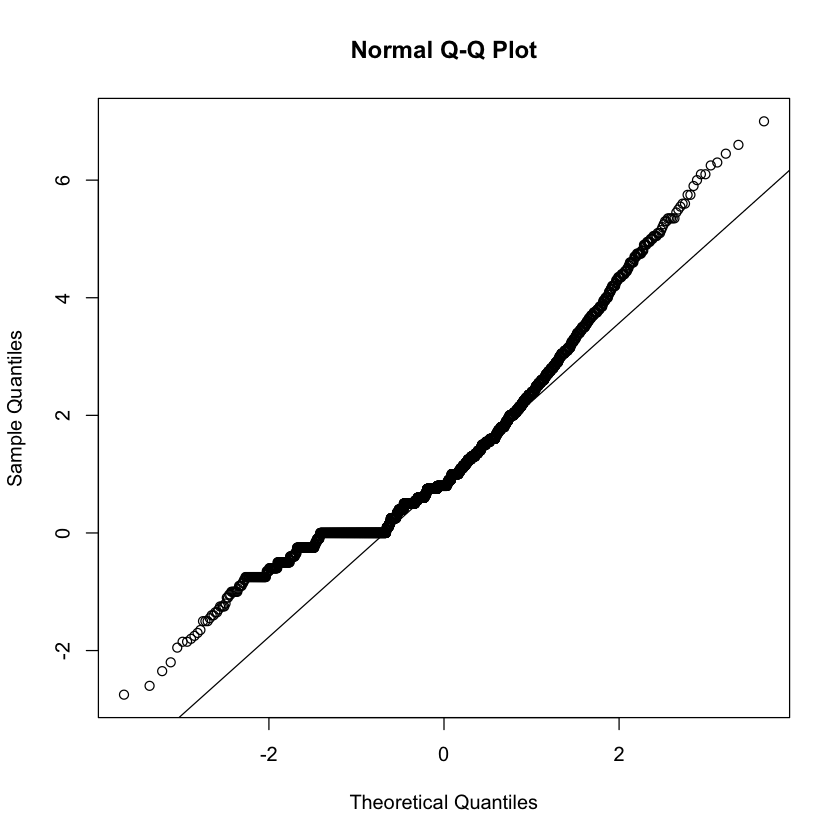

In [60]:
# check QQ-Plot
qqnorm(recent_data$syuzhet); qqline(recent_data$syuzhet)

**4) visual_presence  (x variable)**

In [61]:
# basic summary of visual_presence 
table(recent_data$visual_presence)


   1    0 
2796 1098 

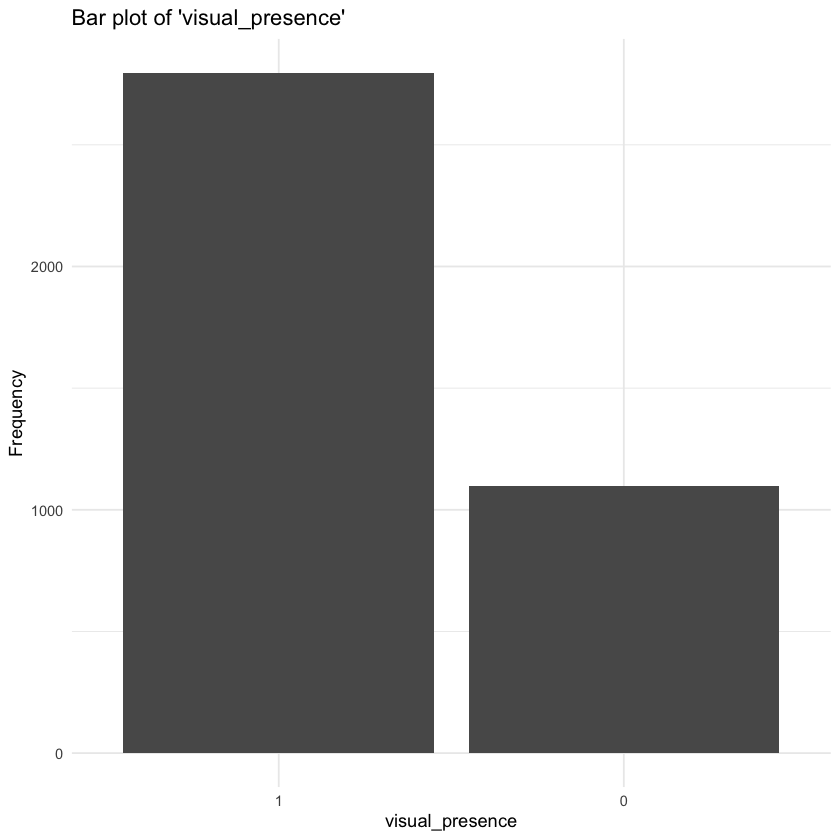

In [62]:
# bar plot - visual_presence
ggplot(recent_data, aes(visual_presence)) + 
  geom_bar() +
  labs(x = "visual_presence", y = "Frequency", title = "Bar plot of 'visual_presence'") +
  theme_minimal()

**5) biz_presence  (x variable)**

In [63]:
# basic summary of biz_presence 
table(recent_data$biz_presence)
summary(recent_data$favorite_count[recent_data$biz_presence==1])
summary(recent_data$favorite_count[recent_data$biz_presence==0])


   1    0 
1966 1928 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      0.00      1.00     84.24      8.00 122252.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     2.0   109.1    20.0 31224.0 

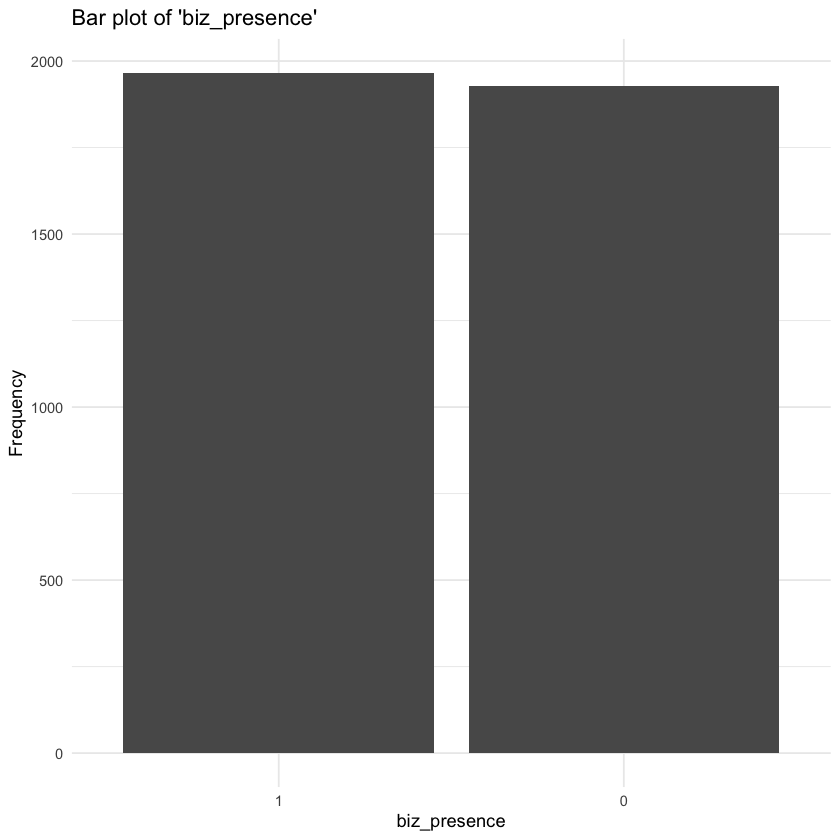

In [64]:
# bar plot - biz_presence
ggplot(recent_data, aes(biz_presence)) + 
  geom_bar() +
  labs(x = "biz_presence", y = "Frequency", title = "Bar plot of 'biz_presence'") +
  theme_minimal()

**6) eco_presence  (x variable)**

In [65]:
# basic summary of eco_presence 
table(recent_data$eco_presence)
summary(recent_data$favorite_count[recent_data$eco_presence==1])
summary(recent_data$favorite_count[recent_data$eco_presence==0])


   1    0 
1059 2835 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0      0.0      1.0    153.8      6.0 122252.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     2.00    75.16    16.50 31224.00 

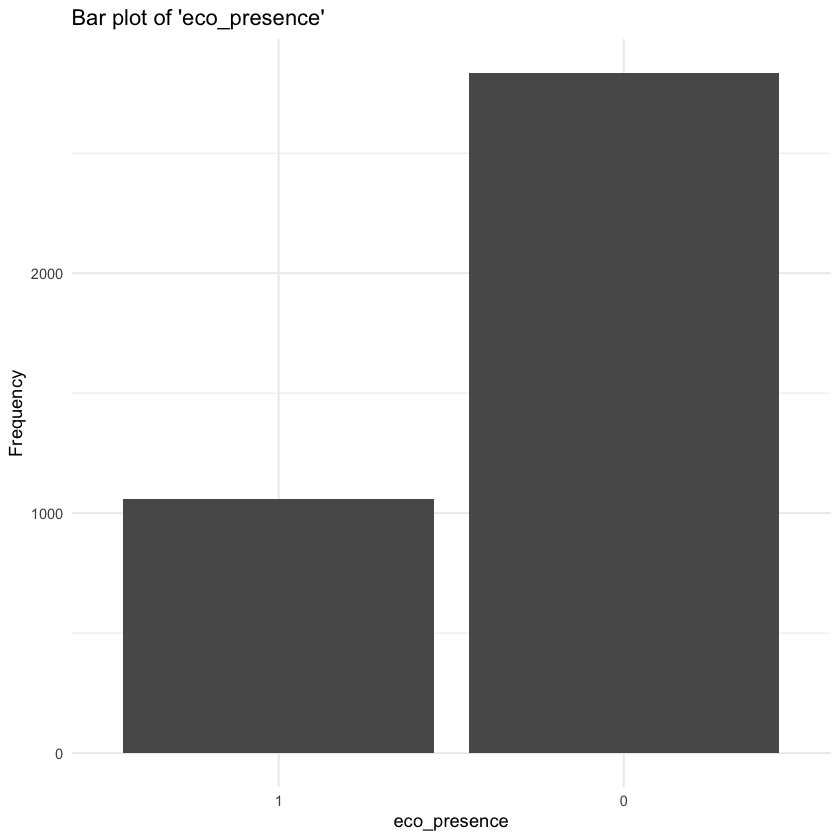

In [66]:
# bar plot - eco_presence
ggplot(recent_data, aes(eco_presence)) + 
  geom_bar() +
  labs(x = "eco_presence", y = "Frequency", title = "Bar plot of 'eco_presence'") +
  theme_minimal()

In recent data, we used scaled_norm_fav, but the distribution did not seem to change much though


### 2-2. Linearity 

### A. original data

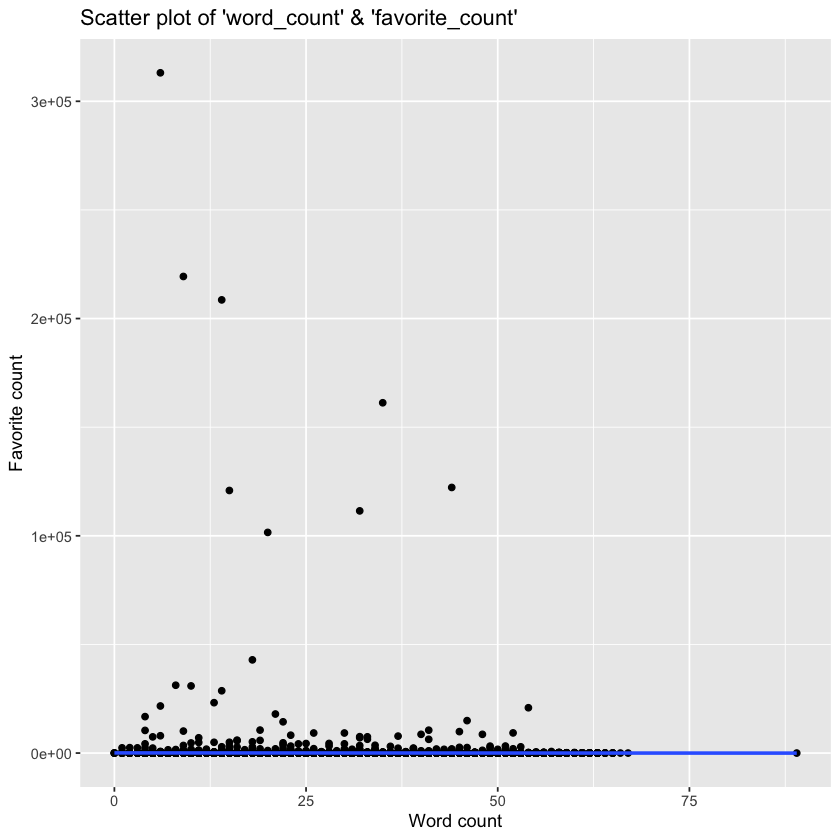

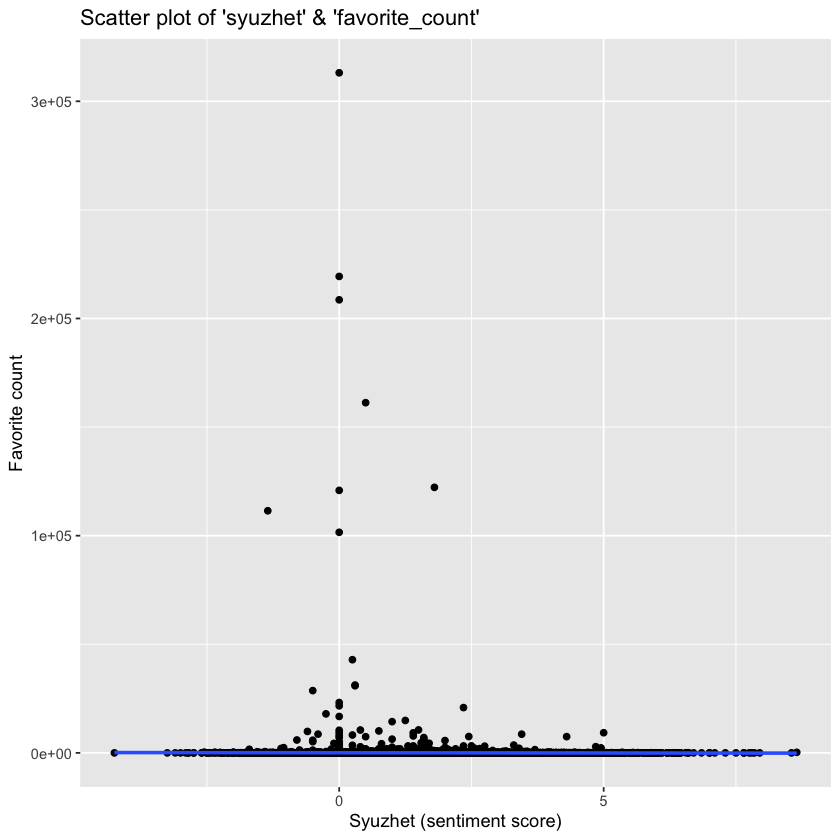

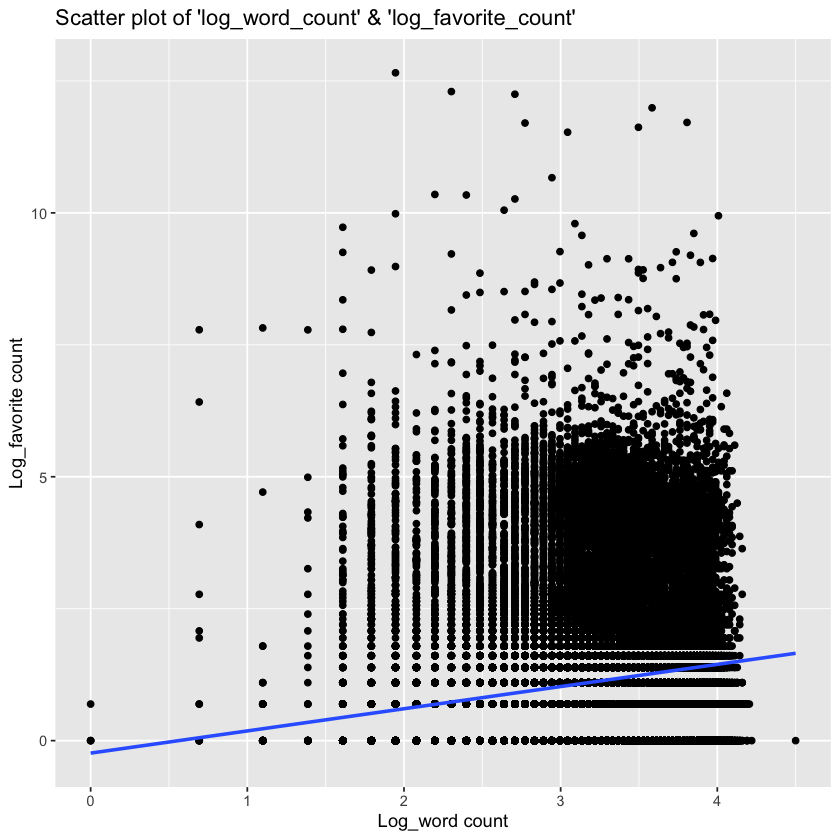

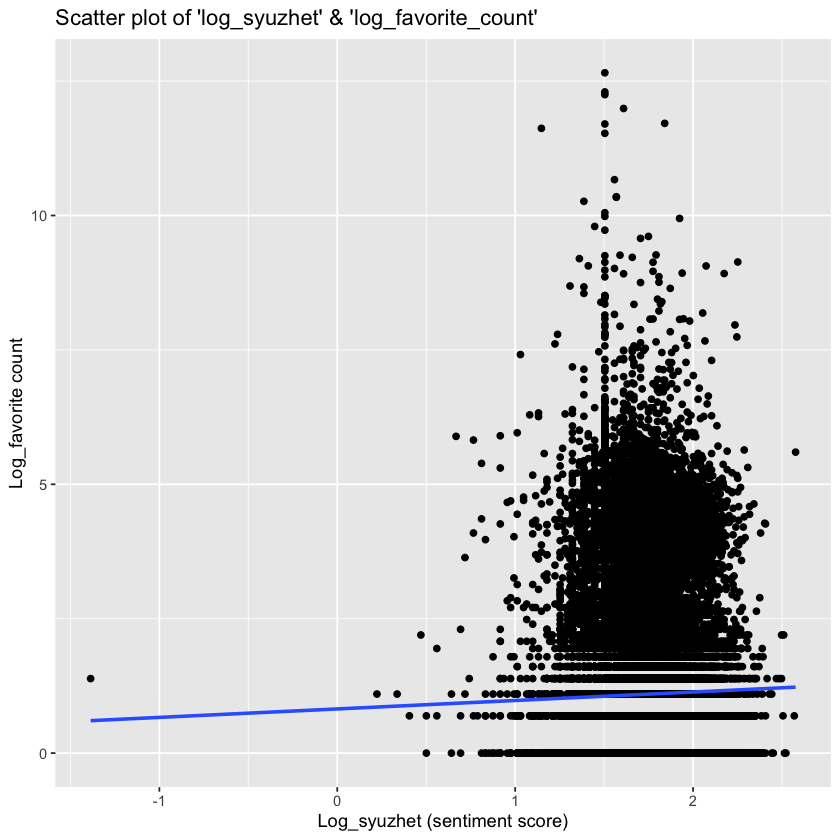

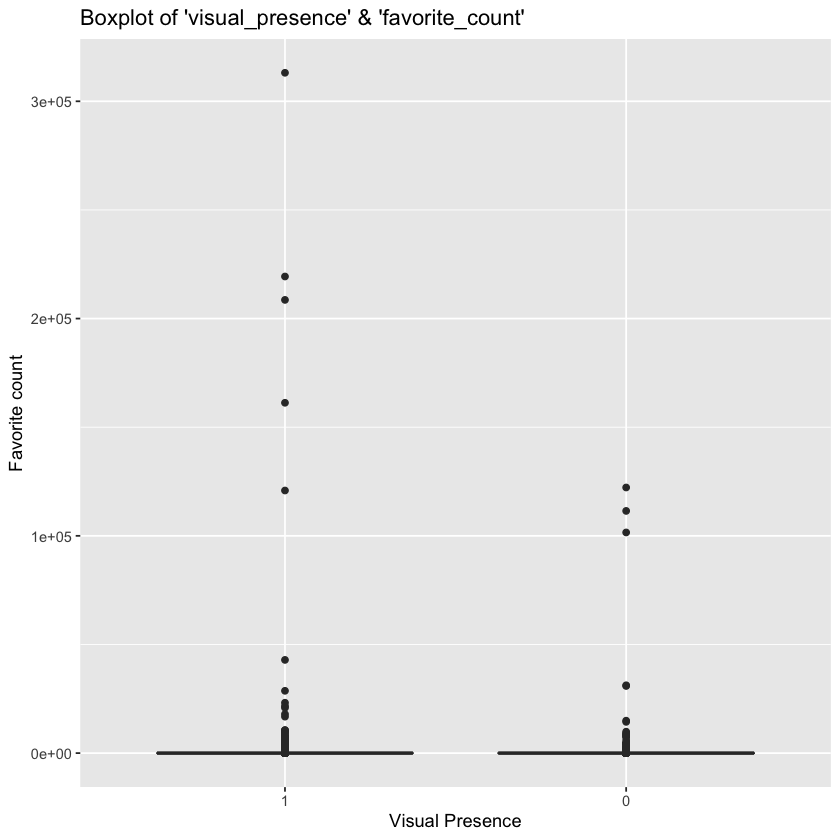

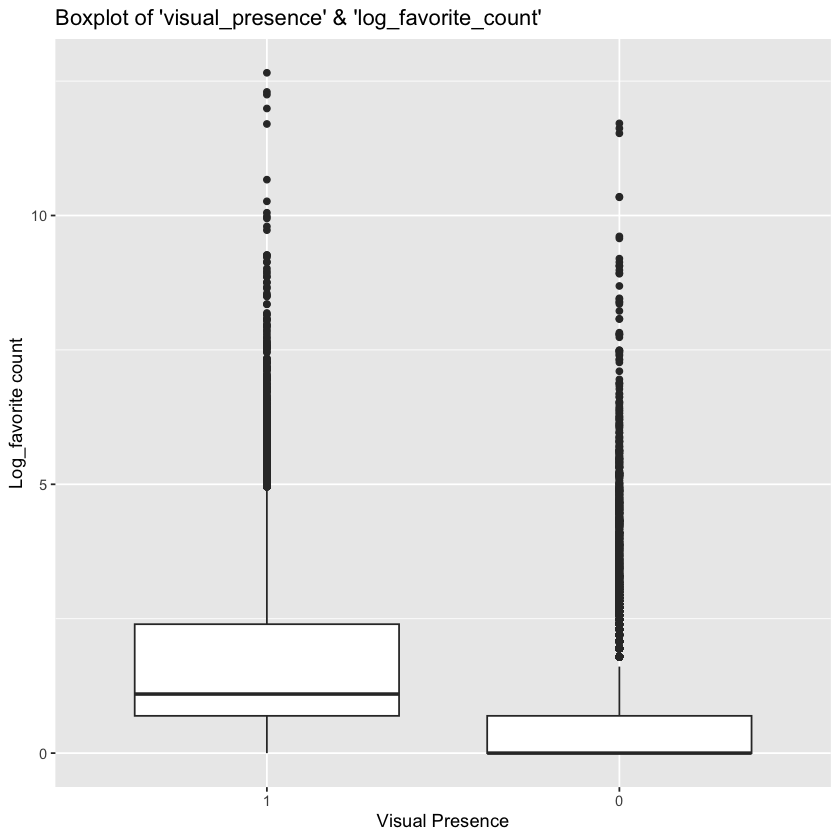

In [67]:
# scatter plot: word_count vs favorite_count
ggplot(data, aes(x=word_count, y=favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Word count", y = "Favorite count", title = "Scatter plot of 'word_count' & 'favorite_count'")

# scatter plot: syuzhet vs favorite_count
ggplot(data, aes(x=syuzhet, y=favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Syuzhet (sentiment score)", y = "Favorite count", title = "Scatter plot of 'syuzhet' & 'favorite_count'")

# scatter plot: log_word_count vs log_favorite_count
ggplot(data, aes(x=log_word_count, y=log_favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Log_word count", y = "Log_favorite count", title = "Scatter plot of 'log_word_count' & 'log_favorite_count'")

# scatter plot: log_syuzhet vs log_favorite_count
ggplot(data, aes(x=log_syuzhet, y=log_favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Log_syuzhet (sentiment score)", y = "Log_favorite count", title = "Scatter plot of 'log_syuzhet' & 'log_favorite_count'")

# Boxplot: visual_presence vs favorite_count
ggplot(data, aes(x=visual_presence, y=favorite_count)) + 
  geom_boxplot(aes(group = visual_presence)) + 
  labs(x = "Visual Presence", y = "Favorite count", title = "Boxplot of 'visual_presence' & 'favorite_count'")

# Boxplot: visual_presence vs log_favorite_count
ggplot(data, aes(x=visual_presence, y=log_favorite_count)) + 
  geom_boxplot(aes(group = visual_presence)) + 
  labs(x = "Visual Presence", y = "Log_favorite count", title = "Boxplot of 'visual_presence' & 'log_favorite_count'")

By doing simple linearity check up before actual modelings, We can expect that using transformed variables might result better. <br>
Although visual_presence seems to have some relationship with y variable, other predictor variables do not seem to show much of relationship.

### B. 'data_nonzero'

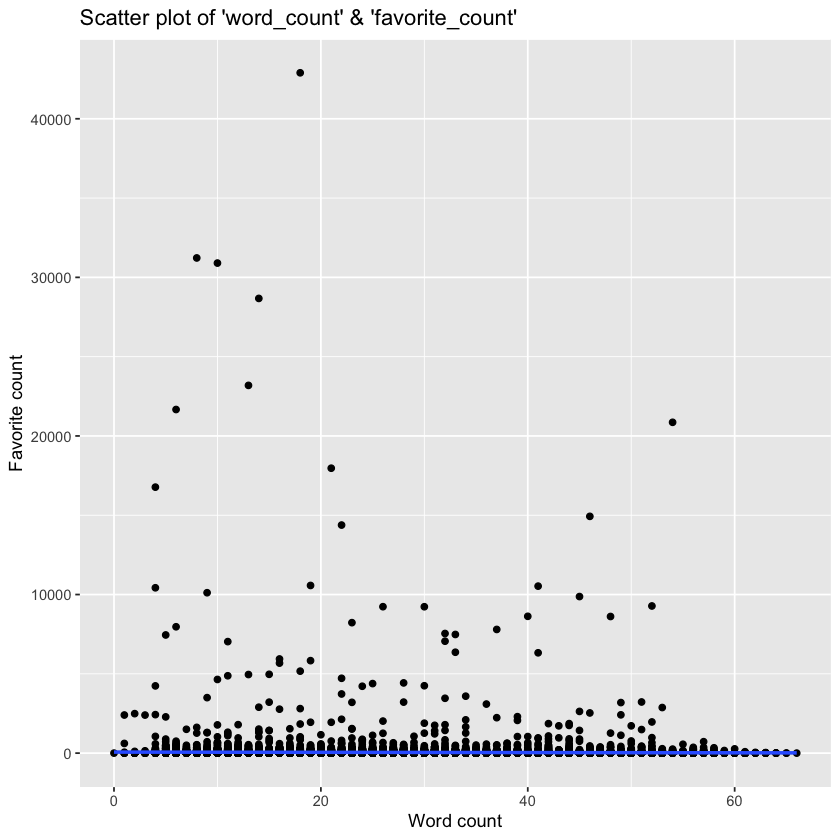

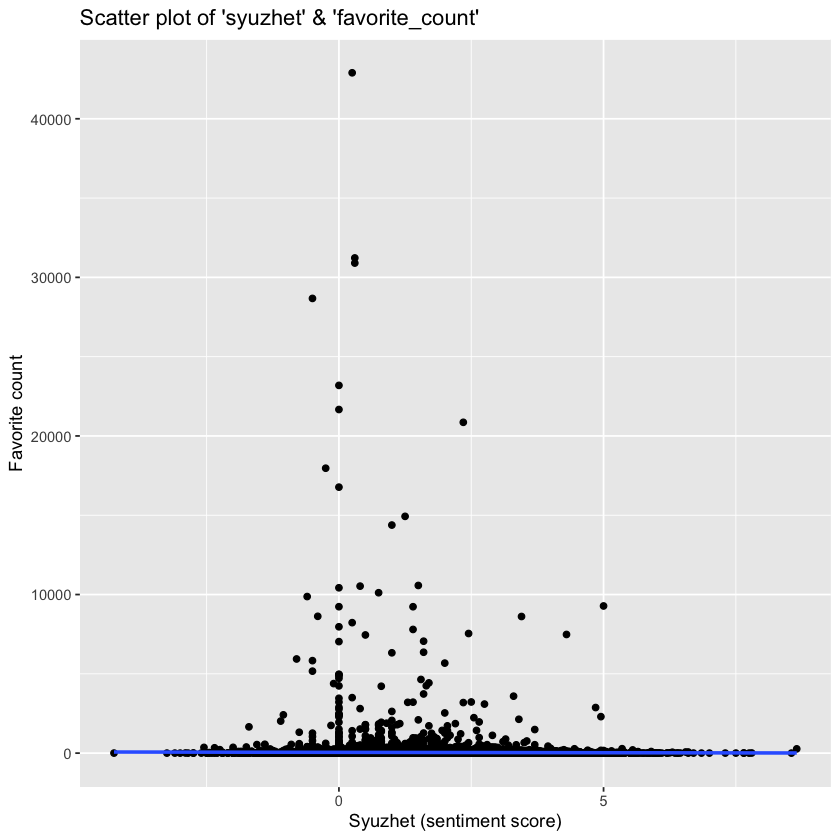

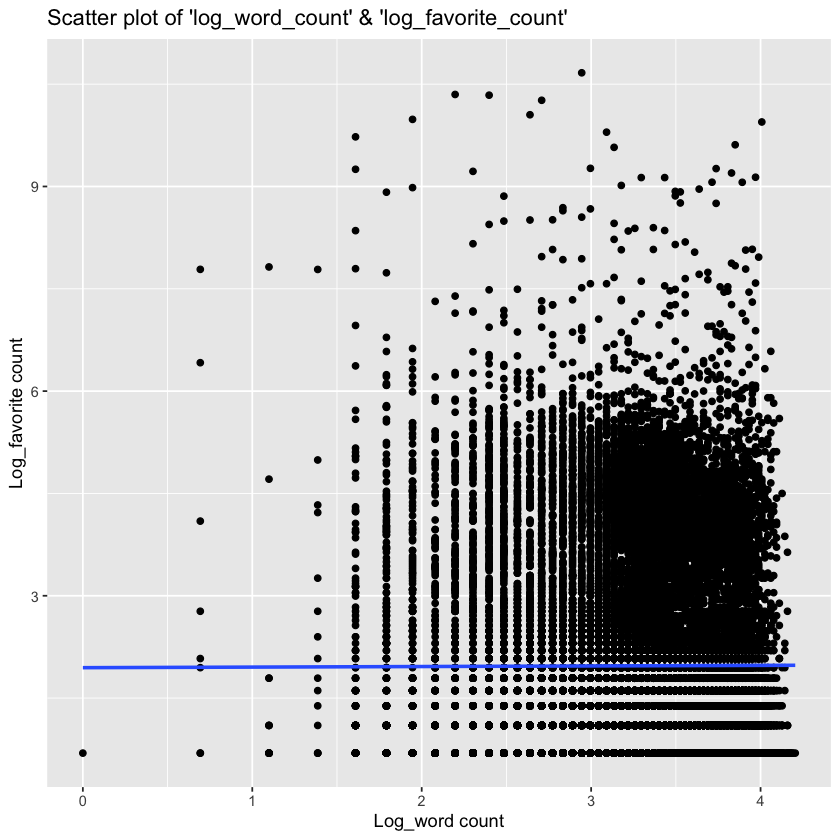

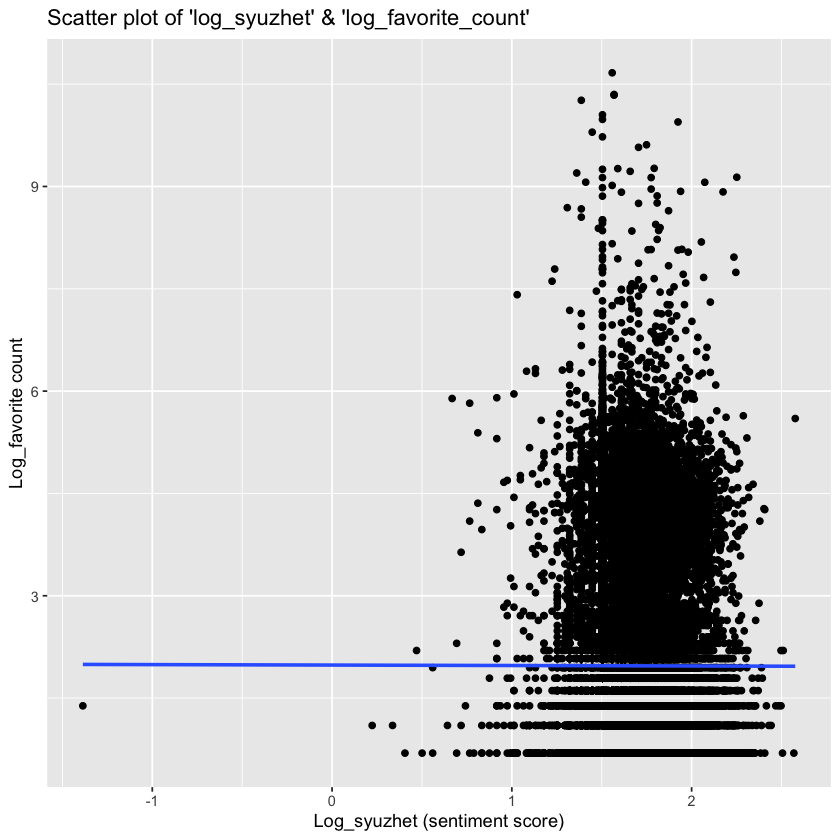

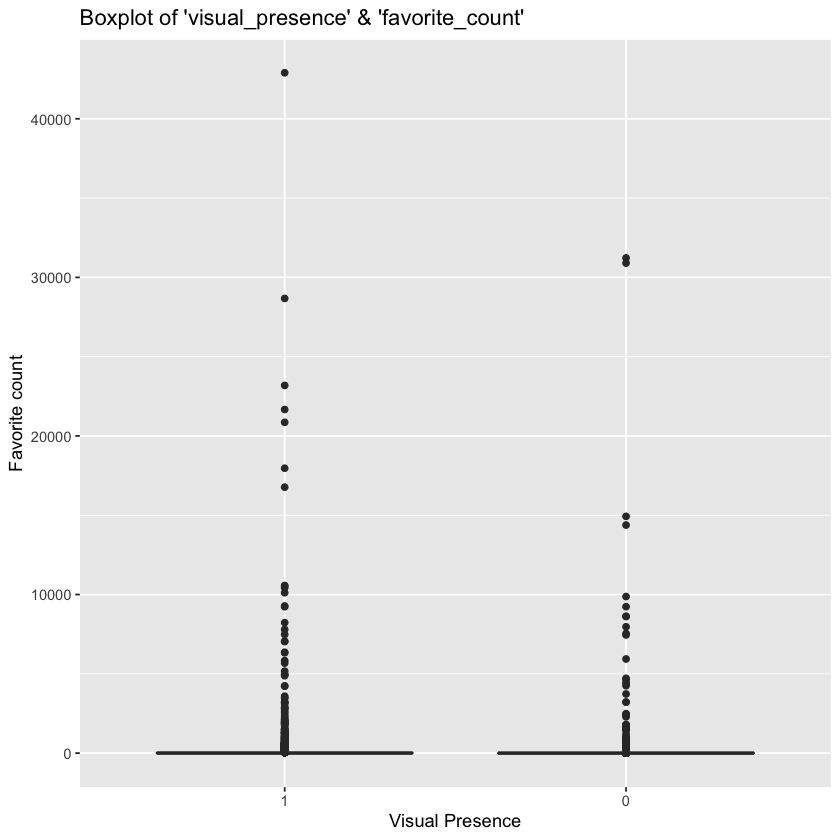

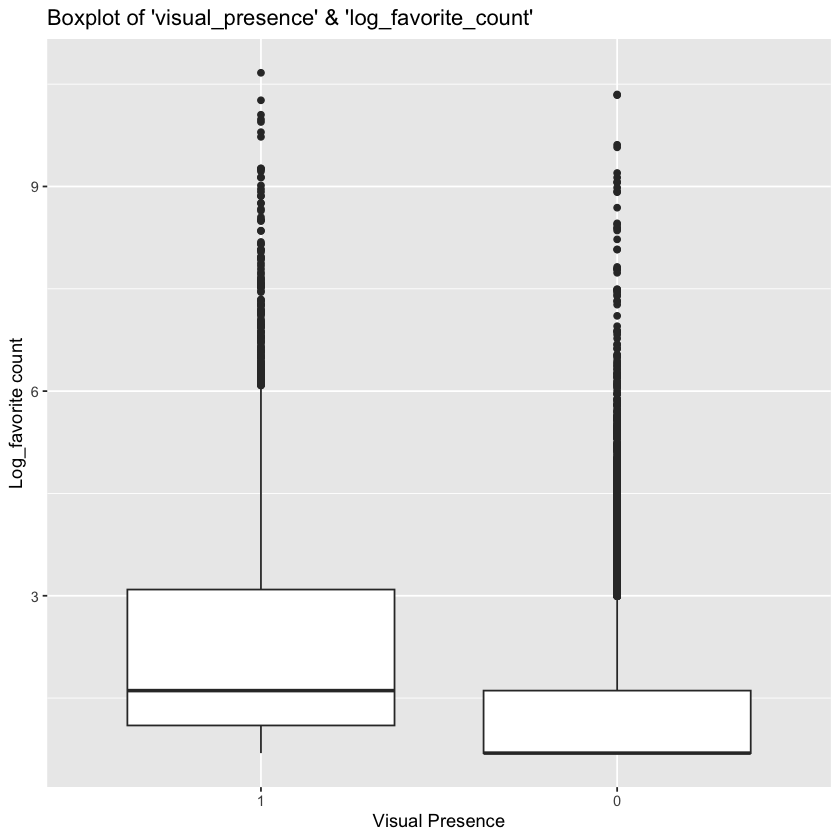

In [68]:
# scatter plot: word_count vs favorite_count
ggplot(data_nonzero, aes(x=word_count, y=favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Word count", y = "Favorite count", title = "Scatter plot of 'word_count' & 'favorite_count'")

# scatter plot: syuzhet vs favorite_count
ggplot(data_nonzero, aes(x=syuzhet, y=favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Syuzhet (sentiment score)", y = "Favorite count", title = "Scatter plot of 'syuzhet' & 'favorite_count'")

# scatter plot: log_word_count vs log_favorite_count
ggplot(data_nonzero, aes(x=log_word_count, y=log_favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Log_word count", y = "Log_favorite count", title = "Scatter plot of 'log_word_count' & 'log_favorite_count'")

# scatter plot: log_syuzhet vs log_favorite_count
ggplot(data_nonzero, aes(x=log_syuzhet, y=log_favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Log_syuzhet (sentiment score)", y = "Log_favorite count", title = "Scatter plot of 'log_syuzhet' & 'log_favorite_count'")

# Boxplot: visual_presence vs favorite_count
ggplot(data_nonzero, aes(x=visual_presence, y=favorite_count)) + 
  geom_boxplot(aes(group = visual_presence)) + 
  labs(x = "Visual Presence", y = "Favorite count", title = "Boxplot of 'visual_presence' & 'favorite_count'")

# Boxplot: visual_presence vs log_favorite_count
ggplot(data_nonzero, aes(x=visual_presence, y=log_favorite_count)) + 
  geom_boxplot(aes(group = visual_presence)) + 
  labs(x = "Visual Presence", y = "Log_favorite count", title = "Boxplot of 'visual_presence' & 'log_favorite_count'")

When it comes to linearity, excluding 0 values in y variable does not make much difference. <br>
Still both word_count, syuzhet do not seem to have much relationship with y variable

### C. 'recent_data'

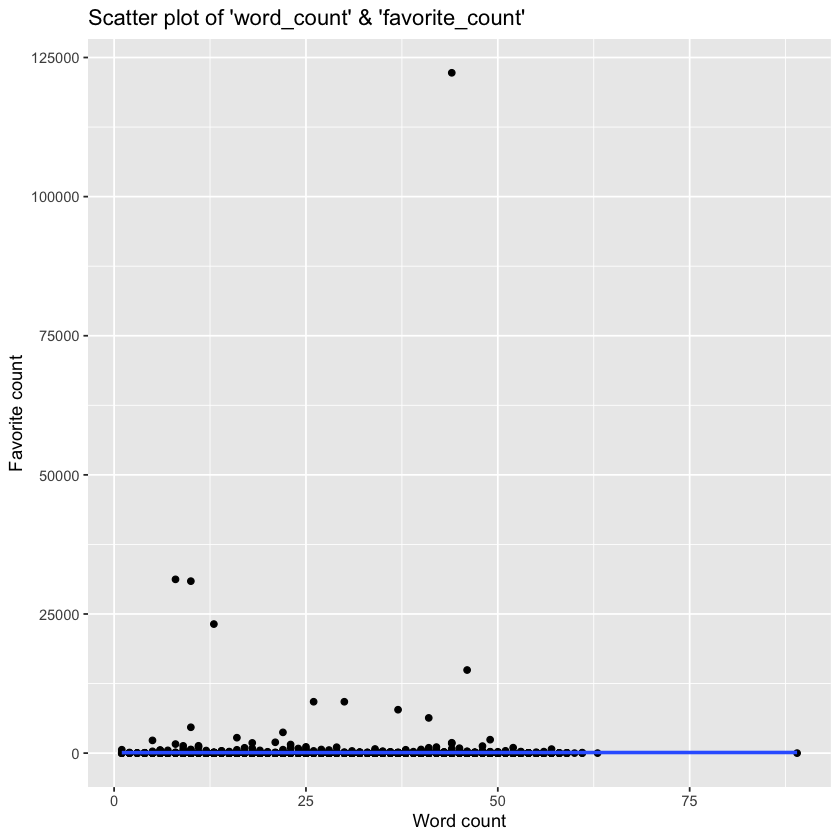

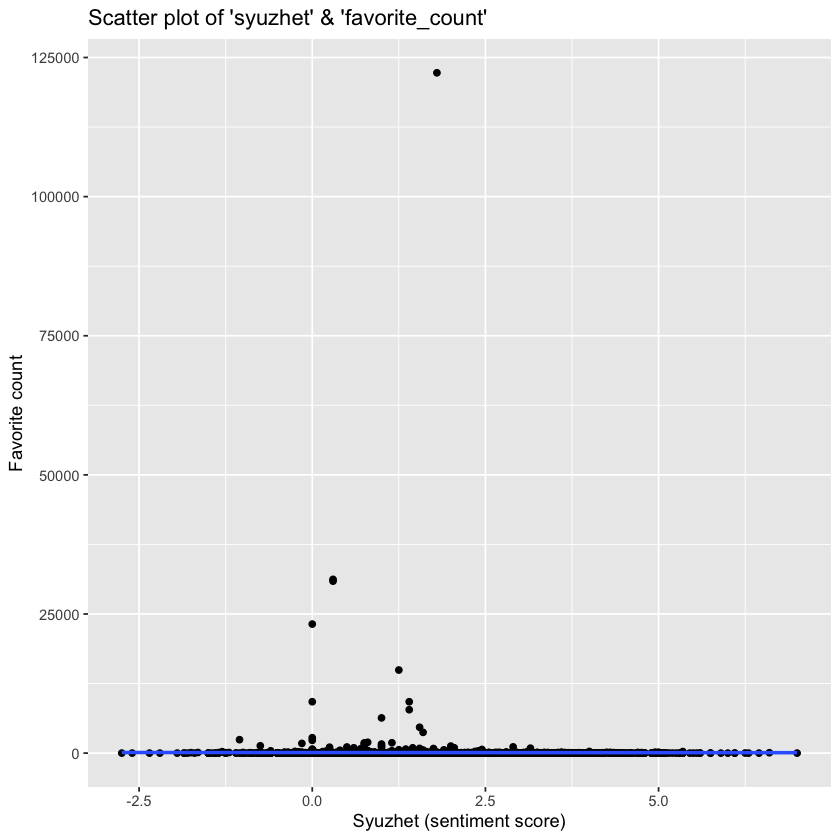

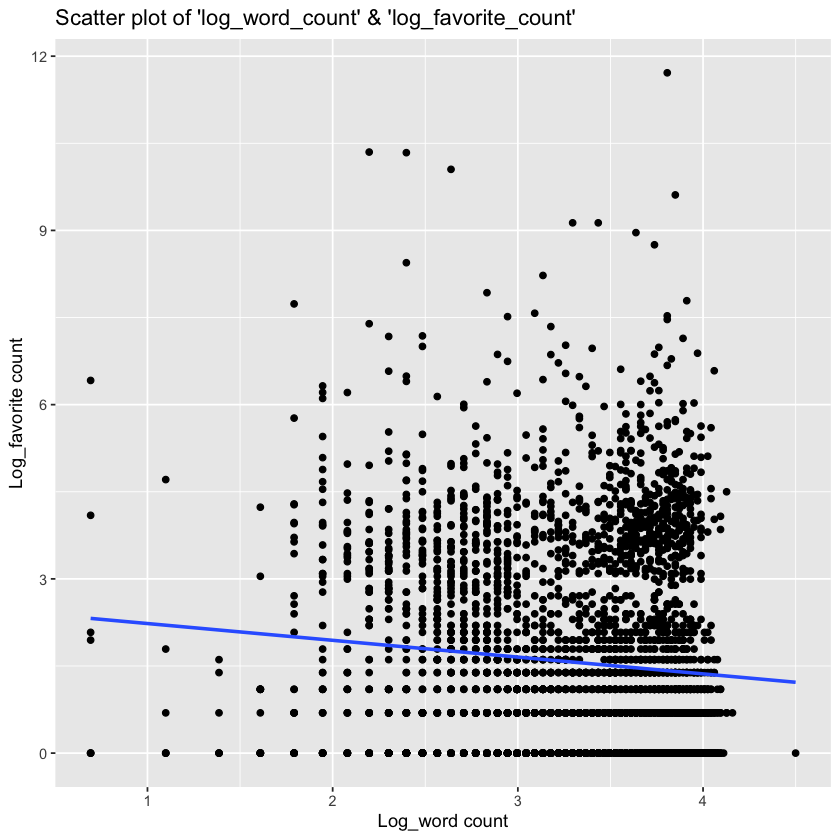

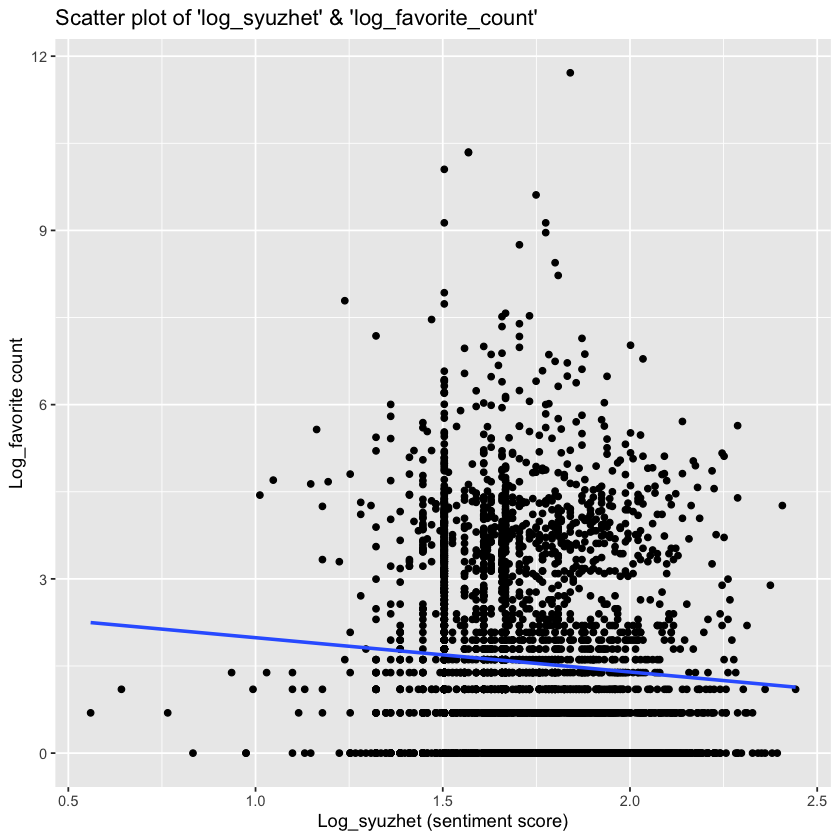

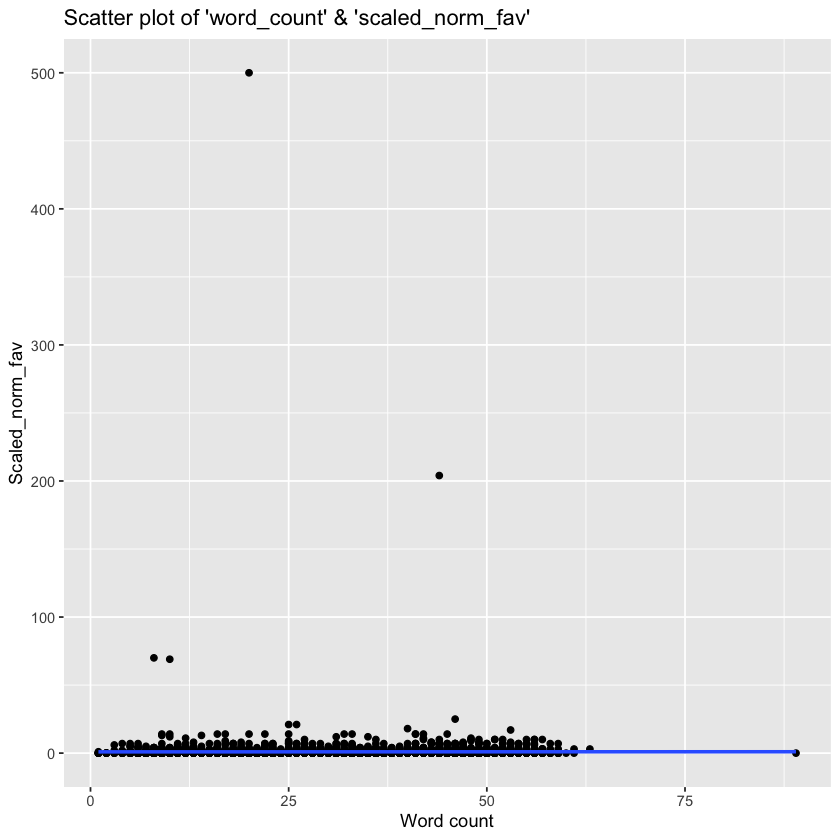

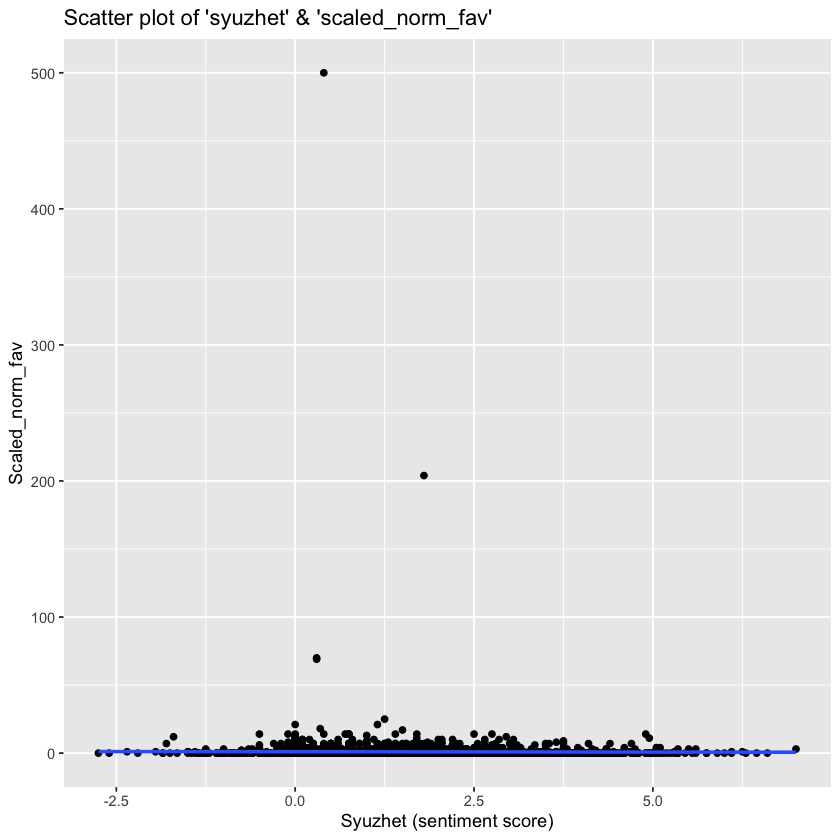

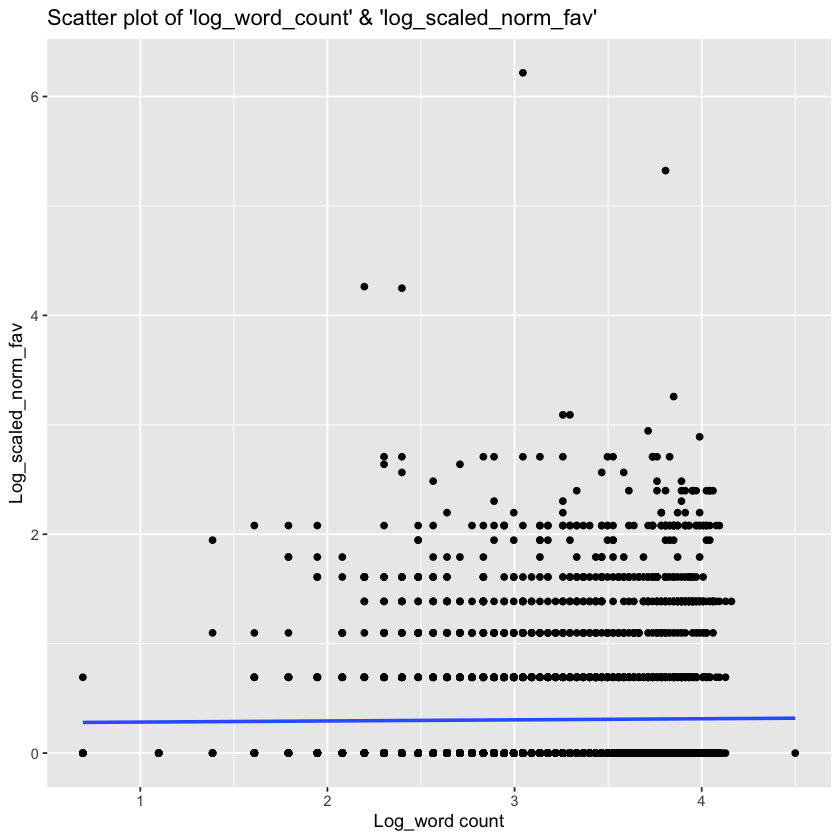

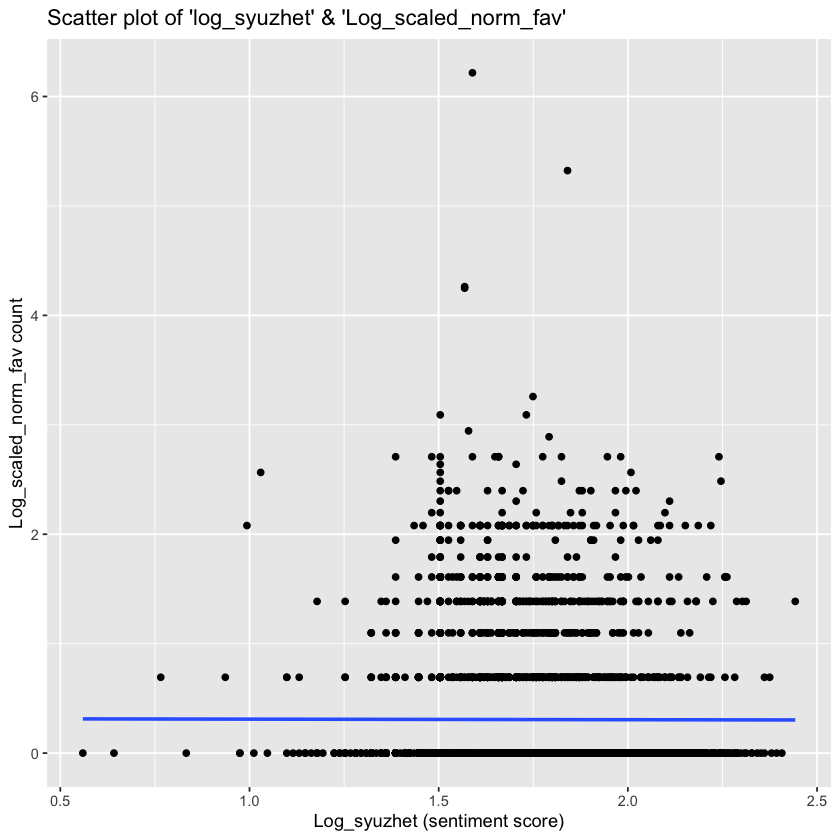

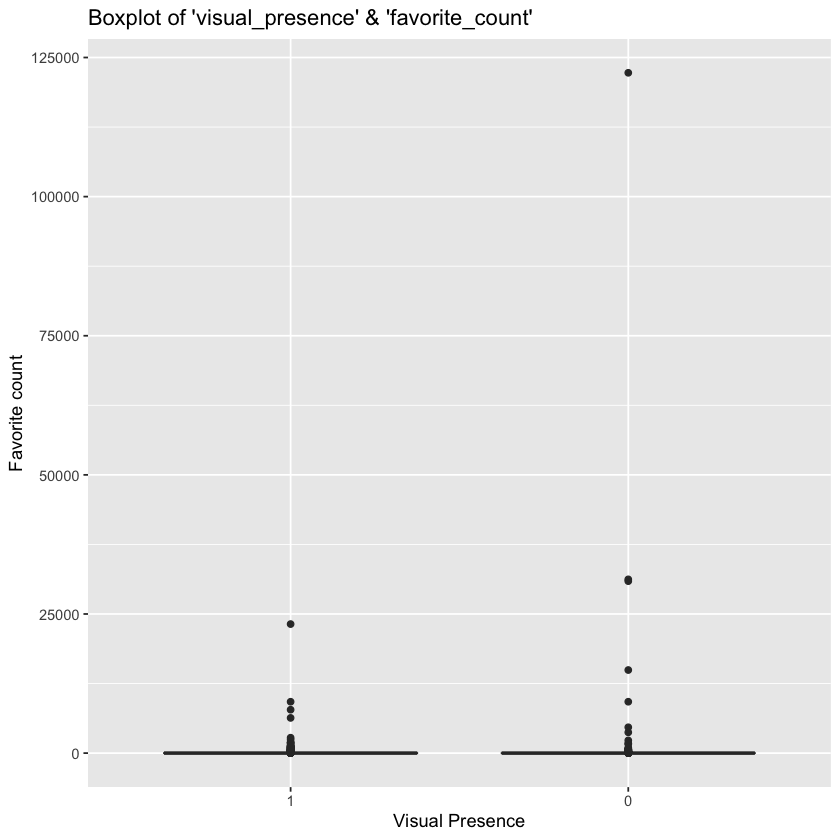

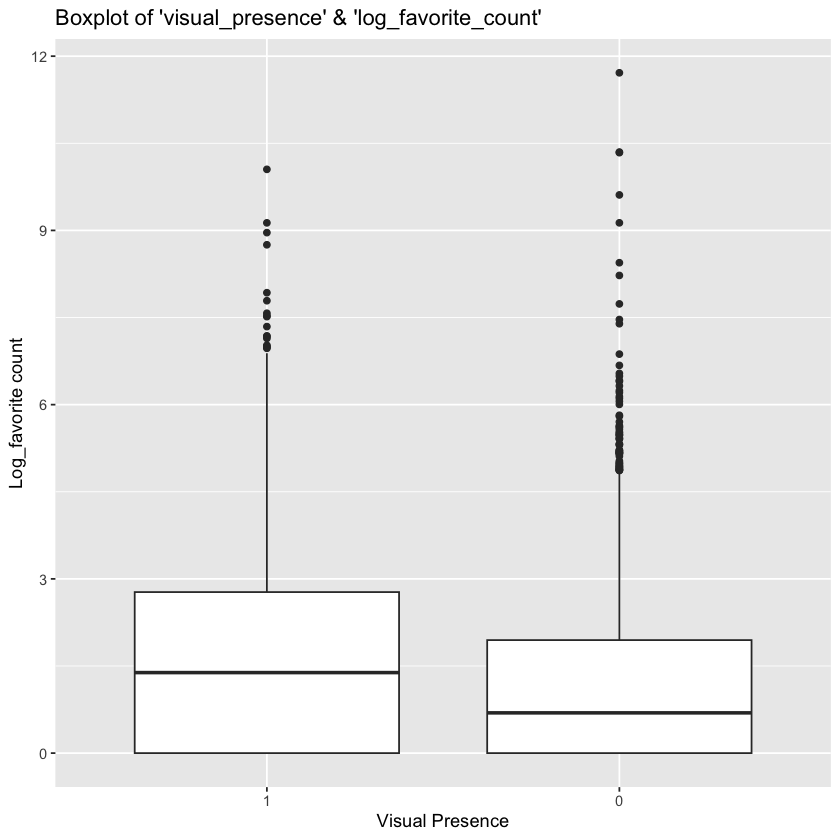

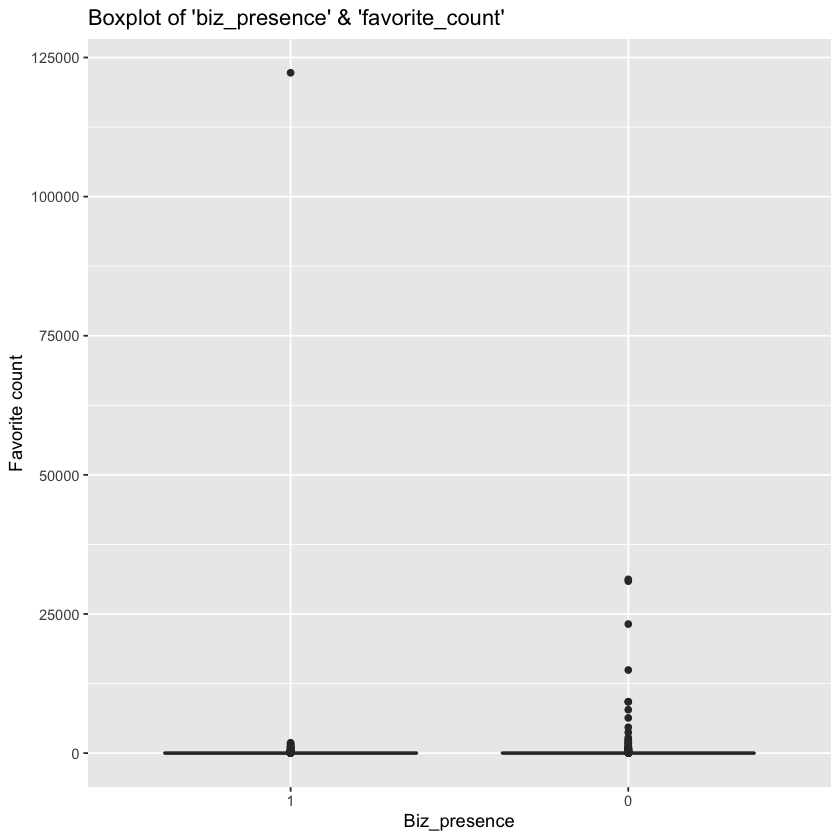

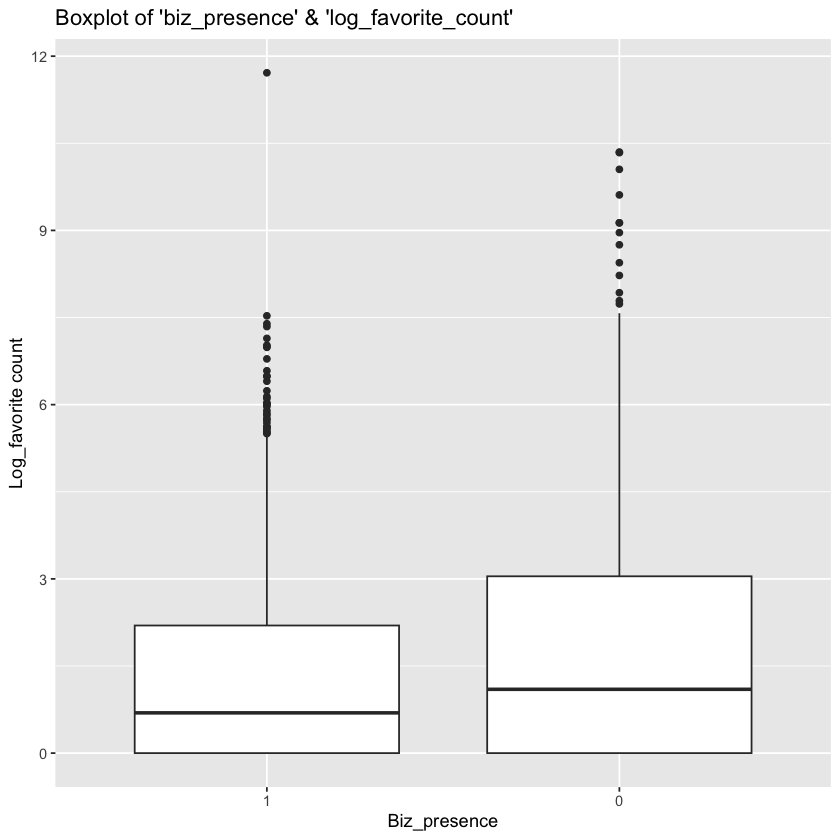

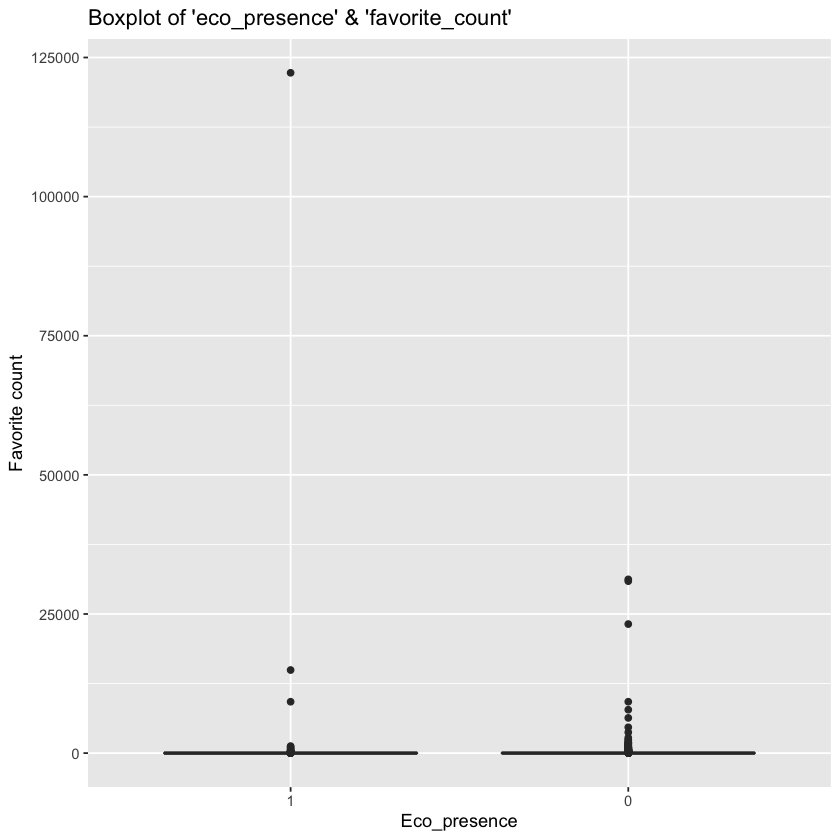

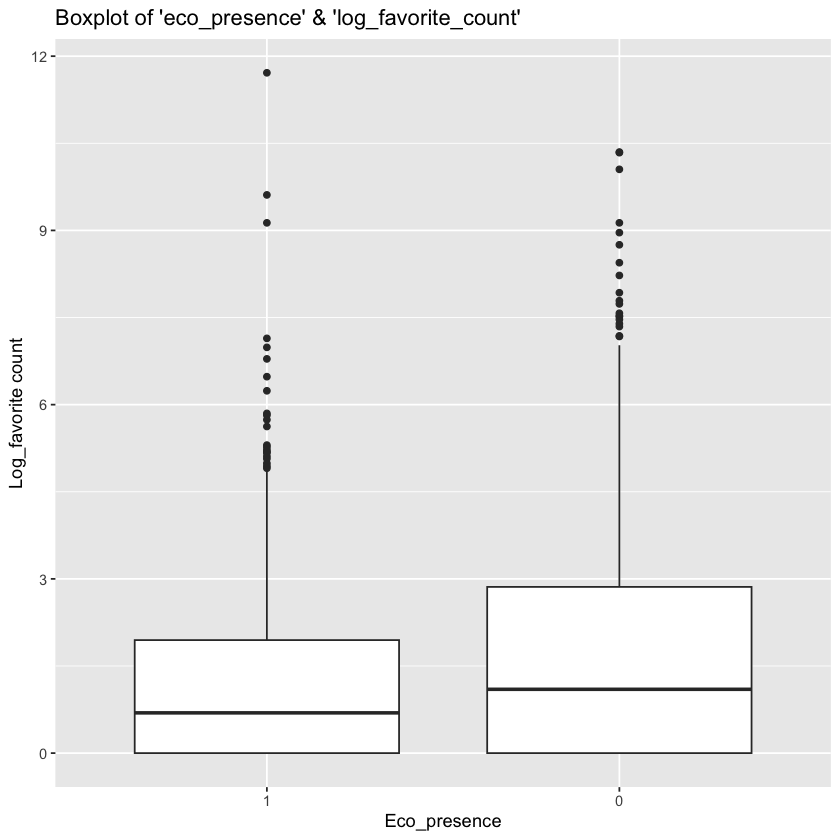

In [69]:
# scatter plot: word_count vs favorite_count
ggplot(recent_data, aes(x=word_count, y=favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Word count", y = "Favorite count", title = "Scatter plot of 'word_count' & 'favorite_count'")

# scatter plot: syuzhet vs favorite_count
ggplot(recent_data, aes(x=syuzhet, y=favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Syuzhet (sentiment score)", y = "Favorite count", title = "Scatter plot of 'syuzhet' & 'favorite_count'")

# scatter plot: log_word_count vs log_favorite_count
ggplot(recent_data, aes(x=log_word_count, y=log_favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Log_word count", y = "Log_favorite count", title = "Scatter plot of 'log_word_count' & 'log_favorite_count'")

# scatter plot: log_syuzhet vs log_favorite_count
ggplot(recent_data, aes(x=log_syuzhet, y=log_favorite_count)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Log_syuzhet (sentiment score)", y = "Log_favorite count", title = "Scatter plot of 'log_syuzhet' & 'log_favorite_count'")

# scatter plot: word_count vs scaled_norm_fav
ggplot(recent_data, aes(x=word_count, y=scaled_norm_fav)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Word count", y = "Scaled_norm_fav", title = "Scatter plot of 'word_count' & 'scaled_norm_fav'")

# scatter plot: syuzhet vs scaled_norm_fav
ggplot(recent_data, aes(x=syuzhet, y=scaled_norm_fav)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Syuzhet (sentiment score)", y = "Scaled_norm_fav", title = "Scatter plot of 'syuzhet' & 'scaled_norm_fav'")

# scatter plot: log_word_count vs log_scaled_norm_fav
ggplot(recent_data, aes(x=log_word_count, y=log_scaled_norm_fav)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE,) +
  labs(x = "Log_word count", y = "Log_scaled_norm_fav", title = "Scatter plot of 'log_word_count' & 'log_scaled_norm_fav'")

# scatter plot: log_syuzhet vs log_scaled_norm_fav
ggplot(recent_data, aes(x=log_syuzhet, y=log_scaled_norm_fav)) + geom_point() + 
  scale_colour_hue(l=50) + 
  geom_smooth(method=lm, formula = y ~ x, se=FALSE, fullrange=TRUE) +
  labs(x = "Log_syuzhet (sentiment score)", y = "Log_scaled_norm_fav count", title = "Scatter plot of 'log_syuzhet' & 'Log_scaled_norm_fav'")

# Boxplot: visual_presence vs favorite_count
ggplot(recent_data, aes(x=visual_presence, y=favorite_count)) + 
  geom_boxplot(aes(group = visual_presence)) + 
  labs(x = "Visual Presence", y = "Favorite count", title = "Boxplot of 'visual_presence' & 'favorite_count'")

# Boxplot: visual_presence vs log_favorite_count
ggplot(recent_data, aes(x=visual_presence, y=log_favorite_count)) + 
  geom_boxplot(aes(group = visual_presence)) + 
  labs(x = "Visual Presence", y = "Log_favorite count", title = "Boxplot of 'visual_presence' & 'log_favorite_count'")

# Boxplot: biz_presence vs favorite_count
ggplot(recent_data, aes(x=biz_presence, y=favorite_count)) + 
  geom_boxplot(aes(group = biz_presence)) + 
  labs(x = "Biz_presence", y = "Favorite count", title = "Boxplot of 'biz_presence' & 'favorite_count'")

# Boxplot: biz_presence vs log_favorite_count
ggplot(recent_data, aes(x=biz_presence, y=log_favorite_count)) + 
  geom_boxplot(aes(group = biz_presence)) + 
  labs(x = "Biz_presence", y = "Log_favorite count", title = "Boxplot of 'biz_presence' & 'log_favorite_count'")

# Boxplot: eco_presence vs favorite_count
ggplot(recent_data, aes(x=eco_presence, y=favorite_count)) + 
  geom_boxplot(aes(group = eco_presence)) + 
  labs(x = "Eco_presence", y = "Favorite count", title = "Boxplot of 'eco_presence' & 'favorite_count'")

# Boxplot: eco_presence vs log_favorite_count
ggplot(recent_data, aes(x=eco_presence, y=log_favorite_count)) + 
  geom_boxplot(aes(group = eco_presence)) + 
  labs(x = "Eco_presence", y = "Log_favorite count", title = "Boxplot of 'eco_presence' & 'log_favorite_count'")


The results are pretty similar to the ones from other data set.<br>
So far, with all different data set used, transformed variable might fit better when it comes to showing linearity. <br>
However, regardless of using transformed variable, predictor variables do not show much of linear relationship with y variable. <br>
Although, they do not show much linearity, they might have non-linear relationship. <br>
Therefore, besides linear regression, we might need to consider other models such as logistic regression as well. <br>
Checking biz_presence and ece_presence in recent_data, the results seem to show that the biz, eco presence did not influence on y variable(almost opposite effect).

### 2-3. Outlier

Here, we are simply checking possible outliers to see if ruling them out makes any difference in distribution.

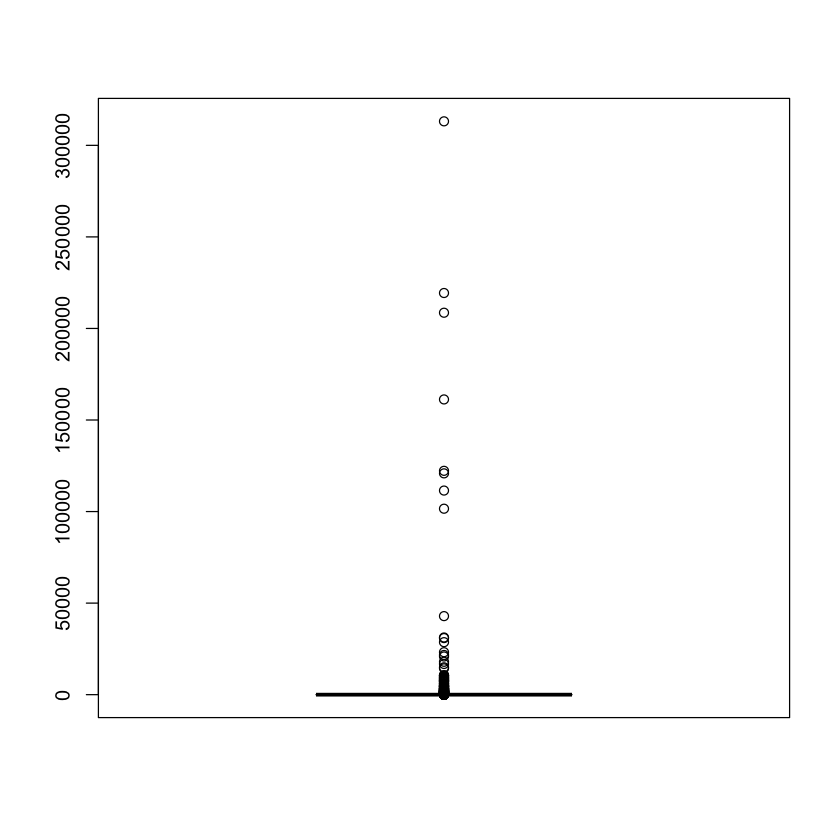

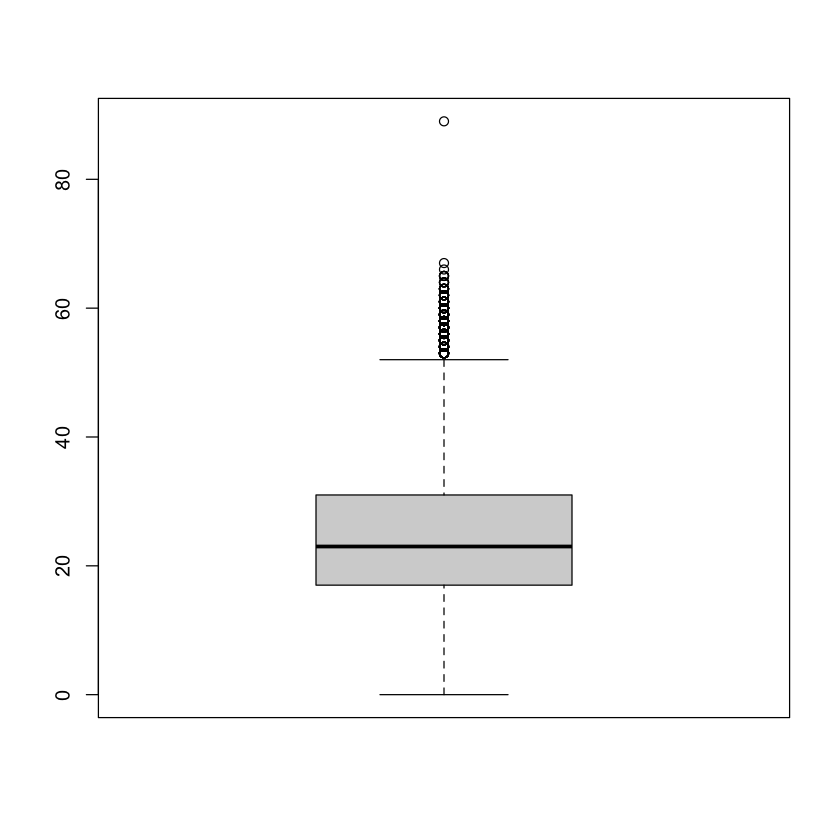

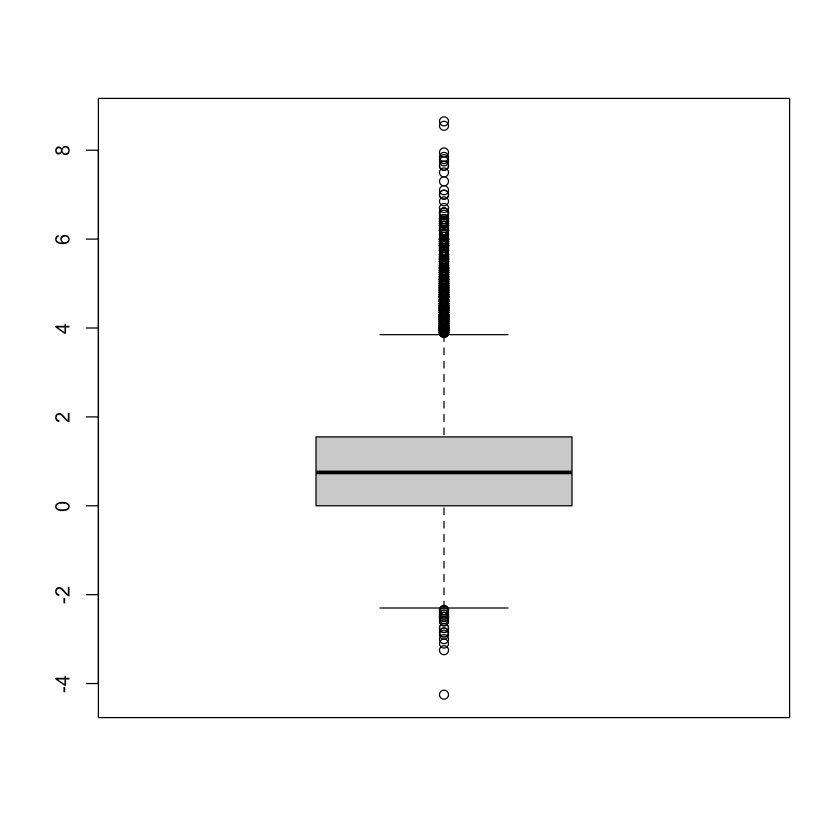

In [70]:
boxplot(data$favorite_count)
boxplot(data$word_count)
boxplot(data$syuzhet)

In [71]:
# predictor variables seem to be fine, but as y variable showed extreme skewed distribution, we can perhaps exclude possible outliers and re-check it
# there are 8 data points with extreme y value over 100,000  
sum(data$favorite_count >= 100000)

[1] 8

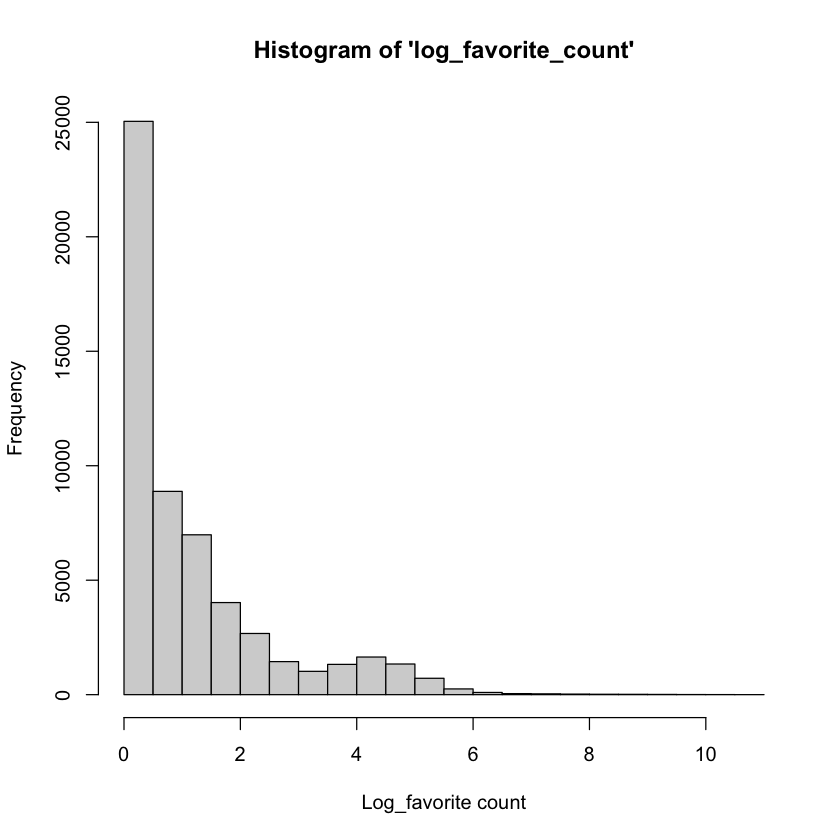

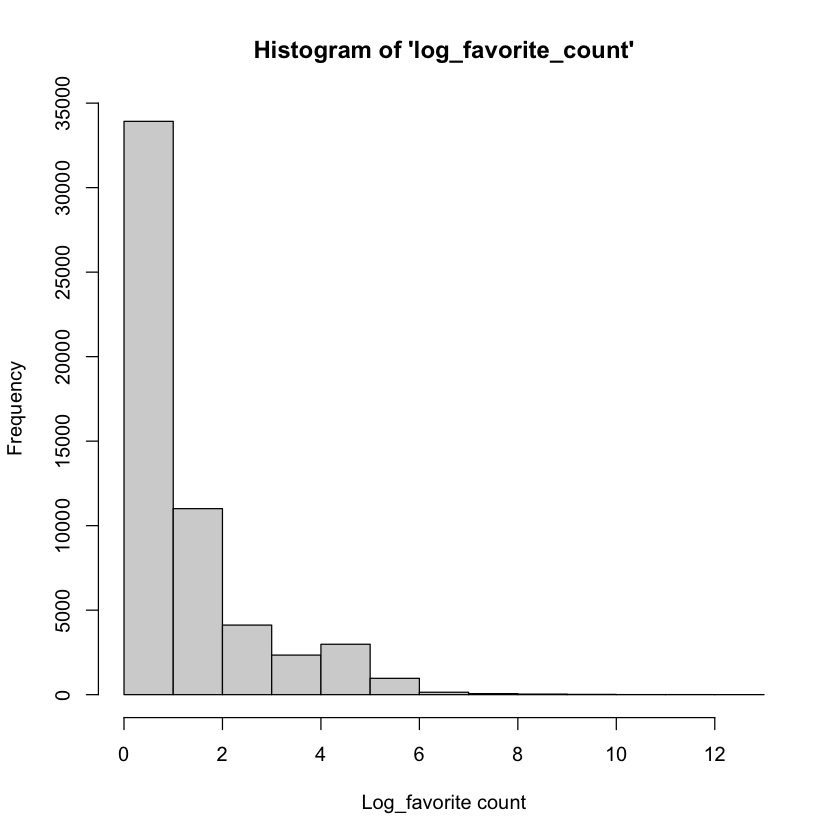

In [72]:
# check the histogram of the response variable 'log_favorite_count' w/o outliers
hist(data$log_favorite_count[data$favorite_count < 100000], 
     xlab = "Log_favorite count",
     ylab = "Frequency",
     main = "Histogram of 'log_favorite_count'")

# check the histogram of the response variable 'log_favorite_count'
hist(data$log_favorite_count, 
     xlab = "Log_favorite count",
     ylab = "Frequency",
     main = "Histogram of 'log_favorite_count'")

We can see that it does not make much difference, as we have too many 0 values anyway.

### 2-4. Correlation

We can check correlations among continuous variables. We will use VIF later after modeling to check multicollinearity including all categorical variables.

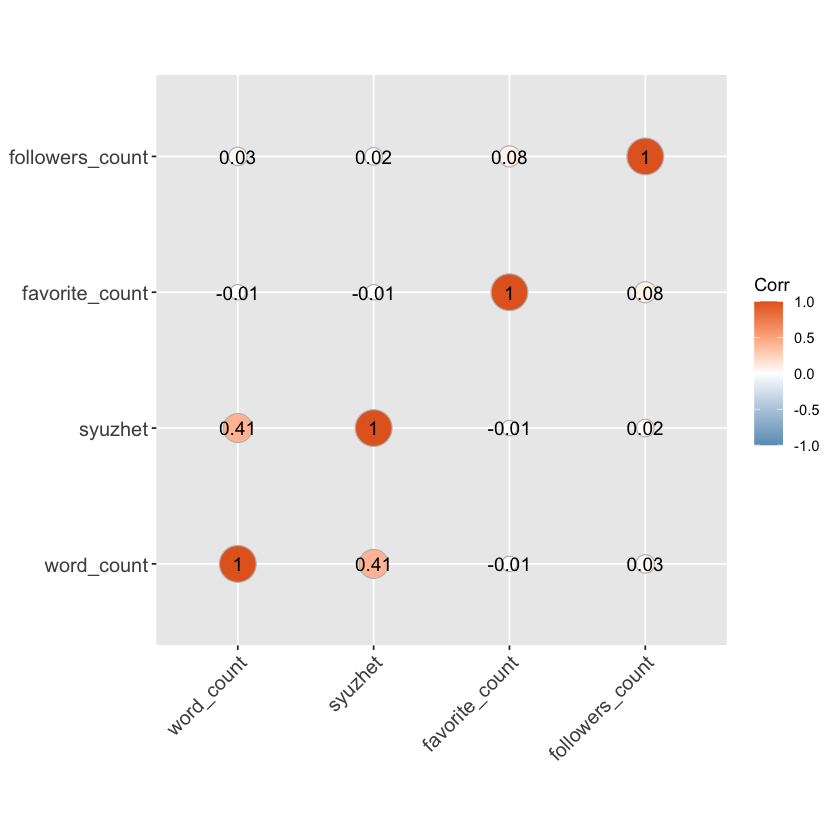

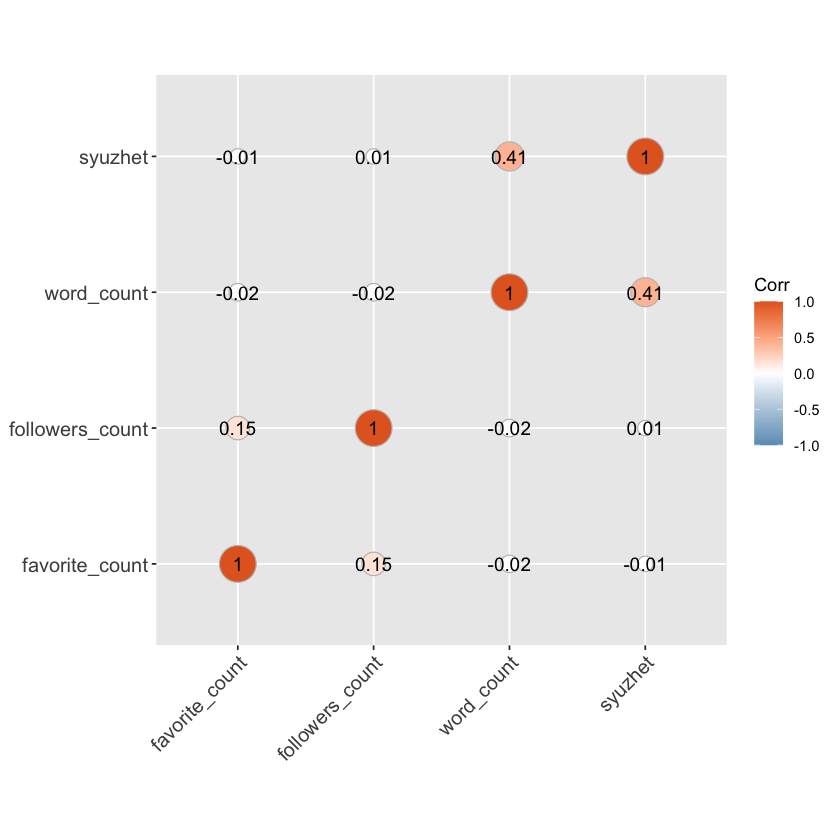

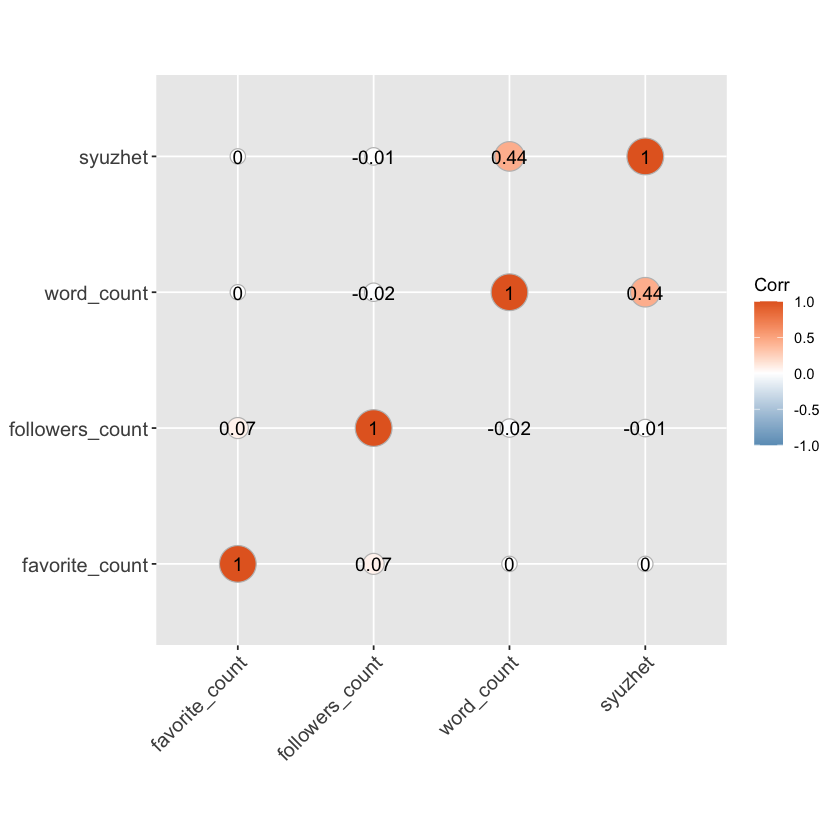

In [73]:
# correlation matrix - original data
cor_matrix <- cor(data[, c("favorite_count", "followers_count", "word_count", "syuzhet")])

ggcorrplot(cor_matrix, hc.order = TRUE, lab = TRUE, ggtheme = ggplot2::theme_gray, 
           colors = c("#6D9EC1", "white", "#E46726"), method = "circle")

# correlation matrix - data_nonzero 
cor_matrix_2 <- cor(data_nonzero[,c("favorite_count", "followers_count", "word_count", "syuzhet")])
ggcorrplot(cor_matrix_2, lab = TRUE, ggtheme = ggplot2::theme_gray, 
           colors = c("#6D9EC1", "white", "#E46726"), method = "circle")

# correlation matrix - recent_data 
cor_matrix_3 <- cor(recent_data[,c("favorite_count", "followers_count", "word_count", "syuzhet")])
ggcorrplot(cor_matrix_3, lab = TRUE, ggtheme = ggplot2::theme_gray, 
           colors = c("#6D9EC1", "white", "#E46726"), method = "circle")

## 3. Preliminary Modeling

##### Note: This section contains code written for the progress report. Feel free to skip ahead to Section 4. Final Modeling.

### 3-1. Linear Regression

In [74]:
# function for linear regression model performance comparison
                             
lm_eval <- function(models) {
    mse_values <- sapply(models, function(mod) mean(resid(mod)^2))
    r2_values <- sapply(models, function(mod) summary(mod)$r.squared)
    adjusted_r2_values <- sapply(models, function(mod) summary(mod)$adj.r.squared)
    aic_values <- sapply(models, AIC)

    model_stats <- data.frame(
      MSE = mse_values,
      R_Squared = r2_values,
      Adjusted_R_Squared = adjusted_r2_values,
      AIC = aic_values
    )
    return(model_stats)
}

In [75]:
# ========= linear regression models w/ 'favorite_count' as Y variable ========= #

# model 1. linear-linear | Y: favorite_count |  R^2 0.0002564
lm_mod1 <- lm(favorite_count ~ word_count + syuzhet + visual_presence, data = data)

# model 2. log-linear | Y: favorite_count | R^2 0.185
lm_mod2 <- lm(log(favorite_count + 1) ~ word_count + syuzhet + visual_presence, data = data)

# model 3. linear-log | Y: favorite_count | R^2 0.000355
lm_mod3 <- lm(favorite_count ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data)

# model 4. log-log | Y: favorite_count | R^2 0.1853
lm_mod4 <- lm(log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data)

# model 5. log-log | Y: favorite_count | without 'visual_presence' | R^2 0.02126
lm_mod5 <- lm(log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5), data=data)

# model 6. linear-sqrt | Y: favorite_count | R^2 0.0003001
lm_mod6 <- lm(favorite_count ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data)

# model 7. log-sqrt | Y: favorite_count | R^2 0.1851
lm_mod7 <- lm(log(favorite_count+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data)


# ========= w/ filtered dataset 'data_nonzero' ========= #

# model 8. linear-linear | Y: favorite_count | 
lm_mod8 <- lm(favorite_count ~ word_count + syuzhet + visual_presence, data = data_nonzero)

# model 9. log-linear | Y: favorite_count | 
lm_mod9 <- lm(log(favorite_count + 1) ~ word_count + syuzhet + visual_presence, data = data_nonzero)

# model 10. linear-log | Y: favorite_count | 
lm_mod10 <- lm(favorite_count ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data_nonzero)

# model 11. log-log | Y: favorite_count |
lm_mod11 <- lm(log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data_nonzero)

# model 12. log-log | Y: favorite_count | without 'visual_presence' | 
lm_mod12 <- lm(formula= log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5), data=data_nonzero)

# model 13. linear-sqrt | Y: favorite_count | 
lm_mod13 <- lm(favorite_count ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data_nonzero)

# model 14. log-sqrt | Y: favorite_count | 
lm_mod14 <- lm(log(favorite_count+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data_nonzero)

In [76]:
lm_model_names <- paste("lm_mod", 1:14, sep="")
lm_models <- mget(lm_model_names)
lm_eval(lm_models)

MSE          R_Squared    Adjusted_R_Squared AIC      
lm_mod1  4.983287e+06 0.0002563627  2.024207e-04      1015328.2
lm_mod2  1.727520e+00 0.1849913867  1.849474e-01       188208.7
lm_mod3  4.982795e+06 0.0003549750  3.010383e-04      1015322.7
lm_mod4  1.726918e+00 0.1852753273  1.852314e-01       188189.3
lm_mod5  2.074573e+00 0.0212588480  2.122364e-02       198386.2
lm_mod6  4.983069e+06 0.0003000783  2.461386e-04      1015325.8
lm_mod7  1.727372e+00 0.1850609900  1.850170e-01       188203.9
lm_mod8  3.035880e+05 0.0003931289  2.949679e-04       472414.7
lm_mod9  1.949503e+00 0.0598194943  5.972717e-02       107115.6
lm_mod10 3.034475e+05 0.0008559218  7.578062e-04       472400.5
lm_mod11 1.947692e+00 0.0606927606  6.060052e-02       107087.2
lm_mod12 2.073515e+00 0.0000126492 -5.281428e-05       108997.9
lm_mod13 3.035302e+05 0.0005835441  4.854017e-04       472408.9
lm_mod14 1.948820e+00 0.0601489257  6.005663e-02       107104.9

In [77]:
# ========= linear regression models w/ 'norm_fav' as Y variable ========= #

# model 1. linear-linear | Y: norm_fav |
normfav_lm_mod1 <- lm(norm_fav ~ word_count + syuzhet + visual_presence, data = data)

# model 2. log-linear | Y: norm_fav |
normfav_lm_mod2 <- lm(log(norm_fav + 1) ~ word_count + syuzhet + visual_presence, data = data)

# model 3. linear-log | Y: norm_fav |
normfav_lm_mod3 <- lm(norm_fav ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data)

# model 4. log-log | Y: norm_fav |
normfav_lm_mod4 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data)

# model 5. log-log | Y: norm_fav | without 'visual_presence' |
normfav_lm_mod5 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5), data=data)

# model 6. linear-sqrt | Y: norm_fav |
normfav_lm_mod6 <- lm(norm_fav ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data)

# model 7. log-sqrt | Y: norm_fav |
normfav_lm_mod7 <- lm(log(norm_fav+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data)

# ========= w/ filtered dataset 'data_nonzero' ========= #

# model 8. linear-linear | Y: norm_fav | 
normfav_lm_mod8 <- lm(norm_fav ~ word_count + syuzhet + visual_presence, data = data_nonzero)

# model 9. log-linear | Y: norm_fav | 
normfav_lm_mod9 <- lm(log(norm_fav + 1) ~ word_count + syuzhet + visual_presence, data = data_nonzero)

# model 10. linear-log | Y: norm_fav | 
normfav_lm_mod10 <- lm(norm_fav ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data_nonzero)

# model 11. log-log | Y: norm_fav |
normfav_lm_mod11 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = data_nonzero)

# model 12. log-log | Y: norm_fav | without 'visual_presence' | 
normfav_lm_mod12 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5), data=data_nonzero)

# model 13. linear-sqrt | Y: norm_fav | 
normfav_lm_mod13 <- lm(norm_fav ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data_nonzero)

# model 14. log-sqrt | Y: norm_fav | 
normfav_lm_mod14 <- lm(log(norm_fav+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = data_nonzero)

In [78]:
# performance comparison

normfav_lm_model_names <- paste("normfav_lm_mod", 1:14, sep="")
normfav_lm_models <- mget(normfav_lm_model_names)
lm_eval(normfav_lm_models)

MSE          R_Squared    Adjusted_R_Squared AIC      
normfav_lm_mod1  9.732281e-04 0.0001473802 9.343233e-05       -227804.5
normfav_lm_mod2  9.362348e-05 0.0007509312 6.970158e-04       -357994.6
normfav_lm_mod3  9.732422e-04 0.0001328414 7.889268e-05       -227803.7
normfav_lm_mod4  9.362790e-05 0.0007037502 6.498323e-04       -357992.0
normfav_lm_mod5  9.368191e-05 0.0001273423 9.137690e-05       -357961.9
normfav_lm_mod6  9.732341e-04 0.0001411323 8.718407e-05       -227804.2
normfav_lm_mod7  9.362623e-05 0.0007216487 6.677318e-04       -357992.9
normfav_lm_mod8  2.716014e-05 0.0004163642 3.182054e-04       -234518.9
normfav_lm_mod9  2.137568e-05 0.0004832089 3.850567e-04       -241836.5
normfav_lm_mod10 2.715293e-05 0.0006814178 5.832850e-04       -234527.0
normfav_lm_mod11 2.136798e-05 0.0008430989 7.449820e-04       -241847.5
normfav_lm_mod12 2.137221e-05 0.0006456333 5.802113e-04       -241843.5
normfav_lm_mod13 2.715896e-05 0.0004595781 3.614236e-04       -234520.3
normfav_lm_mod14 2.137418e-05 0.0005533712 4.552259e-04       -241838.7

In [79]:
quantile(data_nonzero$norm_fav)

0%          25%          50%          75%         100% 
6.287775e-07 9.812459e-05 3.543586e-04 9.165903e-04 5.000000e-01

#### The reason why models that set 'norm_fav' as Y variable has lower R^2 compared to when Y variable is 'favorite_count' could be because the range of 'norm_fav' values are too narrow and small.

#### The best model is lm_mod4 according to the MSE, R^2, and Adjusted R^2 (AIC is hard to directly compare due to log, sqrt transformations)

In [80]:
summary(lm_mod4)


Call:
lm(formula = log(favorite_count + 1) ~ log(word_count + 1) + 
    log(syuzhet + 4.5) + visual_presence, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8035 -0.5546 -0.3902  0.3136 11.3788 

Coefficients:
                     Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          1.948409   0.055661   35.005  < 2e-16 ***
log(word_count + 1) -0.081582   0.013419   -6.080 1.21e-09 ***
log(syuzhet + 4.5)  -0.009046   0.032076   -0.282    0.778    
visual_presence0    -1.286142   0.012157 -105.799  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.314 on 55601 degrees of freedom
Multiple R-squared:  0.1853,	Adjusted R-squared:  0.1852 
F-statistic:  4215 on 3 and 55601 DF,  p-value: < 2.2e-16


#### 'syuzhet' doesn't appear to be statistically significant, so let's build a model without 'syuzhet'

In [81]:
lm_mod15 <- lm(log(favorite_count+1) ~ log(word_count+1) + visual_presence, data = data)
summary(lm_mod15)


Call:
lm(formula = log(favorite_count + 1) ~ log(word_count + 1) + 
    visual_presence, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8043 -0.5542 -0.3911  0.3122 11.3785 

Coefficients:
                    Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          1.93801    0.04169   46.487  < 2e-16 ***
log(word_count + 1) -0.08306    0.01235   -6.723  1.8e-11 ***
visual_presence0    -1.28645    0.01211 -106.242  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.314 on 55602 degrees of freedom
Multiple R-squared:  0.1853,	Adjusted R-squared:  0.1852 
F-statistic:  6322 on 2 and 55602 DF,  p-value: < 2.2e-16


#### There is not much difference between the two model, indicating 'syuzhet' might not be a good feature to predict 'favorite_count'.

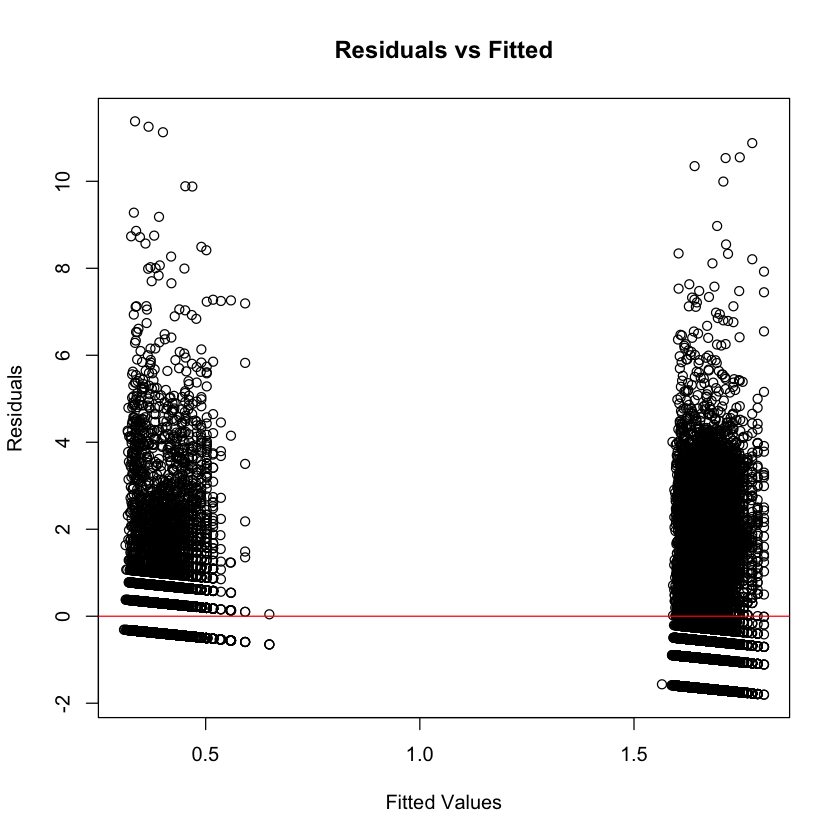

In [82]:
# lm_mod4 residuals vs fitted plot
plot(lm_mod4$fitted.values, resid(lm_mod4),
     xlab = "Fitted Values",
     ylab = "Residuals",
     main = "Residuals vs Fitted")
abline(h = 0, col = "red")

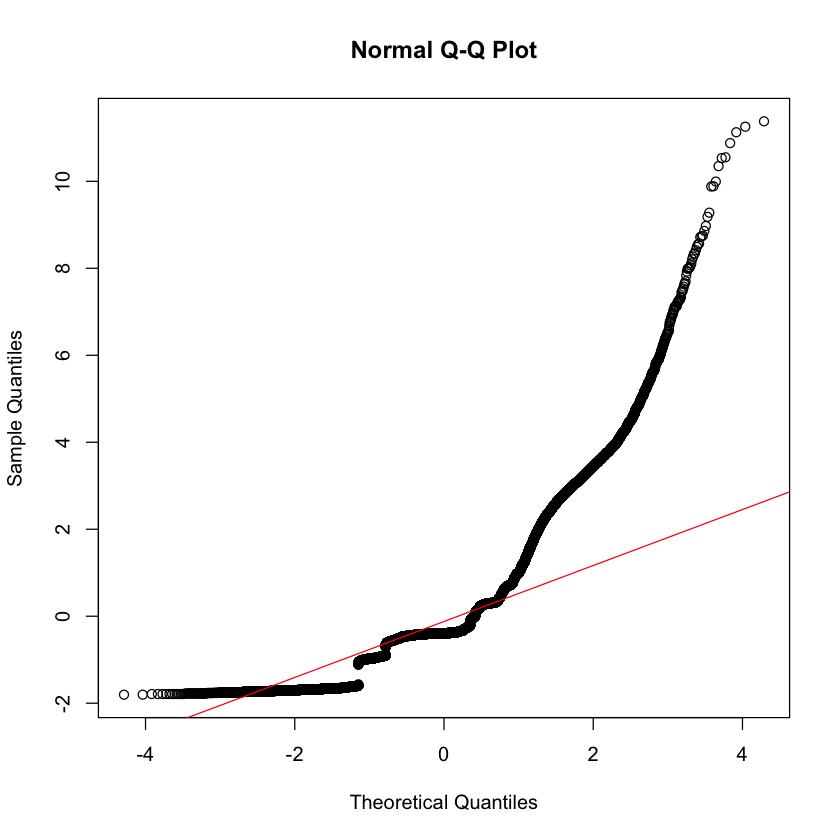

In [83]:
# lm_mod4 Q-Q plot
qqnorm(resid(lm_mod4))
qqline(resid(lm_mod4), col = "red")

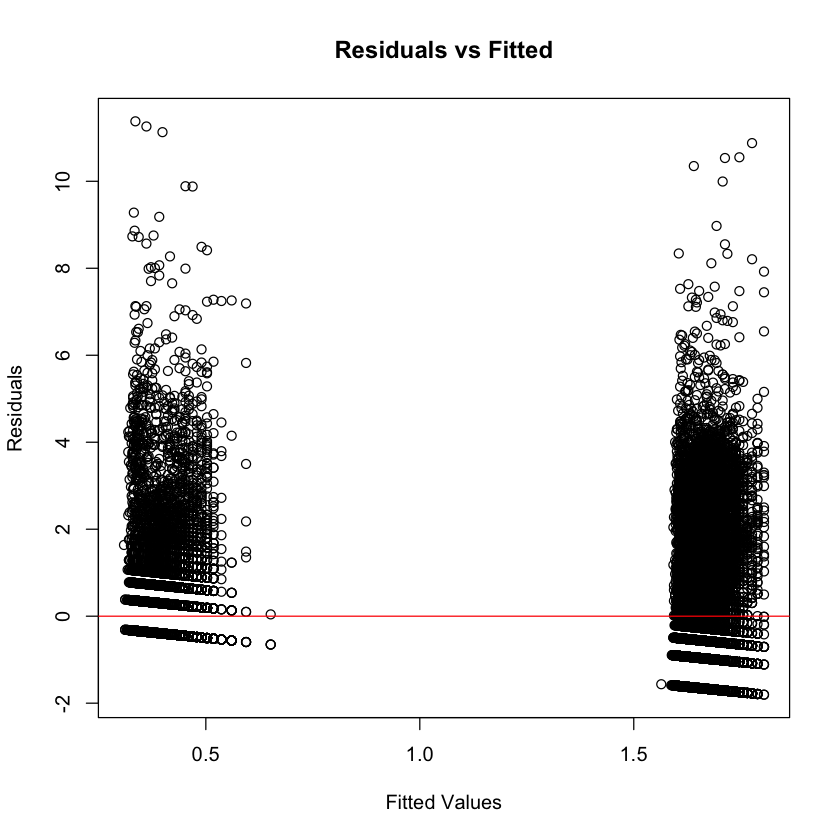

In [84]:
# lm_mod15 residuals vs fitted plot
plot(lm_mod15$fitted.values, resid(lm_mod15),
     xlab = "Fitted Values",
     ylab = "Residuals",
     main = "Residuals vs Fitted")
abline(h = 0, col = "red")

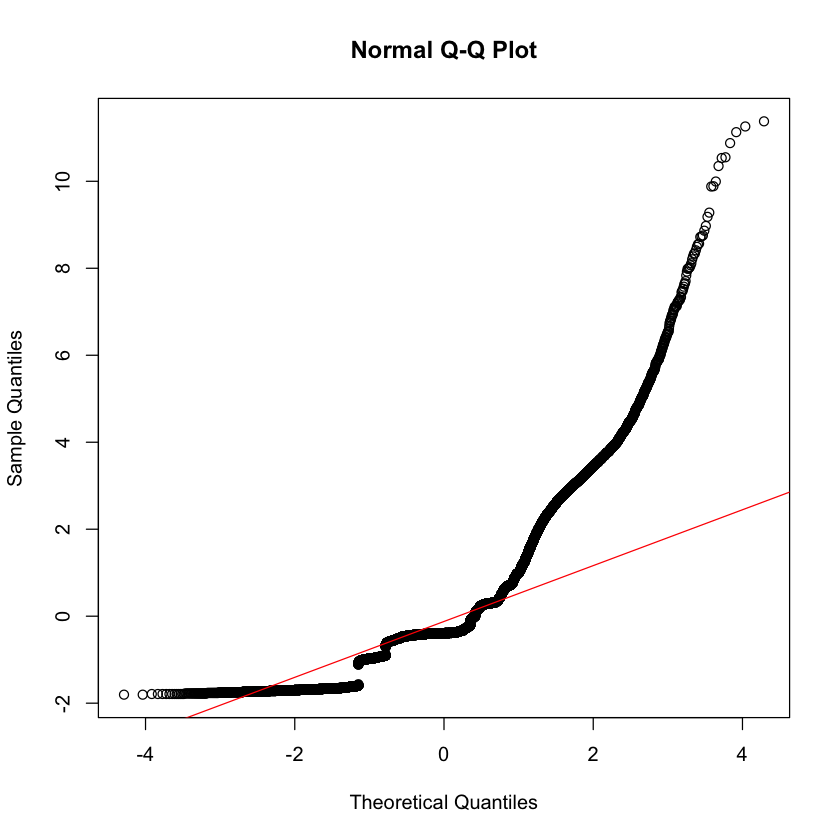

In [85]:
# lm_mod15 Q-Q plot
qqnorm(resid(lm_mod15))
qqline(resid(lm_mod15), col = "red")

#### The residuals are not homoscedastic, and the model does not fit all parts of the data equally well.

In [86]:
# ========= w/ recent data

# ========= linear regression models w/ 'favorite_count' as Y variable ========= #

# model 1. linear-linear | Y: favorite_count | 
recent_lm_mod1 <- lm(favorite_count ~ word_count + syuzhet + visual_presence, data = recent_data)

# model 2. log-linear | Y: favorite_count |
recent_lm_mod2 <- lm(log(favorite_count + 1) ~ word_count + syuzhet + visual_presence, data = recent_data)

# model 3. linear-log | Y: favorite_count |
recent_lm_mod3 <- lm(favorite_count ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data)

# model 4. log-log | Y: favorite_count |
recent_lm_mod4 <- lm(log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data)

# model 5. log-log | Y: favorite_count | without 'visual_presence' |
recent_lm_mod5 <- lm(log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5), data=data)

# model 6. linear-sqrt | Y: favorite_count |
recent_lm_mod6 <- lm(favorite_count ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data)

# model 7. log-sqrt | Y: favorite_count |
recent_lm_mod7 <- lm(log(favorite_count+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data)


# ========= w/ filtered dataset 'data_nonzero' ========= #

# model 8. linear-linear | Y: favorite_count | 
recent_lm_mod8 <- lm(favorite_count ~ word_count + syuzhet + visual_presence, data = recent_data_nonzero)

# model 9. log-linear | Y: favorite_count | 
recent_lm_mod9 <- lm(log(favorite_count + 1) ~ word_count + syuzhet + visual_presence, data = recent_data_nonzero)

# model 10. linear-log | Y: favorite_count | 
recent_lm_mod10 <- lm(favorite_count ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 11. log-log | Y: favorite_count |
recent_lm_mod11 <- lm(log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 12. log-log | Y: favorite_count | without 'visual_presence' | 
recent_lm_mod12 <- lm(formula= log(favorite_count+1) ~ log(word_count+1) + log(syuzhet+4.5), data=recent_data_nonzero)

# model 13. linear-sqrt | Y: favorite_count | 
recent_lm_mod13 <- lm(favorite_count ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 14. log-sqrt | Y: favorite_count | 
recent_lm_mod14 <- lm(log(favorite_count+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

In [87]:
# performance comparison

recent_lm_model_names <- paste("recent_lm_mod", 1:14, sep="")
recent_lm_models <- mget(recent_lm_model_names)
lm_eval(recent_lm_models)

MSE          R_Squared   Adjusted_R_Squared AIC       
recent_lm_mod1  4.609144e+06 0.001573451 0.0008034566        70808.488
recent_lm_mod2  2.786428e+00 0.022794718 0.0220410895        15051.111
recent_lm_mod3  4.609679e+06 0.001457526 0.0006874422        70808.940
recent_lm_mod4  2.775383e+00 0.026668325 0.0259176832        15035.644
recent_lm_mod5  2.074573e+00 0.021258848 0.0212236428       198386.194
recent_lm_mod6  4.609452e+06 0.001506689 0.0007366428        70808.748
recent_lm_mod7  2.780876e+00 0.024741950 0.0239898227        15043.344
recent_lm_mod8  1.139501e+06 0.004610152 0.0034849941        44621.815
recent_lm_mod9  2.454685e+00 0.004732774 0.0036077543         9939.957
recent_lm_mod10 1.139155e+06 0.004913138 0.0037883224        44621.005
recent_lm_mod11 2.447474e+00 0.007656562 0.0065348476         9932.137
recent_lm_mod12 2.449233e+00 0.006943551 0.0061954858         9932.046
recent_lm_mod13 1.139323e+06 0.004765699 0.0036407170        44621.399
recent_lm_mod14 2.451562e+00 0.005998922 0.0048753334         9936.574

In [88]:
summary(recent_lm_mod4)


Call:
lm(formula = log(favorite_count + 1) ~ log(word_count + 1) + 
    log(syuzhet + 4.5) + visual_presence, data = recent_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1877 -1.2238 -0.5014  0.8936 10.6917 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.10582    0.23005  13.501  < 2e-16 ***
log(word_count + 1) -0.32950    0.05453  -6.043 1.66e-09 ***
log(syuzhet + 4.5)  -0.18410    0.14029  -1.312    0.189    
visual_presence0    -0.49049    0.06082  -8.065 9.66e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.667 on 3890 degrees of freedom
Multiple R-squared:  0.02667,	Adjusted R-squared:  0.02592 
F-statistic: 35.53 on 3 and 3890 DF,  p-value: < 2.2e-16


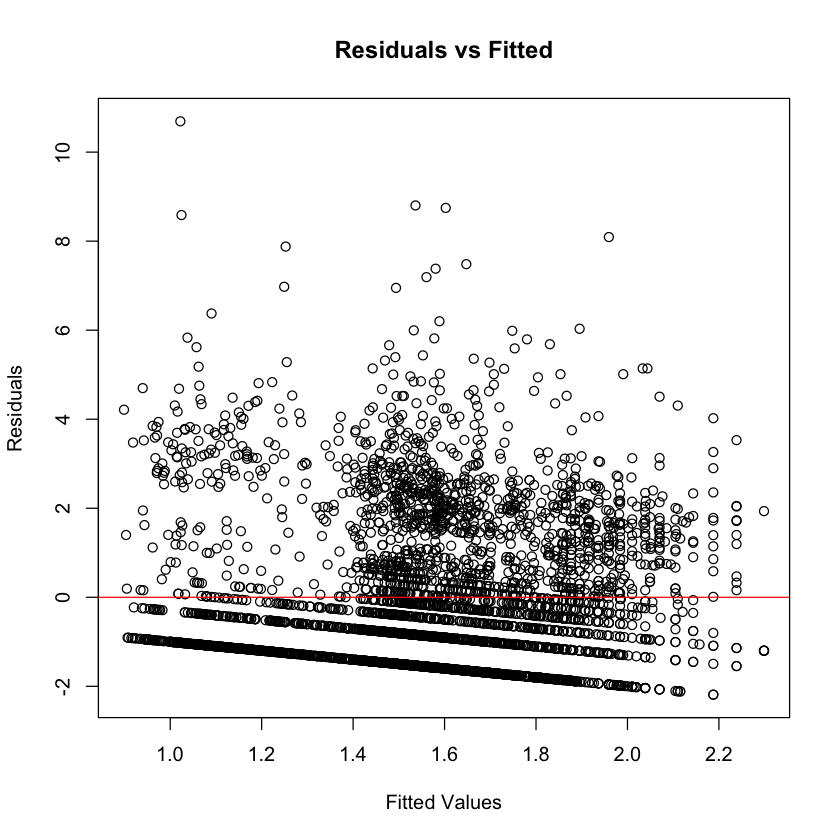

In [89]:
# recent_lm_mod4 residuals vs fitted plot
plot(recent_lm_mod4$fitted.values, resid(recent_lm_mod4),
     xlab = "Fitted Values",
     ylab = "Residuals",
     main = "Residuals vs Fitted")
abline(h = 0, col = "red")

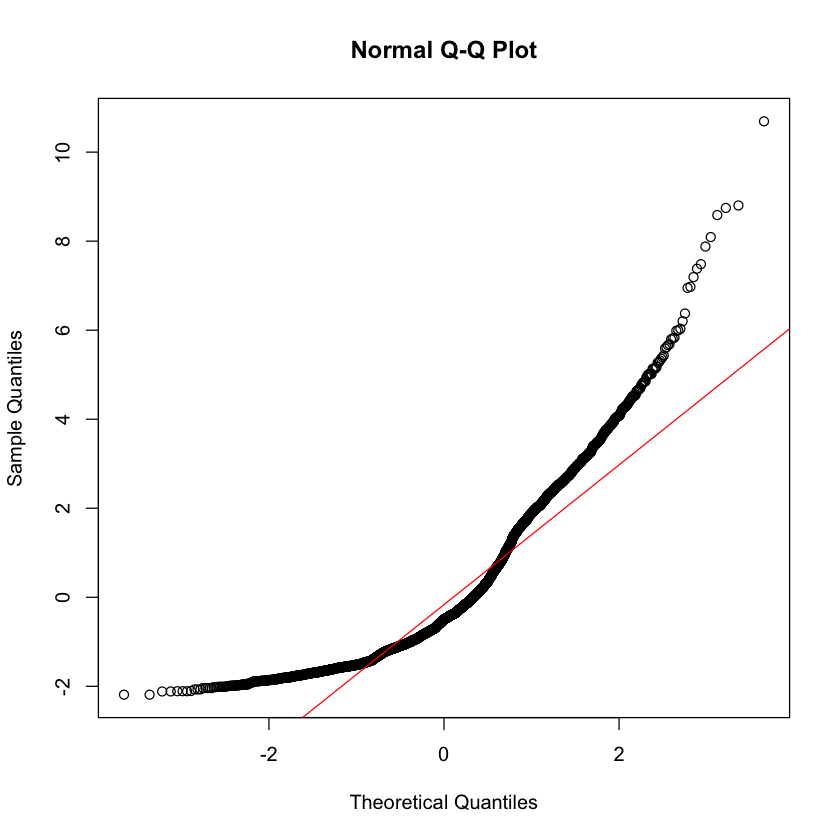

In [90]:
# recent_lm_mod4 Q-Q plot
qqnorm(resid(recent_lm_mod4))
qqline(resid(recent_lm_mod4), col = "red")

In [91]:
# ========= w/ recent data

# ========= linear regression models w/ 'norm_fav' as Y variable ========= #

# model 1. linear-linear | Y: norm_fav |
recent_normfav_lm_mod1 <- lm(norm_fav ~ word_count + syuzhet + visual_presence, data = recent_data)

# model 2. log-linear | Y: norm_fav |
recent_normfav_lm_mod2 <- lm(log(norm_fav + 1) ~ word_count + syuzhet + visual_presence, data = recent_data)

# model 3. linear-log | Y: norm_fav |
recent_normfav_lm_mod3 <- lm(norm_fav ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data)

# model 4. log-log | Y: norm_fav |
recent_normfav_lm_mod4 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data)

# model 5. log-log | Y: norm_fav | without 'visual_presence' |
recent_normfav_lm_mod5 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5), data=recent_data)

# model 6. linear-sqrt | Y: norm_fav |
recent_normfav_lm_mod6 <- lm(norm_fav ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data)

# model 7. log-sqrt | Y: norm_fav |
recent_normfav_lm_mod7 <- lm(log(norm_fav+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data)

# ========= w/ filtered dataset 'data_nonzero' ========= #

# model 8. linear-linear | Y: norm_fav | 
recent_normfav_lm_mod8 <- lm(norm_fav ~ word_count + syuzhet + visual_presence, data = recent_data_nonzero)

# model 9. log-linear | Y: norm_fav | 
recent_normfav_lm_mod9 <- lm(log(norm_fav + 1) ~ word_count + syuzhet + visual_presence, data = recent_data_nonzero)

# model 10. linear-log | Y: norm_fav | 
recent_normfav_lm_mod10 <- lm(norm_fav ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 11. log-log | Y: norm_fav |
recent_normfav_lm_mod11 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 12. log-log | Y: norm_fav | without 'visual_presence' | 
recent_normfav_lm_mod12 <- lm(log(norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5), data=recent_data_nonzero)

# model 13. linear-sqrt | Y: norm_fav | 
recent_normfav_lm_mod13 <- lm(norm_fav ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 14. log-sqrt | Y: norm_fav | 
recent_normfav_lm_mod14 <- lm(log(norm_fav+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

In [92]:
# performance comparison

recent_normfav_lm_model_names <- paste("recent_normfav_lm_mod", 1:14, sep="")
recent_normfav_lm_models <- mget(recent_normfav_lm_model_names)
lm_eval(recent_normfav_lm_models)

MSE          R_Squared    Adjusted_R_Squared AIC      
recent_normfav_lm_mod1  8.038048e-05 1.338152e-03  0.0005679758      -25654.82
recent_normfav_lm_mod2  5.645627e-05 1.389477e-03  0.0006193404      -27030.59
recent_normfav_lm_mod3  8.038894e-05 1.233074e-03  0.0004628163      -25654.41
recent_normfav_lm_mod4  5.646470e-05 1.240296e-03  0.0004700443      -27030.01
recent_normfav_lm_mod5  5.653267e-05 3.800468e-05 -0.0004759825      -27027.32
recent_normfav_lm_mod6  8.038526e-05 1.278713e-03  0.0005084910      -25654.59
recent_normfav_lm_mod7  5.646105e-05 1.304899e-03  0.0005346973      -27030.26
recent_normfav_lm_mod8  1.014689e-04 3.344338e-03  0.0022177489      -16889.25
recent_normfav_lm_mod9  6.915893e-05 3.789416e-03  0.0026633305      -17908.18
recent_normfav_lm_mod10 1.014737e-04 3.296525e-03  0.0021698822      -16889.12
recent_normfav_lm_mod11 6.916532e-05 3.697335e-03  0.0025711451      -17907.93
recent_normfav_lm_mod12 6.942130e-05 1.001016e-05 -0.0007432780      -17900.11
recent_normfav_lm_mod13 1.014721e-04 3.312452e-03  0.0021858269      -16889.16
recent_normfav_lm_mod14 6.916292e-05 3.731816e-03  0.0026056656      -17908.03

In [93]:
# ========= w/ recent data

# ========= linear regression models w/ 'scaled_norm_fav' as Y variable ========= #

# model 1. linear-linear | Y: scaled_norm_fav |
recent_scaled_normfav_lm_mod1 <- lm(scaled_norm_fav ~ word_count + syuzhet + visual_presence, data = recent_data)

# model 2. log-linear | Y: scaled_norm_fav |
recent_scaled_normfav_lm_mod2 <- lm(log(scaled_norm_fav + 1) ~ word_count + syuzhet + visual_presence, data = recent_data)

# model 3. linear-log | Y: scaled_norm_fav |
recent_scaled_normfav_lm_mod3 <- lm(scaled_norm_fav ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data)

# model 4. log-log | Y: scaled_norm_fav |
recent_scaled_normfav_lm_mod4 <- lm(log(scaled_norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data)

# model 5. log-log | Y: scaled_norm_fav | without 'visual_presence' |
recent_scaled_normfav_lm_mod5 <- lm(log(scaled_norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5), data=recent_data)

# model 6. linear-sqrt | Y: scaled_norm_fav |
recent_scaled_normfav_lm_mod6 <- lm(scaled_norm_fav ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data)

# model 7. log-sqrt | Y: scaled_norm_fav |
recent_scaled_normfav_lm_mod7 <- lm(log(scaled_norm_fav+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data)

# ========= w/ filtered dataset 'data_nonzero' ========= #

# model 8. linear-linear | Y: scaled_norm_fav | 
recent_scaled_normfav_lm_mod8 <- lm(scaled_norm_fav ~ word_count + syuzhet + visual_presence, data = recent_data_nonzero)

# model 9. log-linear | Y: scaled_norm_fav | 
recent_scaled_normfav_lm_mod9 <- lm(log(scaled_norm_fav + 1) ~ word_count + syuzhet + visual_presence, data = recent_data_nonzero)

# model 10. linear-log | Y: scaled_norm_fav | 
recent_scaled_normfav_lm_mod10 <- lm(scaled_norm_fav ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 11. log-log | Y: scaled_norm_fav |
recent_scaled_normfav_lm_mod11 <- lm(log(scaled_norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 12. log-log | Y: scaled_norm_fav | without 'visual_presence' | 
recent_scaled_normfav_lm_mod12 <- lm(log(scaled_norm_fav+1) ~ log(word_count+1) + log(syuzhet+4.5), data=recent_data_nonzero)

# model 13. linear-sqrt | Y: scaled_norm_fav | 
recent_scaled_normfav_lm_mod13 <- lm(scaled_norm_fav ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

# model 14. log-sqrt | Y: scaled_norm_fav | 
recent_scaled_normfav_lm_mod14 <- lm(log(scaled_norm_fav+1) ~ sqrt(word_count+1) + sqrt(syuzhet+4.5) + visual_presence, data = recent_data_nonzero)

In [94]:
# performance comparison
recent_scaled_normfav_lm_model_names <- paste("recent_scaled_normfav_lm_mod", 1:14, sep="")
recent_scaled_normfav_lm_models <- mget(recent_scaled_normfav_lm_model_names)
lm_eval(recent_scaled_normfav_lm_models)

MSE         R_Squared    Adjusted_R_Squared
recent_scaled_normfav_lm_mod1   80.4755384 0.0013987310  0.0006286015     
recent_scaled_normfav_lm_mod2    0.3555504 0.0050605136  0.0042932081     
recent_scaled_normfav_lm_mod3   80.4839053 0.0012949088  0.0005246992     
recent_scaled_normfav_lm_mod4    0.3556964 0.0046519204  0.0038842997     
recent_scaled_normfav_lm_mod5    0.3573124 0.0001299995 -0.0003839404     
recent_scaled_normfav_lm_mod6   80.4802899 0.0013397709  0.0005695959     
recent_scaled_normfav_lm_mod7    0.3556769 0.0047064627  0.0039388842     
recent_scaled_normfav_lm_mod8  101.6635570 0.0033511340  0.0022245528     
recent_scaled_normfav_lm_mod9    0.4487243 0.0040850864  0.0029593348     
recent_scaled_normfav_lm_mod10 101.6684044 0.0033036129  0.0021769780     
recent_scaled_normfav_lm_mod11   0.4495987 0.0021442993  0.0010163539     
recent_scaled_normfav_lm_mod12   0.4496603 0.0020075183  0.0012557348     
recent_scaled_normfav_lm_mod13 101.6667721 0.0033196143  0.0021929974     
recent_scaled_normfav_lm_mod14   0.4492456 0.0029280451  0.0018009857     
                               AIC      
recent_scaled_normfav_lm_mod1  28147.383
recent_scaled_normfav_lm_mod2   7033.954
recent_scaled_normfav_lm_mod3  28147.788
recent_scaled_normfav_lm_mod4   7035.552
recent_scaled_normfav_lm_mod5   7051.203
recent_scaled_normfav_lm_mod6  28147.613
recent_scaled_normfav_lm_mod7   7035.339
recent_scaled_normfav_lm_mod8  19837.473
recent_scaled_normfav_lm_mod9   5423.098
recent_scaled_normfav_lm_mod10 19837.600
recent_scaled_normfav_lm_mod11  5428.272
recent_scaled_normfav_lm_mod12  5426.637
recent_scaled_normfav_lm_mod13 19837.557
recent_scaled_normfav_lm_mod14  5426.184

### 3-2. Logistic Regression

In [95]:
# function for logistic regression model performance comparison
                             
glm_eval <- function(models) {
    aic_values <- sapply(models, function(mod) summary(mod)$aic)
    residual_dev_values <- sapply(models, function(mod) summary(mod)$deviance)
    
    model_stats <- data.frame(
    AIC = aic_values,
    Residual_Deviance = residual_dev_values
    )
    return(model_stats)
}

In [96]:
# =========  y: fav_thres | dataset: data  ========= #

# model 1. X: sqrt(word_count)
glm_mod1 <- glm(fav_thres~sqrt(word_count), data=data, family = "binomial")

# model 2. X: sqrt(syuzhet)
glm_mod2 <- glm(fav_thres~sqrt(syuzhet+4.5), data=data, family = "binomial")

# model 3. X: sqrt(word_count), sqrt(syuzhet)
glm_mod3 <- glm(fav_thres~sqrt(word_count)+sqrt(syuzhet+4.5), data=data, family = "binomial")

# model 4. X: sqrt(word_count), sqrt(syuzhet), visual_presence
glm_mod4 <- glm(fav_thres~sqrt(word_count) + sqrt(syuzhet+4.5) + visual_presence, data=data, family = "binomial")

# model 5. X: word_count, syuzhet, visual_presence 
glm_mod5 <- glm(fav_thres~word_count + syuzhet + visual_presence, data=data, family = "binomial")

# model 6. X: word_count, visual_presence 
glm_mod6 <- glm(fav_thres~word_count + visual_presence, data=data, family = "binomial")

# model 7. X: log(word_count+1), log(syuzhet+4.5), visual_presence 
glm_mod7 <- glm(fav_thres~log(word_count+1) + log(syuzhet+4.5) + visual_presence, data=data, family = "binomial")

# model 8. X: log(word_count+1), visual_presence 
glm_mod8 <- glm(fav_thres~log(word_count+1) + visual_presence, data=data, family = "binomial")

In [97]:
glm_model_names <- paste("glm_mod", 1:7, sep="")
glm_models <- mget(glm_model_names)
glm_eval(glm_models)

AIC      Residual_Deviance
glm_mod1 63203.81 63199.81         
glm_mod2 64223.00 64219.00         
glm_mod3 63095.36 63089.36         
glm_mod4 54954.26 54946.26         
glm_mod5 54957.39 54949.39         
glm_mod6 54960.90 54954.90         
glm_mod7 54945.69 54937.69

So far, the best logistic regression model based on AIC and residual deviance is model 8.
Model 7 also showed similarly low AIC and residual deviance.

- 'word_count': In both models, the coefficient for word_count is negative and significant. 
This indicates that as word_count increases, the probability of fav_thres becoming 1 decreases.

- 'syuzhet' variable does not significantly contribute to the prediction of fav_thres according to the summary of model 7.

- 'visual_presence': The coefficient for visual_presence is significantly positive.
This indicates that when visual_presence is 1, the probability of fav_thres becoming 1 greatly increases. 

Model 8 seems to be better because it excluded insignificant variable 'syuzhet'

`geom_smooth()` using formula = 'y ~ x'


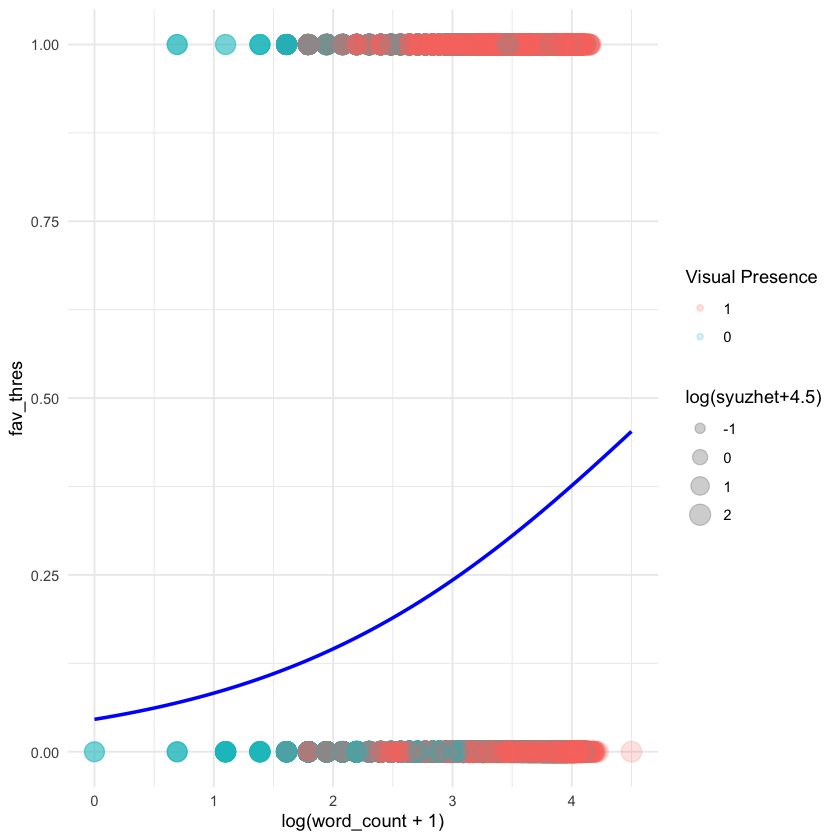

In [98]:
# model 7 plot
ggplot(data, aes(x=log(word_count+1), y=fav_thres)) + 
  geom_point(aes(size=log(syuzhet+4.5), color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  scale_size_continuous(name="log(syuzhet+4.5)") + 
  theme_minimal() 

`geom_smooth()` using formula = 'y ~ x'


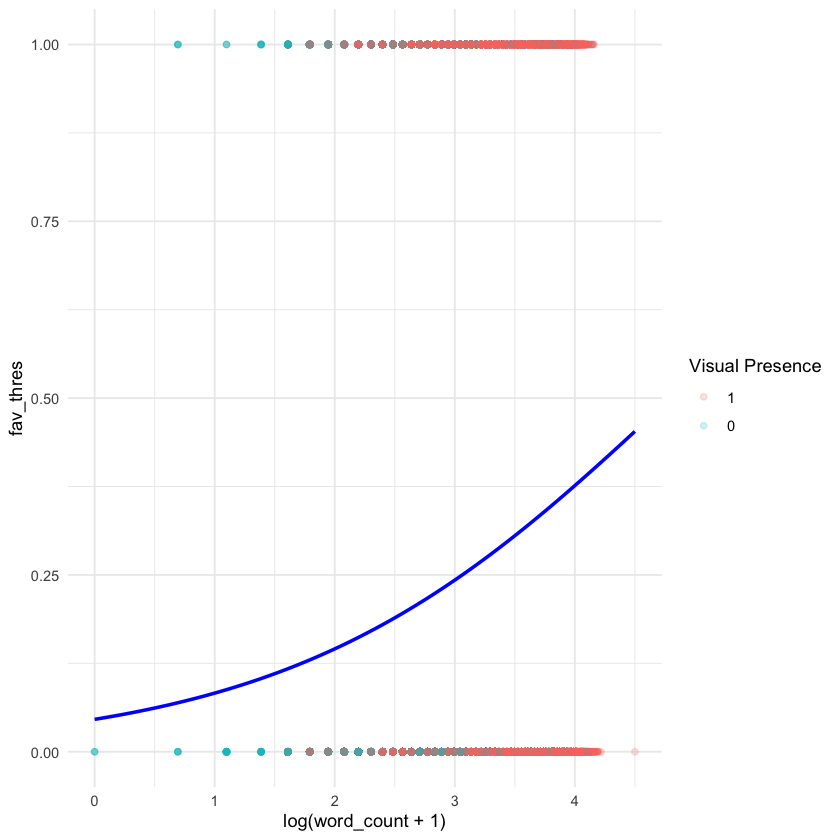

In [99]:
# model 8 plot
ggplot(data, aes(x=log(word_count+1), y=fav_thres)) + 
  geom_point(aes(color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  theme_minimal()

In [100]:
# check multicollinearity
print(vif(glm_mod7))
print(vif(glm_mod8)) 
# we do not seem to have an issue with mulicollinearity in independent variables

log(word_count + 1)  log(syuzhet + 4.5)     visual_presence 
           1.331622            1.190914            1.129286 
log(word_count + 1)     visual_presence 
           1.123478            1.123478 


In [101]:
# =========  y: norm_fav_thres | dataset: data  ========= #

# model 1. X: sqrt(word_count) 
glm_norm_mod1 <- glm(norm_fav_thres~sqrt(word_count), data=data, family = "binomial")

# model 2. X: sqrt(syuzhet) 
glm_norm_mod2 <- glm(norm_fav_thres~sqrt(syuzhet+4.5), data=data, family = "binomial")

# model 3. X: sqrt(word_count), sqrt(syuzhet)
glm_norm_mod3 <- glm(norm_fav_thres~sqrt(word_count)+sqrt(syuzhet+4.5), data=data, family = "binomial")

# model 4. X: sqrt(word_count), sqrt(syuzhet), visual_presence
glm_norm_mod4 <- glm(norm_fav_thres~sqrt(word_count) + sqrt(syuzhet+4.5) + visual_presence, data=data, family = "binomial")

# model 5. X: word_count, syuzhet, visual_presence
glm_norm_mod5 <- glm(norm_fav_thres~word_count + syuzhet + visual_presence, data=data, family = "binomial")

# model 6. X: word_count, visual_presence 
glm_norm_mod6 <- glm(norm_fav_thres~word_count + visual_presence, data=data, family = "binomial")

# model 7. X: log(word_count+1), log(syuzhet+4.5), visual_presence
glm_norm_mod7 <- glm(norm_fav_thres~log(word_count+1) + log(syuzhet+4.5) + visual_presence, data=data, family = "binomial")

# model 8. X: log(word_count+1), visual_presence 
glm_norm_mod8 <- glm(norm_fav_thres~log(word_count+1) + visual_presence, data=data, family = "binomial")

In [102]:
glm_norm_model_names <- paste("glm_norm_mod", 1:8, sep="")
glm_norm_models <- mget(glm_norm_model_names)
glm_eval(glm_norm_models)

AIC      Residual_Deviance
glm_norm_mod1 62466.35 62462.35         
glm_norm_mod2 62732.93 62728.93         
glm_norm_mod3 62405.95 62399.95         
glm_norm_mod4 60620.80 60612.80         
glm_norm_mod5 60618.51 60610.51         
glm_norm_mod6 60635.80 60629.80         
glm_norm_mod7 60614.28 60606.28         
glm_norm_mod8 60622.96 60616.96

`geom_smooth()` using formula = 'y ~ x'


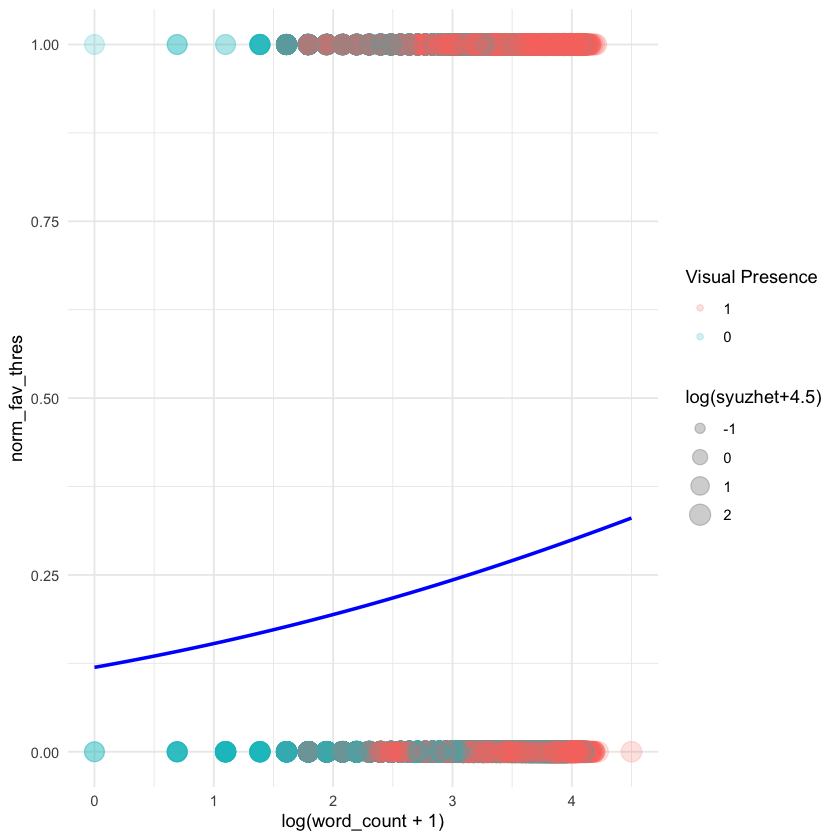

In [103]:
# model 7 plot
ggplot(data, aes(x=log(word_count+1), y=norm_fav_thres)) + 
  geom_point(aes(size=log(syuzhet+4.5), color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  scale_size_continuous(name="log(syuzhet+4.5)") + 
  theme_minimal() 

`geom_smooth()` using formula = 'y ~ x'


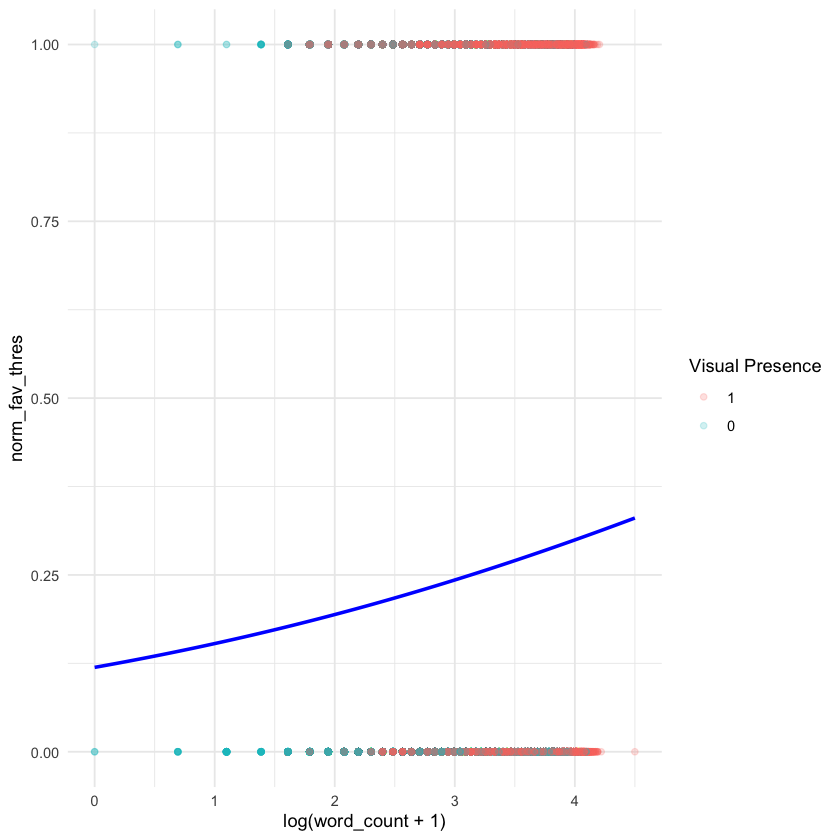

In [104]:
# model 8 plot
ggplot(data, aes(x=log(word_count+1), y=norm_fav_thres)) + 
  geom_point(aes(color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  theme_minimal()

Here, model 7 showed the lowest AIC and residual deviance.
Model 8 also had similarly low numbers.

In model 7, x variables are significant at different level of confidence
- log(word_count + 1) is significant at alpha = 0.05
- log(syuzhet + 4.5) is significant at alpha = 0.01
- visual_presence is significant at alpha = 0.001

In model 8, both log(word_count+1) and visual_presence are significant at 0.001 level.

'visual_presence' is highly significant in both models, implying that this predictor plays an essential role in predicting the outcome.

When comparing the two models, excluding the log(syuzhet + 4.5) variable in glm_norm_mod8 did not lead to a substantial increase in AIC. 

This indicates that the model without this variable might be simpler and nearly as effective.

In both models, the effect of 'word_count' and 'syuzhet' is negative, indicating as these predictors increase, the probability of norm_fav_thres being 1 decreases.

In [105]:
# =========  y: fav_thres | dataset: data_nonzeero ========= #

# model 1. X: sqrt(word_count) 
glm_nzro_mod1 <- glm(fav_thres~sqrt(word_count), data=data_nonzero, family = "binomial")

# model 2. X: sqrt(syuzhet) 
glm_nzro_mod2 <- glm(fav_thres~sqrt(syuzhet+4.5), data=data_nonzero, family = "binomial")

# model 3. X: sqrt(word_count), sqrt(syuzhet)
glm_nzro_mod3 <- glm(fav_thres~sqrt(word_count)+sqrt(syuzhet+4.5), data=data_nonzero, family = "binomial")

# model 4. X: sqrt(word_count), sqrt(syuzhet), visual_presence 
glm_nzro_mod4 <- glm(fav_thres~sqrt(word_count) + sqrt(syuzhet+4.5) + visual_presence, data=data_nonzero, family = "binomial")

# model 5. X: word_count, syuzhet, visual_presence 
glm_nzro_mod5 <- glm(fav_thres~word_count + syuzhet + visual_presence, data=data_nonzero, family = "binomial")

# model 6. X: word_count, visual_presence 
glm_nzro_mod6 <- glm(fav_thres~word_count + visual_presence, data=data_nonzero, family = "binomial")

# model 7. X: log(word_count+1), log(syuzhet+4.5), visual_presence 
glm_nzro_mod7 <- glm(fav_thres~log(word_count+1) + log(syuzhet+4.5) + visual_presence, data=data_nonzero, family = "binomial")

# model 8. X: log(word_count+1), visual_presence 
glm_nzro_mod8 <- glm(fav_thres~log(word_count+1) + visual_presence, data=data_nonzero, family = "binomial")

In [106]:
glm_nonzero_model_names <- paste("glm_nzro_mod", 1:8, sep="")
glm_nonzero_models <- mget(glm_nonzero_model_names)
glm_eval(glm_nonzero_models)

AIC      Residual_Deviance
glm_nzro_mod1 42291.87 42287.87         
glm_nzro_mod2 42314.17 42310.17         
glm_nzro_mod3 42281.05 42275.05         
glm_nzro_mod4 40336.92 40328.92         
glm_nzro_mod5 40343.60 40335.60         
glm_nzro_mod6 40341.70 40335.70         
glm_nzro_mod7 40325.91 40317.91         
glm_nzro_mod8 40323.91 40317.91

`geom_smooth()` using formula = 'y ~ x'


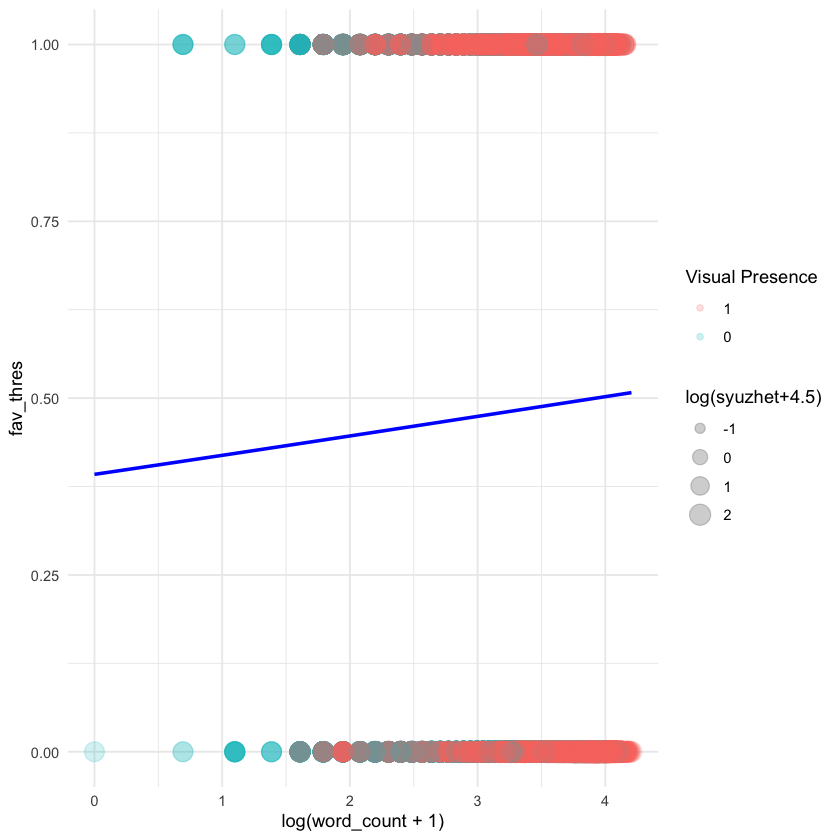

In [107]:
# model 7 plot
ggplot(data_nonzero, aes(x=log(word_count+1), y=fav_thres)) + 
  geom_point(aes(size=log(syuzhet+4.5), color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  scale_size_continuous(name="log(syuzhet+4.5)") + 
  theme_minimal() 

`geom_smooth()` using formula = 'y ~ x'


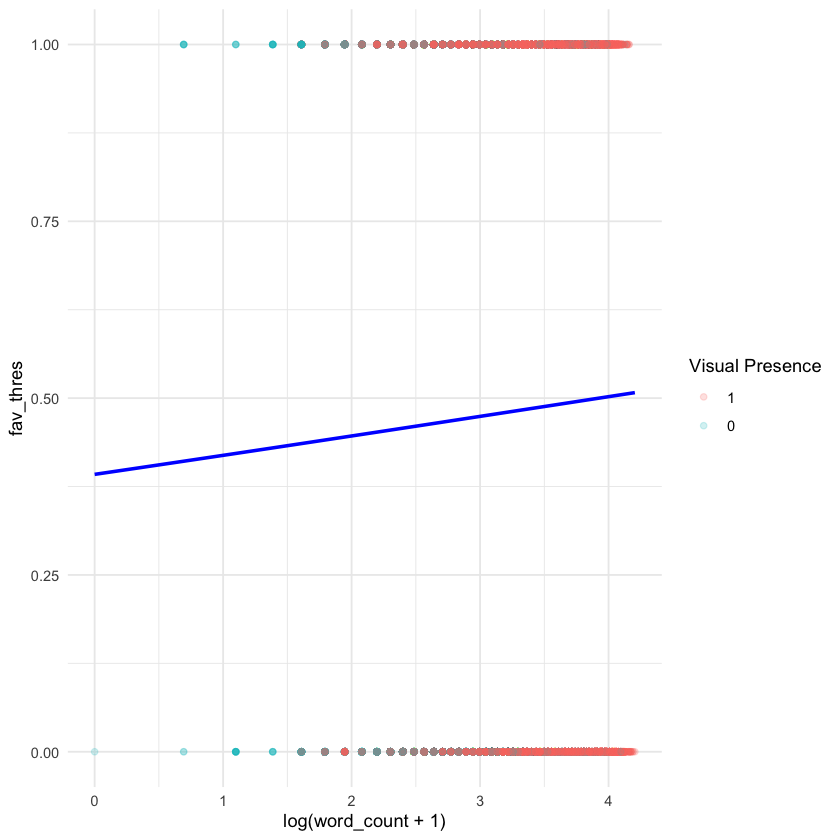

In [108]:
# model 8 plot
ggplot(data_nonzero, aes(x=log(word_count+1), y=fav_thres)) + 
  geom_point(aes(color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  theme_minimal()

Among the logistic regression models using filtered dataset (favorite_count < 100,000 excluding 0s)
The best model based on AIC and residual deviance are model 7 & 8

- 'visual_presence' variable is highly significant in both models, indicating its substantial role in predicting the outcome.
- 'log(syuzhet + 4.5)' variable in model 7 is not statistically significant, suggesting that it might not be an essential predictor in this context.

Both models indicate that as 'word_count' increases, the probability of 'fav_thres' being 1 decreases.

The model 8 is simpler, given it has one less predictor, and its fit is almost identical to model 7, making it potentially a better choice between the two.

In [109]:
# =========  y: norm_fav_thres | dataset: data_nonzero========= #

# model 1. X: sqrt(word_count) 
glm_nzro_norm_mod1 <- glm(norm_fav_thres~sqrt(word_count), data=data_nonzero, family = "binomial")

# model 2. X: sqrt(syuzhet)
glm_nzro_norm_mod2 <- glm(norm_fav_thres~sqrt(syuzhet+4.5), data=data_nonzero, family = "binomial")

# model 3. X: sqrt(word_count), sqrt(syuzhet) 
glm_nzro_norm_mod3 <- glm(norm_fav_thres~sqrt(word_count)+sqrt(syuzhet+4.5), data=data_nonzero, family = "binomial")

# model 4. X: sqrt(word_count), sqrt(syuzhet), visual_presence 
glm_nzro_norm_mod4 <- glm(norm_fav_thres~sqrt(word_count) + sqrt(syuzhet+4.5) + visual_presence, data=data_nonzero, family = "binomial")

# model 5. X: word_count, syuzhet, visual_presence
glm_nzro_norm_mod5 <- glm(norm_fav_thres~word_count + syuzhet + visual_presence, data=data_nonzero, family = "binomial")

# model 6. X: word_count, visual_presence
glm_nzro_norm_mod6 <- glm(norm_fav_thres~word_count + visual_presence, data=data_nonzero, family = "binomial")

# model 7. X: log(word_count+1), log(syuzhet+4.5), visual_presence
glm_nzro_norm_mod7 <- glm(norm_fav_thres~log(word_count+1) + log(syuzhet+4.5) + visual_presence, data=data_nonzero, family = "binomial")

# model 8. X: log(word_count+1), visual_presence
glm_nzro_norm_mod8 <- glm(norm_fav_thres~log(word_count+1) + visual_presence, data=data_nonzero, family = "binomial")

In [110]:
glm_nonzero_norm_model_names <- paste("glm_nzro_norm_mod", 1:8, sep="")
glm_nonzero_norm_models <- mget(glm_nonzero_norm_model_names)
glm_eval(glm_nonzero_norm_models)

AIC      Residual_Deviance
glm_nzro_norm_mod1 34549.79 34545.79         
glm_nzro_norm_mod2 34586.00 34582.00         
glm_nzro_norm_mod3 34547.24 34541.24         
glm_nzro_norm_mod4 34377.26 34369.26         
glm_nzro_norm_mod5 34379.31 34371.31         
glm_nzro_norm_mod6 34377.63 34371.63         
glm_nzro_norm_mod7 34368.56 34360.56         
glm_nzro_norm_mod8 34368.72 34362.72

`geom_smooth()` using formula = 'y ~ x'


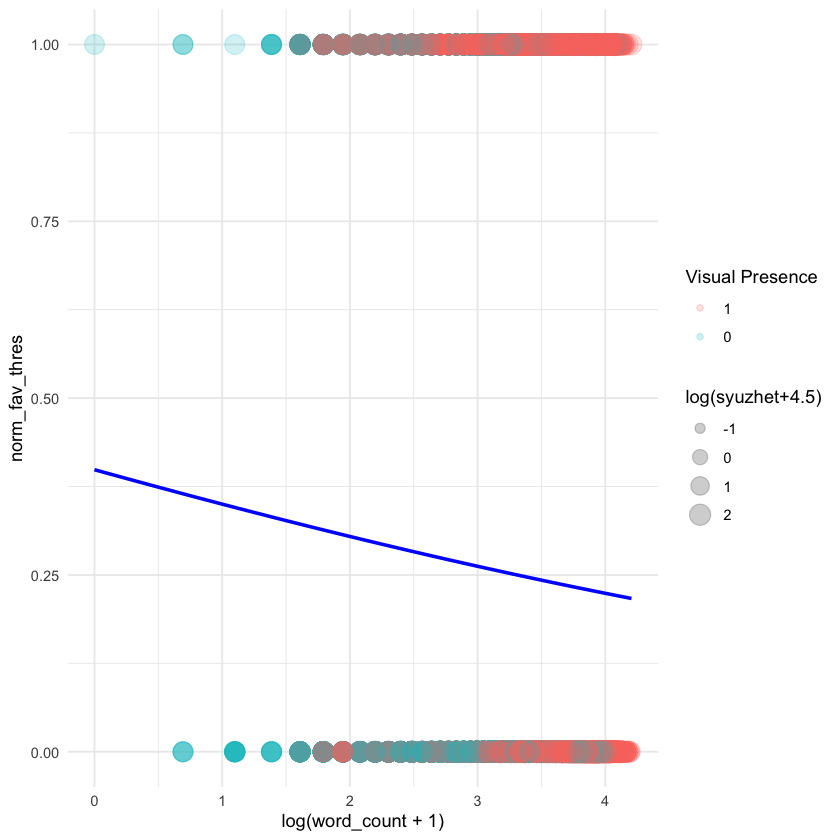

In [111]:
# model 7 plot
ggplot(data_nonzero, aes(x=log(word_count+1), y=norm_fav_thres)) + 
  geom_point(aes(size=log(syuzhet+4.5), color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  scale_size_continuous(name="log(syuzhet+4.5)") + 
  theme_minimal() 

`geom_smooth()` using formula = 'y ~ x'


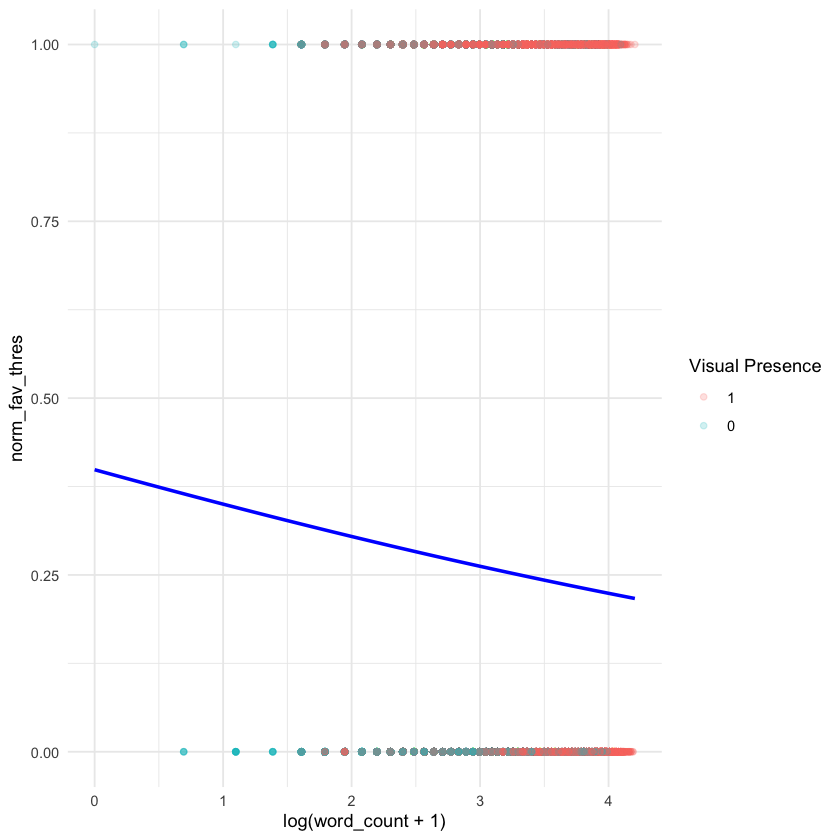

In [112]:
# model 8 plot
ggplot(data_nonzero, aes(x=log(word_count+1), y=norm_fav_thres)) + 
  geom_point(aes(color=as.factor(visual_presence)), alpha=0.2) +
  stat_smooth(method=glm, method.args=list(family = "binomial"), se=FALSE, color="blue") +
  labs(color="Visual Presence") + 
  theme_minimal()


Based on AIC and residual deviance, the best models are model 7 & 8.
- 'log(word_count + 1)' and 'visual_presence' have statistically significant negative effects on the odds of norm_fav_thres being 1. 
- log(syuzhet + 4.5) also has a negative effect, but this predictor's impact is only marginally significant.

The 'glm_nzro_norm_mod8' model is simpler, and its fit is almost identical to glm_nzro_norm_mod7

#### Check more various performance metrics through data split

In [113]:
# split data into train, test set (stratified)
set.seed(1)

train_data_ind <- createDataPartition(data$fav_thres, p = 0.8, list = FALSE, times = 1)

train_data <- data[train_data_ind, ]
test_data <- data[-train_data_ind, ]

In [114]:
glm_eval_detail <- function(models, predictors, actual, threshold) {
    
  acc_values <- numeric(length(models))
  auc_values <- numeric(length(models))
  sensitivity_values <- numeric(length(models))
  specificity_values <- numeric(length(models))
  precision_values <- numeric(length(models))
    
  aic_values <- sapply(models, AIC)
  residual_dev_values <- sapply(models, function(mod) mod$deviance)
  
  for (i in seq_along(models)) {
    model <- models[[i]]
    predicted_probs <- predict(model, newdata = predictors, type = "response")
    predicted_classes <- ifelse(predicted_probs > threshold, 1, 0)
#     confusion_matrix <- table(Predicted = predicted_classes, Actual = actual)
#     acc_values[i] <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
    actual_factor <- factor(actual, levels = c(1, 0)) # added to prevent warning messages
    predicted_classes_factor <- factor(predicted_classes, levels = c(1, 0))

    confusion_matrix <- confusionMatrix(predicted_classes_factor, actual_factor)
#    print(confusion_matrix)
    acc_values[i] <- confusion_matrix$overall['Accuracy']
    sensitivity_values[i] <- confusion_matrix$byClass['Sensitivity']
    specificity_values[i] <- confusion_matrix$byClass['Specificity']
    precision_values[i] <- confusion_matrix$byClass['Precision']

    roc_obj <- pROC::roc(actual, predicted_probs, quiet = TRUE)
    auc_values[i] <- auc(roc_obj)
  }
  
  results_df <- data.frame(
    AIC = aic_values,
    Residual_Deviance = residual_dev_values,
    Accuracy = acc_values,
    Sensitivity = sensitivity_values,
    Specificity = specificity_values,
    Precision = precision_values,
    AUC = auc_values
  )
  
  return(results_df)
}

In [115]:
# # =========  y: fav_thres | dataset: data | null deviance: 64230 ========= #

# # model 1. X: sqrt(word_count) 
glm_mod1 <- glm(fav_thres ~ sqrt_word_count, data = train_data, family = "binomial")

# # model 2. X: sqrt(syuzhet) 
glm_mod2 <- glm(fav_thres ~ sqrt_syuzhet, data = train_data, family = "binomial")

# # model 3. X: sqrt(word_count), sqrt(syuzhet) 
glm_mod3 <- glm(fav_thres ~ sqrt_word_count + sqrt_syuzhet, data = train_data, family = "binomial")

# # model 4. X: sqrt(word_count), sqrt(syuzhet), visual_presence 
glm_mod4 <- glm(fav_thres ~ sqrt_word_count + sqrt_syuzhet + visual_presence, data = train_data, family = "binomial")

# # model 5. X: word_count, syuzhet, visual_presence
glm_mod5 <- glm(fav_thres ~ word_count + syuzhet + visual_presence, data = train_data, family = "binomial")

# # model 6. X: word_count, visual_presence
glm_mod6 <- glm(fav_thres ~ word_count + visual_presence, data = train_data, family = "binomial")

# # model 7. X: log(word_count+1), log(syuzhet+4.5), visual_presence 
glm_mod7 <- glm(fav_thres ~ log_word_count + log_syuzhet + visual_presence, data = train_data, family = "binomial")

# # model 8. X: log(word_count+1), visual_presence 
glm_mod8 <- glm(fav_thres ~ log_word_count + visual_presence, data = train_data, family = "binomial")


In [116]:
glm_model_names <- paste("glm_mod", 1:8, sep="")
glm_models <- mget(glm_model_names)

In [117]:
glm_eval_detail(glm_models, test_data[,-21], test_data[,21], 0.2) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity Precision
glm_mod1 50724.85 50720.85          0.3357612 0.9022609   0.1382488   0.2674227
glm_mod2 51515.12 51511.12          0.2585199 1.0000000   0.0000000   0.2585199
glm_mod3 50630.27 50624.27          0.3360309 0.9026087   0.1384914   0.2675534
glm_mod4 44065.27 44057.27          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod5 44067.90 44059.90          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod6 44070.78 44064.78          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod7 44057.87 44049.87          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod8 44058.79 44052.79          0.6495819 0.8650435   0.5744603   0.4147765
         AUC      
glm_mod1 0.6091364
glm_mod2 0.5167554
glm_mod3 0.6090418
glm_mod4 0.7214735
glm_mod5 0.7213752
glm_mod6 0.7206637
glm_mod7 0.7212233
glm_mod8 0.7206637

In [118]:
glm_eval_detail(glm_models, test_data[,-21], test_data[,21], 0.3) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity Precision
glm_mod1 50724.85 50720.85          0.6747595 0.3360000   0.7928693   0.3612565
glm_mod2 51515.12 51511.12          0.7414801 0.0000000   1.0000000          NA
glm_mod3 50630.27 50624.27          0.6735006 0.3516522   0.7857143   0.3639309
glm_mod4 44065.27 44057.27          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod5 44067.90 44059.90          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod6 44070.78 44064.78          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod7 44057.87 44049.87          0.6495819 0.8650435   0.5744603   0.4147765
glm_mod8 44058.79 44052.79          0.6495819 0.8650435   0.5744603   0.4147765
         AUC      
glm_mod1 0.6091364
glm_mod2 0.5167554
glm_mod3 0.6090418
glm_mod4 0.7214735
glm_mod5 0.7213752
glm_mod6 0.7206637
glm_mod7 0.7212233
glm_mod8 0.7206637

In [119]:
glm_eval_detail(glm_models, test_data[,-21], test_data[,21], 0.4) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity Precision
glm_mod1 50724.85 50720.85          0.7315889 0.01739130  0.9805967   0.2380952
glm_mod2 51515.12 51511.12          0.7414801 0.00000000  1.0000000          NA
glm_mod3 50630.27 50624.27          0.7314090 0.03895652  0.9728353   0.3333333
glm_mod4 44065.27 44057.27          0.6611815 0.81286957  0.6082949   0.4197952
glm_mod5 44067.90 44059.90          0.6613614 0.81008696  0.6095076   0.4197153
glm_mod6 44070.78 44064.78          0.6611815 0.84069565  0.5985933   0.4220360
glm_mod7 44057.87 44049.87          0.6620807 0.81495652  0.6087800   0.4207219
glm_mod8 44058.79 44052.79          0.6566855 0.85147826  0.5887703   0.4192499
         AUC      
glm_mod1 0.6091364
glm_mod2 0.5167554
glm_mod3 0.6090418
glm_mod4 0.7214735
glm_mod5 0.7213752
glm_mod6 0.7206637
glm_mod7 0.7212233
glm_mod8 0.7206637

In [120]:
glm_eval_detail(glm_models, test_data[,-21], test_data[,21], 0.5) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity  Specificity
glm_mod1 50724.85 50720.85          0.7414801 0.0000000000 1.0000000  
glm_mod2 51515.12 51511.12          0.7414801 0.0000000000 1.0000000  
glm_mod3 50630.27 50624.27          0.7414801 0.0006956522 0.9997575  
glm_mod4 44065.27 44057.27          0.7414801 0.0000000000 1.0000000  
glm_mod5 44067.90 44059.90          0.7414801 0.0000000000 1.0000000  
glm_mod6 44070.78 44064.78          0.7414801 0.0000000000 1.0000000  
glm_mod7 44057.87 44049.87          0.7414801 0.0000000000 1.0000000  
glm_mod8 44058.79 44052.79          0.7414801 0.0000000000 1.0000000  
         Precision AUC      
glm_mod1  NA       0.6091364
glm_mod2  NA       0.5167554
glm_mod3 0.5       0.6090418
glm_mod4  NA       0.7214735
glm_mod5  NA       0.7213752
glm_mod6  NA       0.7206637
glm_mod7  NA       0.7212233
glm_mod8  NA       0.7206637

## 4. Final Modeling

Because zero-inflated models will be trained and tested using recent_data including biz_presence & eco_presence, we will do the same for the linear regression & logistic regression models. To compare the performance, we will split the data into train & test sets.

### 4-0. Data Split

In [121]:
set.seed(1)

train_ind <- sample(seq_len(nrow(recent_data)), size = floor(0.8 * nrow(recent_data)))

recent_data_train <- recent_data[train_ind, ]
recent_data_test <- recent_data[-train_ind, ]

### 4-1. Linear Regression w/ recent_data

In [122]:
lm_eval <- function(models, y_ind) {
    results <- sapply(models, function(mod) {
        actual_values <- recent_data_test[, y_ind]
        predicted <- predict(mod, newdata = recent_data_test)
        # undo transformation for predicted values
        y_variable <- as.character(formula(mod)[[2]])        
        if (grepl("sqrt", y_variable)) {
            predicted_values <- (predicted^2) - 1
        } else if (grepl("log", y_variable)){
            predicted_values <- exp(predicted) - 1
        } else {
            predicted_values <- predicted
        }
        
        mse <- mean((actual_values - predicted_values)^2)
        rmse <- sqrt(mse)
        mae <- mean(abs(actual_values - predicted_values))
        r2 <- summary(mod)$r.squared
        adj_r2 <- summary(mod)$adj.r.squared
        aic <- AIC(mod)
        log_likelihood <- logLik(mod)
        c(RMSE = rmse, MAE = mae, R_Squared = r2, Adjusted_R_Squared = adj_r2, AIC = aic, Log_Likelihood = log_likelihood)
    })
    
    model_stats <- data.frame(t(results))
    
    return(model_stats)
}

In [123]:
# ========= w/ recent data

# ========= linear regression models w/ 'scaled_norm_fav' as Y variable ========= #

# model 1. linear-linear
recent_lm_mod1 <- lm(scaled_norm_fav ~ word_count + syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 2. linear-linear | visual_presence only
recent_lm_mod2 <- lm(scaled_norm_fav ~ visual_presence, data = recent_data_train)

# model 3. linear-log
recent_lm_mod3 <- lm(scaled_norm_fav ~ log_word_count + log_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 4. linear-sqrt
recent_lm_mod4 <- lm(scaled_norm_fav ~ sqrt_word_count + sqrt_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 5. log-linear
recent_lm_mod5 <- lm(log_scaled_norm_fav ~ word_count + syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 6. log-linear | visual_presence only
recent_lm_mod6 <- lm(log_scaled_norm_fav ~ visual_presence, data = recent_data_train)

# model 7. log-log
recent_lm_mod7 <- lm(log_scaled_norm_fav ~ log_word_count + log_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 8. log-sqrt
recent_lm_mod8 <- lm(log_scaled_norm_fav ~ sqrt_word_count + sqrt_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 9. sqrt-linear
recent_lm_mod9 <- lm(sqrt_scaled_norm_fav ~  word_count + syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 10. sqrt-log
recent_lm_mod10 <- lm(sqrt_scaled_norm_fav ~  log_word_count + log_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 11. sqrt-sqrt
recent_lm_mod11 <- lm(sqrt_scaled_norm_fav ~ sqrt_word_count + sqrt_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

In [124]:
which(names(recent_data_test) == 'scaled_norm_fav')

[1] 20

In [125]:
# performance comparison
recent_lm_model_names <- paste("recent_lm_mod", 1:11, sep="")
recent_lm_models <- mget(recent_lm_model_names)
lm_eval(recent_lm_models, 20) # scaled_norm_fav column index = 20

RMSE     MAE       R_Squared    Adjusted_R_Squared AIC      
recent_lm_mod1  1.837456 1.2280990 0.0016030254 -2.630745e-06      23191.654
recent_lm_mod2  1.837254 1.2264514 0.0013404644  1.019661e-03      23184.473
recent_lm_mod3  1.841186 1.2320717 0.0015292934 -7.648131e-05      23191.884
recent_lm_mod4  1.839516 1.2302031 0.0015607688 -4.495531e-05      23191.785
recent_lm_mod5  1.826151 0.8760155 0.0072352501  5.638652e-03       5695.639
recent_lm_mod6  1.826964 0.8763005 0.0059207326  5.601401e-03       5691.761
recent_lm_mod7  1.826778 0.8755141 0.0076199378  6.023958e-03       5694.432
recent_lm_mod8  1.826662 0.8758525 0.0073373178  5.740884e-03       5695.319
recent_lm_mod9  1.797780 0.9580077 0.0011772082 -4.291328e-04       6470.548
recent_lm_mod10 1.799347 0.9578198 0.0009090667 -6.977055e-04       6471.384
recent_lm_mod11 1.798833 0.9580696 0.0009691883 -6.374871e-04       6471.197
                Log_Likelihood
recent_lm_mod1  -11588.827    
recent_lm_mod2  -11589.236    
recent_lm_mod3  -11588.942    
recent_lm_mod4  -11588.893    
recent_lm_mod5   -2840.820    
recent_lm_mod6   -2842.881    
recent_lm_mod7   -2840.216    
recent_lm_mod8   -2840.659    
recent_lm_mod9   -3228.274    
recent_lm_mod10  -3228.692    
recent_lm_mod11  -3228.598

In [126]:
summary(recent_lm_mod7)


Call:
lm(formula = log_scaled_norm_fav ~ log_word_count + log_syuzhet + 
    visual_presence + biz_presence + eco_presence, data = recent_data_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4017 -0.3348 -0.2898  0.3289  6.0094 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.482108   0.113778   4.237 2.33e-05 ***
log_word_count   -0.026056   0.023004  -1.133    0.257    
log_syuzhet      -0.004572   0.059247  -0.077    0.938    
visual_presence0 -0.108020   0.024579  -4.395 1.15e-05 ***
biz_presence0    -0.036825   0.023585  -1.561    0.119    
eco_presence0    -0.043494   0.025159  -1.729    0.084 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6028 on 3109 degrees of freedom
Multiple R-squared:  0.00762,	Adjusted R-squared:  0.006024 
F-statistic: 4.774 on 5 and 3109 DF,  p-value: 0.000238


In [127]:
vif(recent_lm_mod7)

log_word_count     log_syuzhet visual_presence    biz_presence    eco_presence 
       1.420782        1.319647        1.059767        1.191731        1.070352

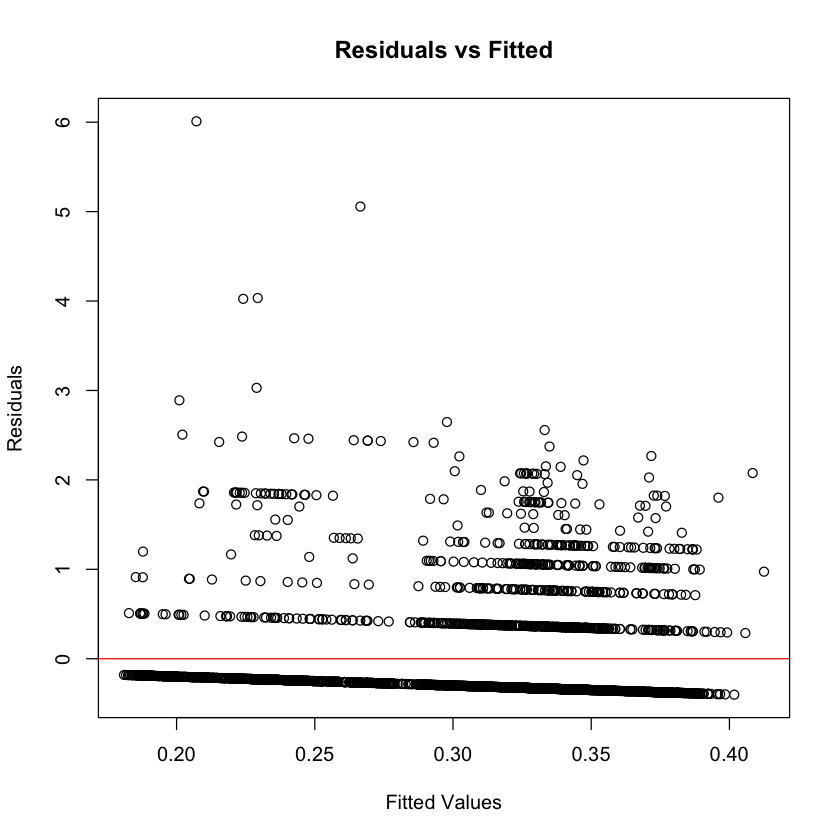

In [128]:
# recent_lm_mod7 residuals vs fitted plot
plot(recent_lm_mod7$fitted.values, resid(recent_lm_mod7),
     xlab = "Fitted Values",
     ylab = "Residuals",
     main = "Residuals vs Fitted")
abline(h = 0, col = "red")

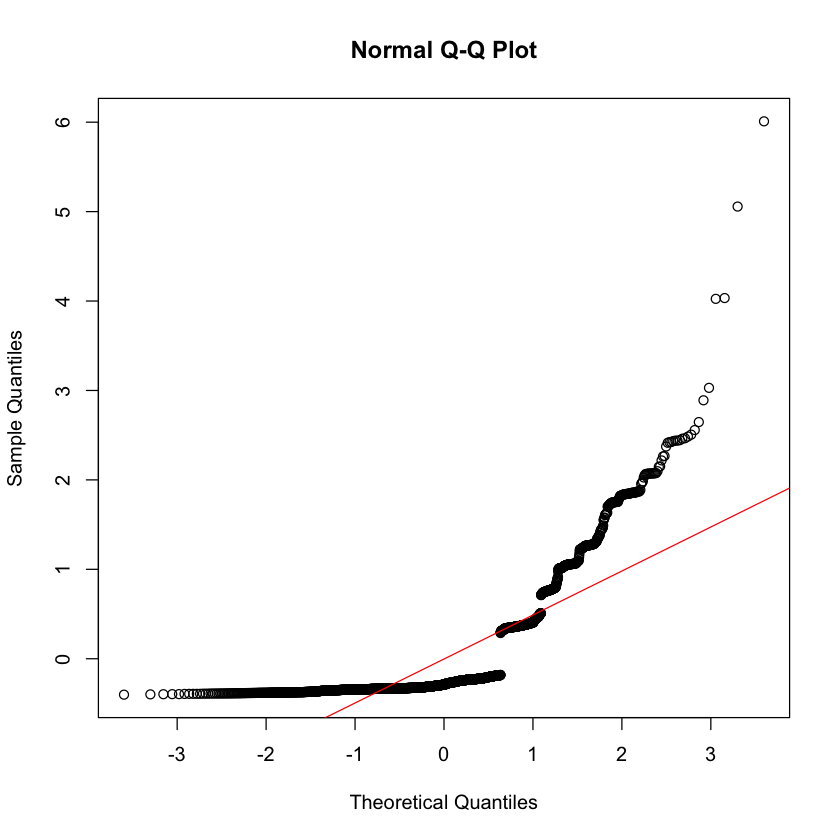

In [129]:
# recent_lm_mod7 Q-Q plot
qqnorm(resid(recent_lm_mod7))
qqline(resid(recent_lm_mod7), col = "red")

In [130]:
# ========= linear regression models w/ 'favorite_count' as Y variable ========= #

# model 1. linear-linear
fav_recent_lm_mod1 <- lm(favorite_count ~ word_count + syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 2. linear-linear | visual_presence only
fav_recent_lm_mod2 <- lm(favorite_count ~ visual_presence, data = recent_data_train)

# model 3. linear-log
fav_recent_lm_mod3 <- lm(favorite_count ~ log_word_count + log_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 4. linear-sqrt
fav_recent_lm_mod4 <- lm(favorite_count ~ sqrt_word_count + sqrt_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 5. log-linear
fav_recent_lm_mod5 <- lm(log_favorite_count ~ word_count + syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 6. log-linear | visual_presence only
fav_recent_lm_mod6 <- lm(log_favorite_count ~ visual_presence, data = recent_data_train)

# model 7. log-log
fav_recent_lm_mod7 <- lm(log_favorite_count ~ log_word_count + log_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 8. log-sqrt
fav_recent_lm_mod8 <- lm(log_favorite_count ~ sqrt_word_count + sqrt_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 9. sqrt-linear
fav_recent_lm_mod9 <- lm(sqrt_favorite_count ~  word_count + syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 10. sqrt-log
fav_recent_lm_mod10 <- lm(sqrt_favorite_count ~  log_word_count + log_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

# model 11. sqrt-sqrt
fav_recent_lm_mod11 <- lm(sqrt_favorite_count ~ sqrt_word_count + sqrt_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train)

In [131]:
which(names(recent_data_test) == 'favorite_count')

[1] 5

In [132]:
# performance comparison
fav_recent_lm_model_names <- paste("fav_recent_lm_mod", 1:11, sep="")
fav_recent_lm_models <- mget(fav_recent_lm_model_names)
lm_eval(fav_recent_lm_models, 5) # favorite_count column index = 5

RMSE     MAE       R_Squared   Adjusted_R_Squared AIC     
fav_recent_lm_mod1  226.4113 121.63196 0.002233280 0.0006286377       57337.33
fav_recent_lm_mod2  216.0378 111.52993 0.001712793 0.0013921093       57330.96
fav_recent_lm_mod3  224.3710 118.01432 0.002100789 0.0004959338       57337.75
fav_recent_lm_mod4  225.1612 119.48152 0.002151429 0.0005466545       57337.59
fav_recent_lm_mod5  180.8157  30.56567 0.037329045 0.0357808448       12066.40
fav_recent_lm_mod6  180.9647  30.66882 0.010247760 0.0099298182       12144.82
fav_recent_lm_mod7  180.8342  30.56237 0.040093206 0.0385494512       12057.44
fav_recent_lm_mod8  180.8239  30.56165 0.038595298 0.0370491336       12062.30
fav_recent_lm_mod9  179.3329  34.88678 0.004777349 0.0031767975       23175.51
fav_recent_lm_mod10 179.3824  34.85281 0.004802460 0.0032019493       23175.43
fav_recent_lm_mod11 179.3497  34.86750 0.004707257 0.0031065937       23175.73
                    Log_Likelihood
fav_recent_lm_mod1  -28661.667    
fav_recent_lm_mod2  -28662.479    
fav_recent_lm_mod3  -28661.873    
fav_recent_lm_mod4  -28661.794    
fav_recent_lm_mod5   -6026.198    
fav_recent_lm_mod6   -6069.408    
fav_recent_lm_mod7   -6021.720    
fav_recent_lm_mod8   -6024.148    
fav_recent_lm_mod9  -11580.755    
fav_recent_lm_mod10 -11580.715    
fav_recent_lm_mod11 -11580.864

In [133]:
summary(fav_recent_lm_mod7)


Call:
lm(formula = log_favorite_count ~ log_word_count + log_syuzhet + 
    visual_presence + biz_presence + eco_presence, data = recent_data_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2541 -1.2323 -0.5180  0.8693 10.9781 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.86085    0.31595   5.890 4.28e-09 ***
log_word_count   -0.23437    0.06388  -3.669 0.000248 ***
log_syuzhet       0.11351    0.16453   0.690 0.490292    
visual_presence0 -0.44187    0.06825  -6.474 1.11e-10 ***
biz_presence0     0.32075    0.06549   4.898 1.02e-06 ***
eco_presence0     0.35778    0.06987   5.121 3.23e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.674 on 3109 degrees of freedom
Multiple R-squared:  0.04009,	Adjusted R-squared:  0.03855 
F-statistic: 25.97 on 5 and 3109 DF,  p-value: < 2.2e-16


In [134]:
vif(fav_recent_lm_mod7)

log_word_count     log_syuzhet visual_presence    biz_presence    eco_presence 
       1.420782        1.319647        1.059767        1.191731        1.070352

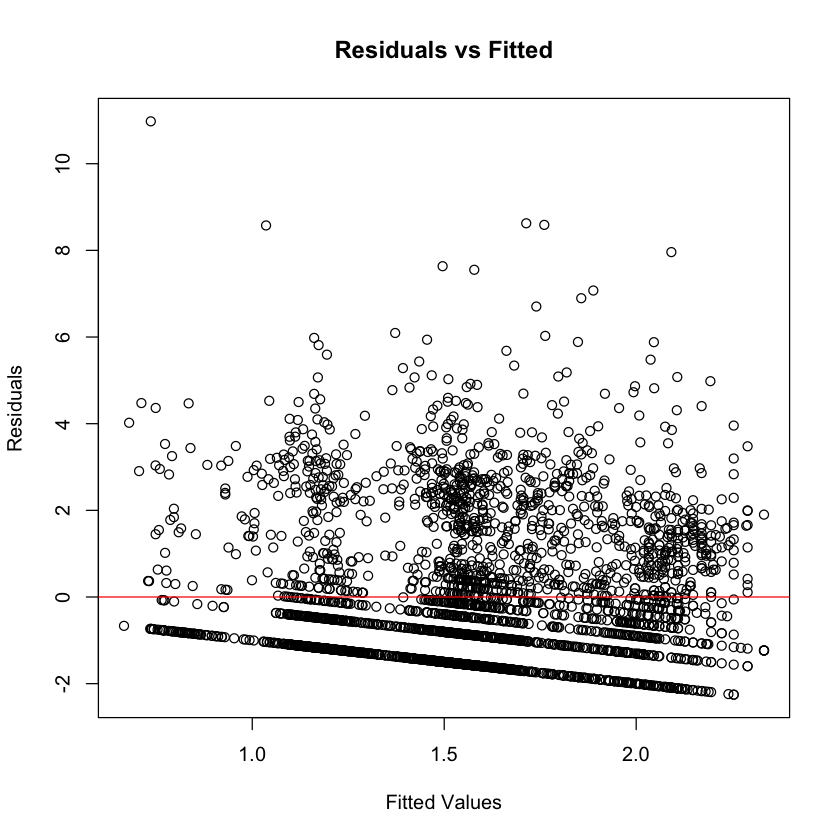

In [135]:
# fav_recent_lm_mod7 residuals vs fitted plot
plot(fav_recent_lm_mod7$fitted.values, resid(fav_recent_lm_mod7),
     xlab = "Fitted Values",
     ylab = "Residuals",
     main = "Residuals vs Fitted")
abline(h = 0, col = "red")

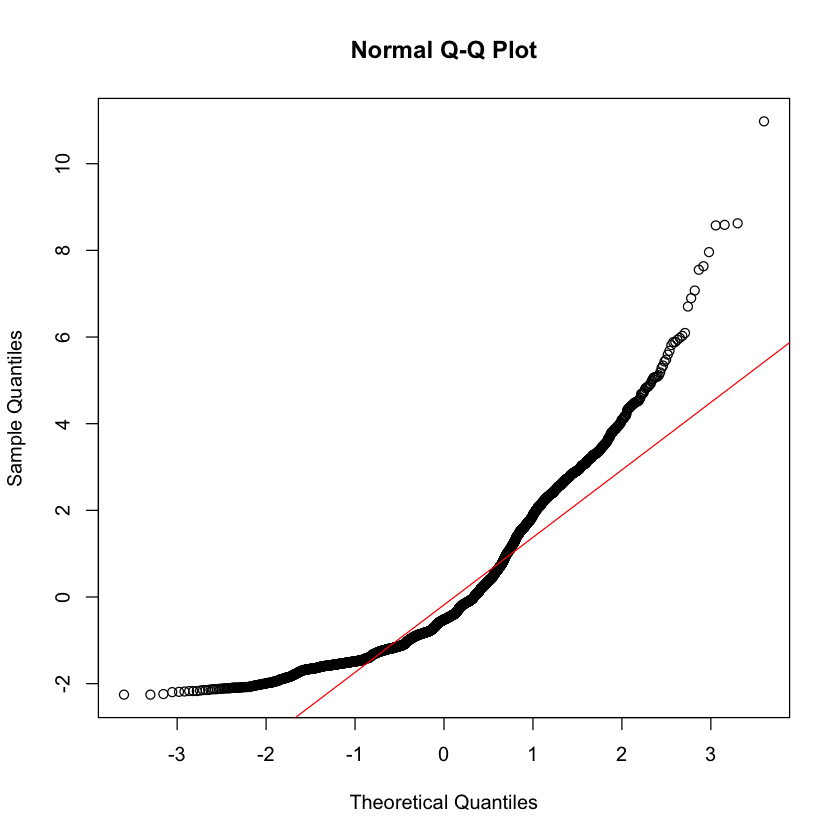

In [136]:
# fav_recent_lm_mod7 Q-Q plot
qqnorm(resid(fav_recent_lm_mod7))
qqline(resid(fav_recent_lm_mod7), col = "red")

### 4-2. Logistic Regression w/ recent_data

In [137]:
glm_eval_detail <- function(models, predictors, actual, threshold) {
    
  acc_values <- numeric(length(models))
  auc_values <- numeric(length(models))
  sensitivity_values <- numeric(length(models))
  specificity_values <- numeric(length(models))
  precision_values <- numeric(length(models))
  f1_scores <- numeric(length(models))
  logLik_values <- numeric(length(models))
  pseudoR2_values <- numeric(length(models))
  adjR2_values <- numeric(length(models))
    
  aic_values <- sapply(models, AIC)
  residual_dev_values <- sapply(models, function(mod) mod$deviance)
  
  for (i in seq_along(models)) {
    model <- models[[i]]
    predicted_probs <- predict(model, newdata = predictors, type = "response")
    predicted_classes <- ifelse(predicted_probs > threshold, 1, 0)
    
    actual_factor <- factor(actual, levels = c(1, 0)) # added to prevent warning messages
    predicted_classes_factor <- factor(predicted_classes, levels = c(1, 0))

    confusion_matrix <- caret::confusionMatrix(predicted_classes_factor, actual_factor)
    acc_values[i] <- confusion_matrix$overall['Accuracy']
    sensitivity_values[i] <- confusion_matrix$byClass['Sensitivity']
    specificity_values[i] <- confusion_matrix$byClass['Specificity']
    precision_values[i] <- confusion_matrix$byClass['Precision']
    f1_scores[i] <- 2 * (precision_values[i] * sensitivity_values[i]) / (precision_values[i] + sensitivity_values[i])
    roc_obj <- pROC::roc(actual, predicted_probs, quiet = TRUE)
    auc_values[i] <- pROC::auc(roc_obj)
    
    # log likelihood
    logLik_values[i] <- logLik(model)
    
    # pseudo R-squared
    null_deviance <- model$null.deviance
    residual_deviance <- model$deviance
    pseudoR2_values[i] <- 1 - (residual_deviance/null_deviance)
    
    # adjusted R-squared
    n <- length(actual)
    p <- length(model$coefficients) - 1
    adjR2_values[i] <- 1 - ((1 - pseudoR2_values[i]) * (n - 1) / (n - p - 1))
  }
  
  results_df <- data.frame(
    AIC = aic_values,
    Residual_Deviance = residual_dev_values,
    Accuracy = acc_values,
    Sensitivity = sensitivity_values,
    Specificity = specificity_values,
    Precision = precision_values,
    F1_Score = f1_scores, 
    AUC = auc_values,
    Log_Likelihood = logLik_values,
    Pseudo_R2 = pseudoR2_values,
    Adjusted_R2 = adjR2_values
  )
  
  return(results_df)
}


In [138]:
# # =========  y: fav_thres | dataset: recent_data_train  ========= #

# model 1. X: all
glm_mod1 <- glm(fav_thres ~ word_count + syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train, family = "binomial")

# model 2. X: all except syuzhet
glm_mod2 <- glm(fav_thres ~ word_count + visual_presence + biz_presence + eco_presence, data = recent_data_train, family = "binomial")

# model 3. X: word_count, syuzhet, visual_presence
glm_mod3 <- glm(fav_thres ~ word_count + syuzhet + visual_presence, data = recent_data_train, family = "binomial")

# model 4. X: word_count, visual_presence
glm_mod4 <- glm(fav_thres ~ word_count + visual_presence, data = recent_data_train, family = "binomial")

# model 5. X: all w/ log_word_count & log_syuzhet
glm_mod5 <- glm(fav_thres ~ log_word_count + log_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train, family = "binomial")

# model 6. X: all w/ log_word_count, except syuzhet
glm_mod6 <- glm(fav_thres ~ log_word_count + visual_presence + biz_presence + eco_presence, data = recent_data_train, family = "binomial")

# model 7. X: log_word_count, visual_presence 
glm_mod7 <- glm(fav_thres ~ log_word_count + visual_presence, data = recent_data_train, family = "binomial")

# model 8. X: all w/ sqrt_word_count & sqrt_syuzhet
glm_mod8 <- glm(fav_thres ~ sqrt_word_count + sqrt_syuzhet + visual_presence + biz_presence + eco_presence, data = recent_data_train, family = "binomial")

# model 9. X: all w/ sqrt_word_count, except syuzhet
glm_mod9 <- glm(fav_thres ~ sqrt_word_count + visual_presence + biz_presence + eco_presence, data = recent_data_train, family = "binomial")

# model 10. X: sqrt_word_count, visual_presence 
glm_mod10 <- glm(fav_thres ~ sqrt_word_count + visual_presence, data = recent_data_train, family = "binomial")

In [139]:
which(names(recent_data_test) == 'fav_thres')

[1] 21

In [140]:
glm_model_names <- paste("glm_mod", 1:10, sep="")
glm_models <- mget(glm_model_names)

In [141]:
glm_eval_detail(glm_models, recent_data_test[,-21], recent_data_test[,21], 0.2) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity
glm_mod1  4010.395 3998.395          0.4159178 0.9739414   0.05296610 
glm_mod2  4010.015 4000.015          0.4146341 0.9739414   0.05084746 
glm_mod3  4043.942 4035.942          0.4069320 0.9837134   0.03177966 
glm_mod4  4042.013 4036.013          0.4043646 0.9869707   0.02542373 
glm_mod5  3997.736 3985.736          0.4210526 0.9739414   0.06144068 
glm_mod6  3998.130 3988.130          0.4146341 0.9739414   0.05084746 
glm_mod7  4023.574 4017.574          0.4082157 0.9771987   0.03813559 
glm_mod8  4003.348 3991.348          0.4172015 0.9706840   0.05720339 
glm_mod9  4003.570 3993.570          0.4146341 0.9739414   0.05084746 
glm_mod10 4031.311 4025.311          0.4082157 0.9771987   0.03813559 
          Precision F1_Score  AUC       Log_Likelihood Pseudo_R2  Adjusted_R2
glm_mod1  0.4008043 0.5679012 0.6621073 -1999.197      0.04175631 0.03555810 
glm_mod2  0.4002677 0.5673624 0.6610273 -2000.008      0.04136792 0.03641375 
glm_mod3  0.3978920 0.5666041 0.6476840 -2017.971      0.03275788 0.02901372 
glm_mod4  0.3971166 0.5663551 0.6475736 -2018.007      0.03274075 0.03024781 
glm_mod5  0.4029650 0.5700667 0.6581599 -1992.868      0.04478997 0.03861138 
glm_mod6  0.4002677 0.5673624 0.6579425 -1994.065      0.04421631 0.03927686 
glm_mod7  0.3978780 0.5655042 0.6371529 -2008.787      0.03715975 0.03467820 
glm_mod8  0.4010767 0.5676190 0.6597885 -1995.674      0.04344517 0.03725788 
glm_mod9  0.4002677 0.5673624 0.6596264 -1996.785      0.04291251 0.03796632 
glm_mod10 0.3978780 0.5655042 0.6421424 -2012.656      0.03530555 0.03281923

In [142]:
glm_eval_detail(glm_models, recent_data_test[,-21], recent_data_test[,21], 0.3) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity
glm_mod1  4010.395 3998.395          0.5160462 0.8599349   0.2923729  
glm_mod2  4010.015 4000.015          0.5211810 0.8664495   0.2966102  
glm_mod3  4043.942 4035.942          0.4993582 0.9087948   0.2330508  
glm_mod4  4042.013 4036.013          0.4967908 0.9055375   0.2309322  
glm_mod5  3997.736 3985.736          0.5186136 0.8501629   0.3029661  
glm_mod6  3998.130 3988.130          0.5224647 0.8566775   0.3050847  
glm_mod7  4023.574 4017.574          0.5109114 0.8990228   0.2584746  
glm_mod8  4003.348 3991.348          0.5160462 0.8534202   0.2966102  
glm_mod9  4003.570 3993.570          0.5237484 0.8566775   0.3072034  
glm_mod10 4031.311 4025.311          0.4955071 0.9055375   0.2288136  
          Precision F1_Score  AUC       Log_Likelihood Pseudo_R2  Adjusted_R2
glm_mod1  0.4414716 0.5834254 0.6621073 -1999.197      0.04175631 0.03555810 
glm_mod2  0.4448161 0.5878453 0.6610273 -2000.008      0.04136792 0.03641375 
glm_mod3  0.4352574 0.5886076 0.6476840 -2017.971      0.03275788 0.02901372 
glm_mod4  0.4336973 0.5864979 0.6475736 -2018.007      0.03274075 0.03024781 
glm_mod5  0.4423729 0.5819398 0.6581599 -1992.868      0.04478997 0.03861138 
glm_mod6  0.4450085 0.5857461 0.6579425 -1994.065      0.04421631 0.03927686 
glm_mod7  0.4408946 0.5916399 0.6371529 -2008.787      0.03715975 0.03467820 
glm_mod8  0.4410774 0.5815760 0.6597885 -1995.674      0.04344517 0.03725788 
glm_mod9  0.4457627 0.5863991 0.6596264 -1996.785      0.04291251 0.03796632 
glm_mod10 0.4330218 0.5858799 0.6421424 -2012.656      0.03530555 0.03281923

In [143]:
glm_eval_detail(glm_models, recent_data_test[,-21], recent_data_test[,21], 0.4) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity
glm_mod1  4010.395 3998.395          0.6174583 0.6156352   0.6186441  
glm_mod2  4010.015 4000.015          0.6110398 0.5895765   0.6250000  
glm_mod3  4043.942 4035.942          0.5994865 0.5863192   0.6080508  
glm_mod4  4042.013 4036.013          0.5969191 0.5700326   0.6144068  
glm_mod5  3997.736 3985.736          0.6174583 0.6221498   0.6144068  
glm_mod6  3998.130 3988.130          0.6071887 0.5732899   0.6292373  
glm_mod7  4023.574 4017.574          0.5892169 0.5504886   0.6144068  
glm_mod8  4003.348 3991.348          0.6161746 0.6221498   0.6122881  
glm_mod9  4003.570 3993.570          0.6059050 0.5798046   0.6228814  
glm_mod10 4031.311 4025.311          0.5879332 0.5537459   0.6101695  
          Precision F1_Score  AUC       Log_Likelihood Pseudo_R2  Adjusted_R2
glm_mod1  0.5121951 0.5591716 0.6621073 -1999.197      0.04175631 0.03555810 
glm_mod2  0.5055866 0.5443609 0.6610273 -2000.008      0.04136792 0.03641375 
glm_mod3  0.4931507 0.5357143 0.6476840 -2017.971      0.03275788 0.02901372 
glm_mod4  0.4901961 0.5271084 0.6475736 -2018.007      0.03274075 0.03024781 
glm_mod5  0.5120643 0.5617647 0.6581599 -1992.868      0.04478997 0.03861138 
glm_mod6  0.5014245 0.5349544 0.6579425 -1994.065      0.04421631 0.03927686 
glm_mod7  0.4814815 0.5136778 0.6371529 -2008.787      0.03715975 0.03467820 
glm_mod8  0.5106952 0.5609398 0.6597885 -1995.674      0.04344517 0.03725788 
glm_mod9  0.5000000 0.5369532 0.6596264 -1996.785      0.04291251 0.03796632 
glm_mod10 0.4802260 0.5143722 0.6421424 -2012.656      0.03530555 0.03281923

In [144]:
glm_eval_detail(glm_models, recent_data_test[,-21], recent_data_test[,21], 0.5) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity
glm_mod1  4010.395 3998.395          0.6534018 0.3420195   0.8559322  
glm_mod2  4010.015 4000.015          0.6546855 0.3485342   0.8538136  
glm_mod3  4043.942 4035.942          0.6392811 0.3094463   0.8538136  
glm_mod4  4042.013 4036.013          0.6392811 0.3094463   0.8538136  
glm_mod5  3997.736 3985.736          0.6546855 0.3322476   0.8644068  
glm_mod6  3998.130 3988.130          0.6649551 0.3485342   0.8707627  
glm_mod7  4023.574 4017.574          0.6444159 0.2703583   0.8877119  
glm_mod8  4003.348 3991.348          0.6559692 0.3322476   0.8665254  
glm_mod9  4003.570 3993.570          0.6611040 0.3517915   0.8622881  
glm_mod10 4031.311 4025.311          0.6482670 0.2964169   0.8771186  
          Precision F1_Score  AUC       Log_Likelihood Pseudo_R2  Adjusted_R2
glm_mod1  0.6069364 0.4375000 0.6621073 -1999.197      0.04175631 0.03555810 
glm_mod2  0.6079545 0.4430642 0.6610273 -2000.008      0.04136792 0.03641375 
glm_mod3  0.5792683 0.4033970 0.6476840 -2017.971      0.03275788 0.02901372 
glm_mod4  0.5792683 0.4033970 0.6475736 -2018.007      0.03274075 0.03024781 
glm_mod5  0.6144578 0.4312896 0.6581599 -1992.868      0.04478997 0.03861138 
glm_mod6  0.6369048 0.4505263 0.6579425 -1994.065      0.04421631 0.03927686 
glm_mod7  0.6102941 0.3747178 0.6371529 -2008.787      0.03715975 0.03467820 
glm_mod8  0.6181818 0.4322034 0.6597885 -1995.674      0.04344517 0.03725788 
glm_mod9  0.6242775 0.4500000 0.6596264 -1996.785      0.04291251 0.03796632 
glm_mod10 0.6107383 0.3991228 0.6421424 -2012.656      0.03530555 0.03281923

In [145]:
glm_eval_detail(glm_models, recent_data_test[,-21], recent_data_test[,21], 0.6) # fav_thres index = 21

AIC      Residual_Deviance Accuracy  Sensitivity Specificity
glm_mod1  4010.395 3998.395          0.6071887 0.006514658 0.9978814  
glm_mod2  4010.015 4000.015          0.6071887 0.006514658 0.9978814  
glm_mod3  4043.942 4035.942          0.6059050 0.000000000 1.0000000  
glm_mod4  4042.013 4036.013          0.6059050 0.000000000 1.0000000  
glm_mod5  3997.736 3985.736          0.6020539 0.039087948 0.9682203  
glm_mod6  3998.130 3988.130          0.5994865 0.029315961 0.9703390  
glm_mod7  4023.574 4017.574          0.6020539 0.013029316 0.9851695  
glm_mod8  4003.348 3991.348          0.6033376 0.022801303 0.9809322  
glm_mod9  4003.570 3993.570          0.6046213 0.016286645 0.9872881  
glm_mod10 4031.311 4025.311          0.6059050 0.009771987 0.9936441  
          Precision F1_Score   AUC       Log_Likelihood Pseudo_R2  Adjusted_R2
glm_mod1  0.6666667 0.01290323 0.6621073 -1999.197      0.04175631 0.03555810 
glm_mod2  0.6666667 0.01290323 0.6610273 -2000.008      0.04136792 0.03641375 
glm_mod3         NA         NA 0.6476840 -2017.971      0.03275788 0.02901372 
glm_mod4         NA         NA 0.6475736 -2018.007      0.03274075 0.03024781 
glm_mod5  0.4444444 0.07185629 0.6581599 -1992.868      0.04478997 0.03861138 
glm_mod6  0.3913043 0.05454545 0.6579425 -1994.065      0.04421631 0.03927686 
glm_mod7  0.3636364 0.02515723 0.6371529 -2008.787      0.03715975 0.03467820 
glm_mod8  0.4375000 0.04334365 0.6597885 -1995.674      0.04344517 0.03725788 
glm_mod9  0.4545455 0.03144654 0.6596264 -1996.785      0.04291251 0.03796632 
glm_mod10 0.5000000 0.01916933 0.6421424 -2012.656      0.03530555 0.03281923

In [146]:
summary(glm_mod1)


Call:
glm(formula = fav_thres ~ word_count + syuzhet + visual_presence + 
    biz_presence + eco_presence, family = "binomial", data = recent_data_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3657  -0.9899  -0.7815   1.2153   1.9943  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.270269   0.149724  -1.805   0.0711 .  
word_count       -0.016657   0.003287  -5.068 4.03e-07 ***
syuzhet           0.045578   0.035769   1.274   0.2026    
visual_presence0 -0.833846   0.089990  -9.266  < 2e-16 ***
biz_presence0     0.321198   0.082025   3.916 9.01e-05 ***
eco_presence0     0.444925   0.090401   4.922 8.58e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4172.6  on 3114  degrees of freedom
Residual deviance: 3998.4  on 3109  degrees of freedom
AIC: 4010.4

Number of Fisher Scoring iterations: 4


In [147]:
summary(glm_mod2)


Call:
glm(formula = fav_thres ~ word_count + visual_presence + biz_presence + 
    eco_presence, family = "binomial", data = recent_data_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3614  -0.9912  -0.7828   1.2149   1.9937  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.254902   0.149148  -1.709 0.087441 .  
word_count       -0.015048   0.003027  -4.972 6.62e-07 ***
visual_presence0 -0.817702   0.089056  -9.182  < 2e-16 ***
biz_presence0     0.299824   0.080232   3.737 0.000186 ***
eco_presence0     0.438031   0.090203   4.856 1.20e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4172.6  on 3114  degrees of freedom
Residual deviance: 4000.0  on 3110  degrees of freedom
AIC: 4010

Number of Fisher Scoring iterations: 4


### 4-3. Zero-Inflated Poisson & Zero-Inflated Negative Binomial 

In [148]:
# zero-inflated poisson model
zip_model <- zeroinfl(scaled_norm_fav ~ word_count + syuzhet + visual_presence + biz_presence + eco_presence | 1, data = recent_data_train, dist = "poisson")

# zero-inflated negative binomial model
zinb_model <- zeroinfl(scaled_norm_fav ~ word_count + syuzhet + visual_presence + biz_presence + eco_presence | 1, data = recent_data_train, dist = "negbin")

In [149]:
# create a function for RMSE
model.fit.evaluate.rmse <- function(model, test_data, test_values) {
  output = predict(model, test_data)
  rmse = sqrt(sum((output - test_values)^2)/length(test_values))
}

In [150]:
# test values
recent_test_values <- recent_data_test$scaled_norm_fav

In [151]:
# Summary of ZIP model and statistical results
summary(zip_model)


Call:
zeroinfl(formula = scaled_norm_fav ~ word_count + syuzhet + visual_presence + 
    biz_presence + eco_presence | 1, data = recent_data_train, dist = "poisson")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.6093 -0.5353 -0.4926 -0.3548 96.9374 

Count model coefficients (poisson with log link):
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.291227   0.069980   4.162 3.16e-05 ***
word_count        0.017554   0.001492  11.765  < 2e-16 ***
syuzhet          -0.124911   0.018205  -6.861 6.82e-12 ***
visual_presence0  1.510178   0.039317  38.410  < 2e-16 ***
biz_presence0     0.221388   0.039154   5.654 1.57e-08 ***
eco_presence0     0.047787   0.041995   1.138    0.255    

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.93352    0.04223    22.1   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS 

In [152]:
# evaluate ZIP model
cat("< ZIP Model >", "\n",
    "AIC:", AIC(zip_model), "\n",
    "BIC:", BIC(zip_model), "\n",
    "Log-likelihood:", logLik(zip_model),"\n")

null_model_zip <- zeroinfl(scaled_norm_fav ~ 1 | 1, data = recent_data_train, dist = "poisson")
pseudo_r_squared = 1 - (logLik(zip_model)/logLik(null_model_zip))
cat("Pseudo R-Squared:", pseudo_r_squared, "\n") 

rmse.zip = model.fit.evaluate.rmse(zip_model, recent_data_test, recent_test_values)
cat("RMSE: ", rmse.zip) 

< ZIP Model > 
 AIC: 11917.33 
 BIC: 11959.64 
 Log-likelihood: -5951.667 
Pseudo R-Squared: 0.1055205 
RMSE:  2.115345

In [153]:
# Summary of ZINB model and statistical results
summary(zinb_model)


Call:
zeroinfl(formula = scaled_norm_fav ~ word_count + syuzhet + visual_presence + 
    biz_presence + eco_presence | 1, data = recent_data_train, dist = "negbin")

Pearson residuals:
     Min       1Q   Median       3Q      Max 
 -0.3741  -0.3595  -0.3508  -0.1185 112.9236 

Count model coefficients (negbin with log link):
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.50264    0.20857  -2.410   0.0160 *  
word_count        0.01100    0.00452   2.435   0.0149 *  
syuzhet          -0.09600    0.04946  -1.941   0.0523 .  
visual_presence0  0.76288    0.11285   6.760 1.38e-11 ***
biz_presence0     0.11224    0.11423   0.983   0.3258    
eco_presence0    -0.07058    0.12064  -0.585   0.5585    
Log(theta)       -1.91532    0.04818 -39.755  < 2e-16 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -9.039     23.270  -0.388    0.698
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*'

In [154]:
# evaluate ZINB model
cat("< ZINB Model >", "\n",
    "AIC:", AIC(zinb_model), "\n",
    "BIC:", BIC(zinb_model), "\n",
    "Log-likelihood:", logLik(zinb_model), "\n")

null_model_zinb <- zeroinfl(scaled_norm_fav ~ 1 | 1, data = recent_data_train, dist = "negbin")
pseudo_r_squared = 1 - (logLik(zinb_model)/logLik(null_model_zinb))
cat("Pseudo R-Squared:", pseudo_r_squared, "\n")

rmse.zinb = model.fit.evaluate.rmse(zinb_model, recent_data_test, recent_test_values)
cat("RMSE:", rmse.zinb) 

< ZINB Model > 
 AIC: 6780.921 
 BIC: 6829.273 
 Log-likelihood: -3382.461 
Pseudo R-Squared: 0.007818571 
RMSE: 1.83787

#### The ZINB model demonstrated a better fit than the ZIP model, as evidenced by lower AIC and BIC values and a lower RMSE, indicating higher predictive accuracy. The pseudo R-squared values for both models were modest, with the ZINB model showing a slight improvement over its null model. Given the lower AIC, BIC, and RMSE, the ZINB model appears to be a more appropriate choice for modeling scaled_norm_fav in this context. It accommodates the overdispersion in the data more effectively than the ZIP model.

In [155]:
# zero-inflated negative binomial model
zinb_model_revised <- zeroinfl(scaled_norm_fav ~ word_count + syuzhet + visual_presence | 1, data = recent_data_train, dist = "negbin")

# Summary of revised ZINB model and statistical results
summary(zinb_model_revised)


Call:
zeroinfl(formula = scaled_norm_fav ~ word_count + syuzhet + visual_presence | 
    1, data = recent_data_train, dist = "negbin")

Pearson residuals:
     Min       1Q   Median       3Q      Max 
 -0.3735  -0.3591  -0.3507  -0.1207 115.0253 

Count model coefficients (negbin with log link):
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.474501   0.127233  -3.729 0.000192 ***
word_count        0.010313   0.004143   2.489 0.012799 *  
syuzhet          -0.100800   0.048824  -2.065 0.038966 *  
visual_presence0  0.772285   0.112488   6.865 6.63e-12 ***
Log(theta)       -1.916626   0.048067 -39.874  < 2e-16 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -10.49      48.02  -0.218    0.827
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.1471 
Number of iterations in BFGS optimization: 35 
Log-likelihood: -3383 on 6 Df

In [156]:
# evaluate the final ZINB model
cat("< ZINB Model - Revised >", "\n",
    "AIC:", AIC(zinb_model_revised), "\n", 
    "BIC:", BIC(zinb_model_revised), "\n",
    "Log-likelihood:", logLik(zinb_model_revised), "\n") 

null_model_zinb <- zeroinfl(scaled_norm_fav ~ 1 | 1, data = recent_data_train, dist = "negbin")
pseudo_r_squared = 1 - (logLik(zinb_model_revised)/logLik(null_model_zinb))
cat("Pseudo R-suqared:", pseudo_r_squared, "\n") 

rmse.zinb.rev = model.fit.evaluate.rmse(zinb_model_revised, recent_data_test, recent_test_values)
cat("RMSE: ", rmse.zinb.rev)

< ZINB Model - Revised > 
 AIC: 6778.247 
 BIC: 6814.511 
 Log-likelihood: -3383.124 
Pseudo R-suqared: 0.007624091 
RMSE:  1.837172